In [3]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats as scs
import numpy as np
from datetime import datetime, timedelta
import statsmodels.api as sm
%config InlineBackend.figure_format = 'retina'

In [4]:
def add_one(ary):
    """Input: 1-d array
    Output: 2d array, 0th column all 1s."""
    
    return np.vstack((np.ones_like(ary),ary)).T

class LoglinearModel:
        
    def fit(self, x, y):
        X = sm.add_constant(x)
        
        mod = sm.OLS(np.log(y), X)
        res = mod.fit()
        
        self.params = res.params
        self.cov = res.cov_params()
    
    def __call__(self, x):
        return np.exp(add_one(x) @ self.params )
    
    def sample(self, x, n_samples=100):
        norm = scs.multivariate_normal(mean=self.params, cov=self.cov)
        param_samples = norm.rvs(n_samples)
        
        return np.exp(add_one(x) @ param_samples.T)

In [5]:
data_filename = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv"

df = pd.read_csv(data_filename)
df["date"] = pd.to_datetime(df["date"])

In [6]:
df.head()

date       state  fips  cases  deaths
0 2020-01-21  Washington    53      1       0
1 2020-01-22  Washington    53      1       0
2 2020-01-23  Washington    53      1       0
3 2020-01-24    Illinois    17      1       0
4 2020-01-24  Washington    53      1       0

In [7]:
state_pop_df = pd.read_csv("data/state_pop.csv", skiprows=1)
state_pop_df["fips"] = state_pop_df["id"].str[-2:].astype(int)

In [12]:
def prevalence_estimate(state, log=False):

    TEST_LAG = 8
    DEATH_LAG = 18
    DETECTION_PROB = 1/8
    DEATH_PROB = 1/50
    STATE_FIPS = 53

    CASES_MIN = 300
    DEATH_MIN = 10
    TEST_TRUSTWORTHY_START = 50
    DEATH_TRUSTWORTHY_START = 46

    STATE = state

    df_state = df[df.state==STATE]

    date0 = df_state.iloc[0].date

    case_plot = df_state[ df_state.cases >= CASES_MIN ]
    death_plot = df_state[ df_state.deaths >= DEATH_MIN ]

    test_day = (case_plot.date-date0).dt.days-TEST_LAG
    test_results = case_plot.cases/DETECTION_PROB

    death_day = (death_plot.date-date0).dt.days-DEATH_LAG
    death_results = death_plot.deaths/DEATH_PROB

    all_days = np.concatenate( [test_day, death_day] )
    all_results = np.concatenate( [test_results, death_results] )

    
    if len(all_results)<3:
        return None

    infection_pred = LoglinearModel()
    infection_pred.fit( all_days, all_results )

    TODAY = "March 30, 2020"
    OUTER_EST_COLOR = "#8a55a1"
    MEDIAN_EST_COLOR = "#4f9c64"
    N_SAMPLES = 10000

    today_days = (pd.to_datetime( datetime.today() ) - date0).days

    total_infected_samples = infection_pred.sample(today_days, n_samples=N_SAMPLES)[0]
    est_low, est_med, est_high = np.percentile( total_infected_samples, [1, 50, 99])

    fig, axs = plt.subplots(1, 2, figsize=(20,8))

    ax = axs[0]

    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

    ax.set_title("Time series")

    dayspace = np.arange(-5,80)
    for trace in infection_pred.sample(dayspace).T:
        ax.plot(date0+dayspace*timedelta(days=1), trace, c="gray", lw=0.05)

    ax.plot( date0+test_day*timedelta(days=1), 
            test_results, label="Positive tests, times %s, lagged %s days"%(1/DETECTION_PROB, TEST_LAG), marker="." )
    ax.plot( date0+death_day*timedelta(days=1), 
            death_results, label="Deaths, times %s, lagged %s days"%(1/DEATH_PROB, DEATH_LAG), marker="." )

    ax.set_xlabel("Date")
    ax.set_ylabel("Cumulative infected")
    ax.legend()
    if log: ax.semilogy()
    ax.set_ylim(100,est_high*1.2)
    ax.set_xlim("February 10, 2020", "April 3, 2020")

    ax.axvline(TODAY, c="red")
    ax.axhline(est_low, c=OUTER_EST_COLOR, lw=2)
    ax.axhline(est_med, c=MEDIAN_EST_COLOR, lw=2)
    ax.axhline(est_high, c=OUTER_EST_COLOR, lw=2)


    ax = axs[1]
    ax.hist( total_infected_samples, bins=30, density=True )
    ax.set_yticks([])
    ax.set_title("Range of estimates for total infected on %s"%TODAY)
    ax.axvline(est_low, c=OUTER_EST_COLOR, lw=2)
    ax.axvline(est_med, c=MEDIAN_EST_COLOR, lw=2)
    ax.axvline(est_high, c=OUTER_EST_COLOR, lw=2)

    plt.suptitle("Cumulative infected inferred from deaths, confirmed cases (%s)"%STATE)

    plt.savefig("reports/%s.png"%STATE)

    pop = state_pop_df[state_pop_df["Geographic Area Name"]==STATE].iloc[0]["Estimate!!Total"]
    perc_low, perc_med, perc_high = 100*np.array([est_low, est_med, est_high])/pop
    return "%s: %0.2f%%; 1 in %d; (95%% confidence %0.2f%%-%0.2f%%)"%(STATE, perc_med, round(1/(perc_med/100.0)), perc_low, perc_high)
    

Alabama: 0.73%; 1 in 137; (95% confidence 0.40%-1.32%)
Alaska: not enough data
Arizona: 0.65%; 1 in 154; (95% confidence 0.53%-0.79%)
Arkansas: 0.27%; 1 in 368; (95% confidence 0.23%-0.33%)
California: 0.91%; 1 in 110; (95% confidence 0.80%-1.03%)
Colorado: 2.99%; 1 in 33; (95% confidence 2.37%-3.77%)
Connecticut: 2.64%; 1 in 38; (95% confidence 2.01%-3.45%)
Delaware: not enough data
District of Columbia: 0.67%; 1 in 149; (95% confidence 0.31%-1.52%)
Florida: 1.75%; 1 in 57; (95% confidence 1.51%-2.03%)
Georgia: 1.00%; 1 in 100; (95% confidence 0.76%-1.31%)
Hawaii: not enough data
Idaho: not enough data
Illinois: 3.53%; 1 in 28; (95% confidence 2.83%-4.38%)
Indiana: 0.82%; 1 in 122; (95% confidence 0.56%-1.20%)
Iowa: not enough data
Kansas: not enough data
Kentucky: 0.44%; 1 in 227; (95% confidence 0.15%-1.27%)
Louisiana: 4.06%; 1 in 25; (95% confidence 2.31%-7.03%)
Maine: not enough data
Maryland: 2.36%; 1 in 42; (95% confidence 1.87%-2.96%)
Massachusetts: 7.52%; 1 in 13; (95% confide

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


New Jersey: 14.56%; 1 in 7; (95% confidence 10.53%-20.26%)
New Mexico: not enough data
New York: 61.96%; 1 in 2; (95% confidence 37.26%-103.94%)
North Carolina: 0.68%; 1 in 148; (95% confidence 0.49%-0.94%)
North Dakota: not enough data
Ohio: 0.87%; 1 in 115; (95% confidence 0.76%-0.99%)
Oklahoma: 0.31%; 1 in 320; (95% confidence 0.28%-0.35%)
Oregon: 0.45%; 1 in 220; (95% confidence 0.33%-0.62%)
Pennsylvania: 2.61%; 1 in 38; (95% confidence 2.11%-3.19%)
Puerto Rico: not enough data
Rhode Island: not enough data
South Carolina: 0.77%; 1 in 131; (95% confidence 0.60%-0.98%)
South Dakota: not enough data
Tennessee: 1.13%; 1 in 89; (95% confidence 0.86%-1.48%)
Texas: 0.85%; 1 in 118; (95% confidence 0.63%-1.12%)
Utah: 0.98%; 1 in 102; (95% confidence 0.80%-1.21%)
Vermont: 0.55%; 1 in 180; (95% confidence 0.05%-6.62%)
Virginia: 0.46%; 1 in 215; (95% confidence 0.37%-0.58%)
Washington: 1.29%; 1 in 78; (95% confidence 1.13%-1.47%)
West Virginia: not enough data
Wisconsin: 1.58%; 1 in 63; (95%

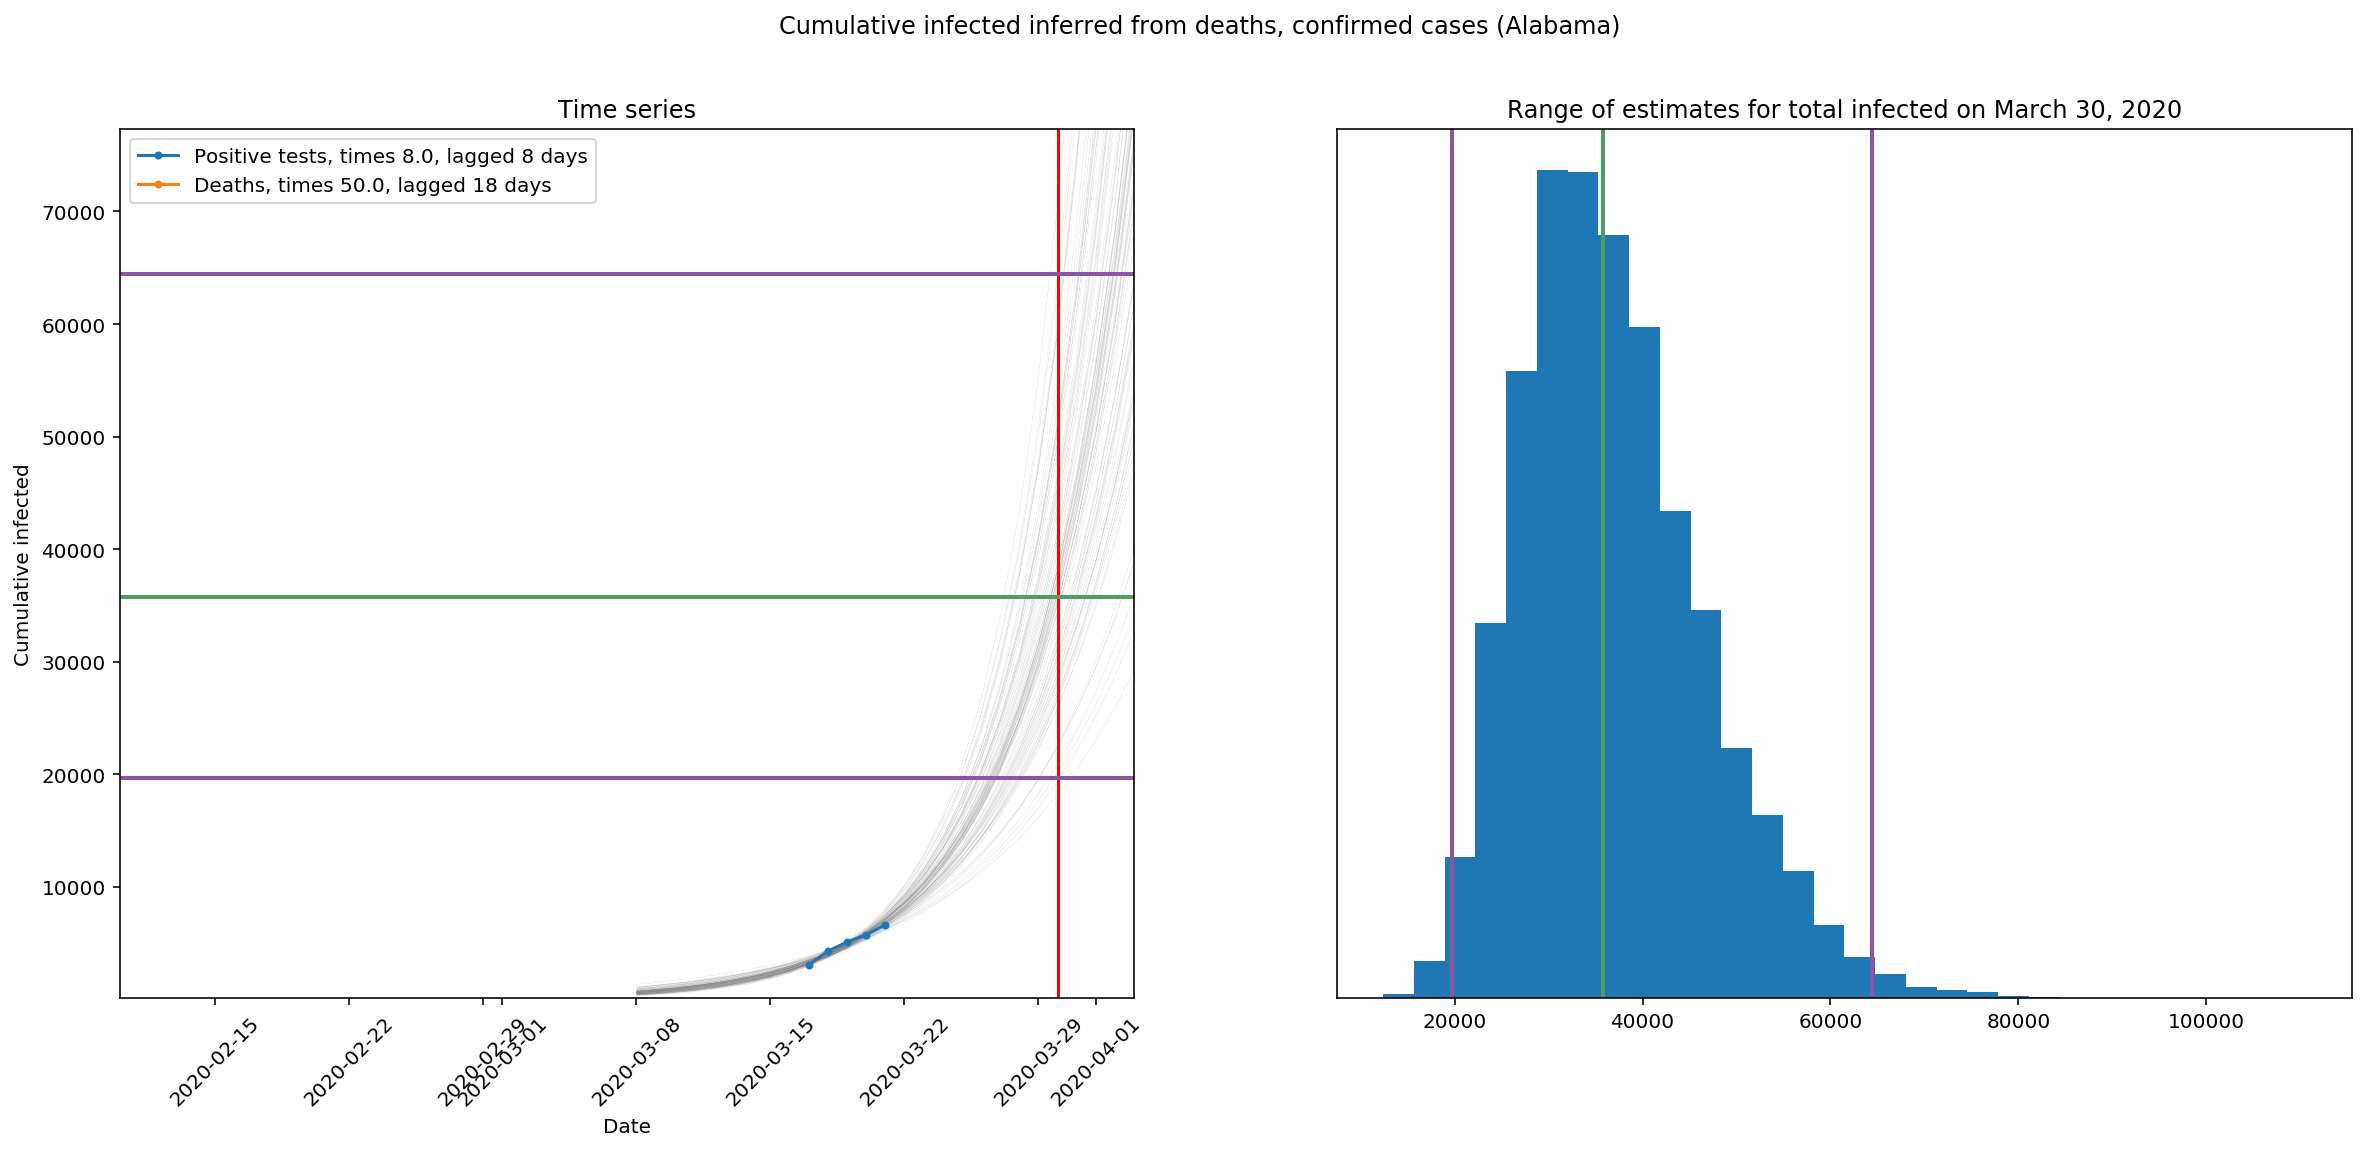

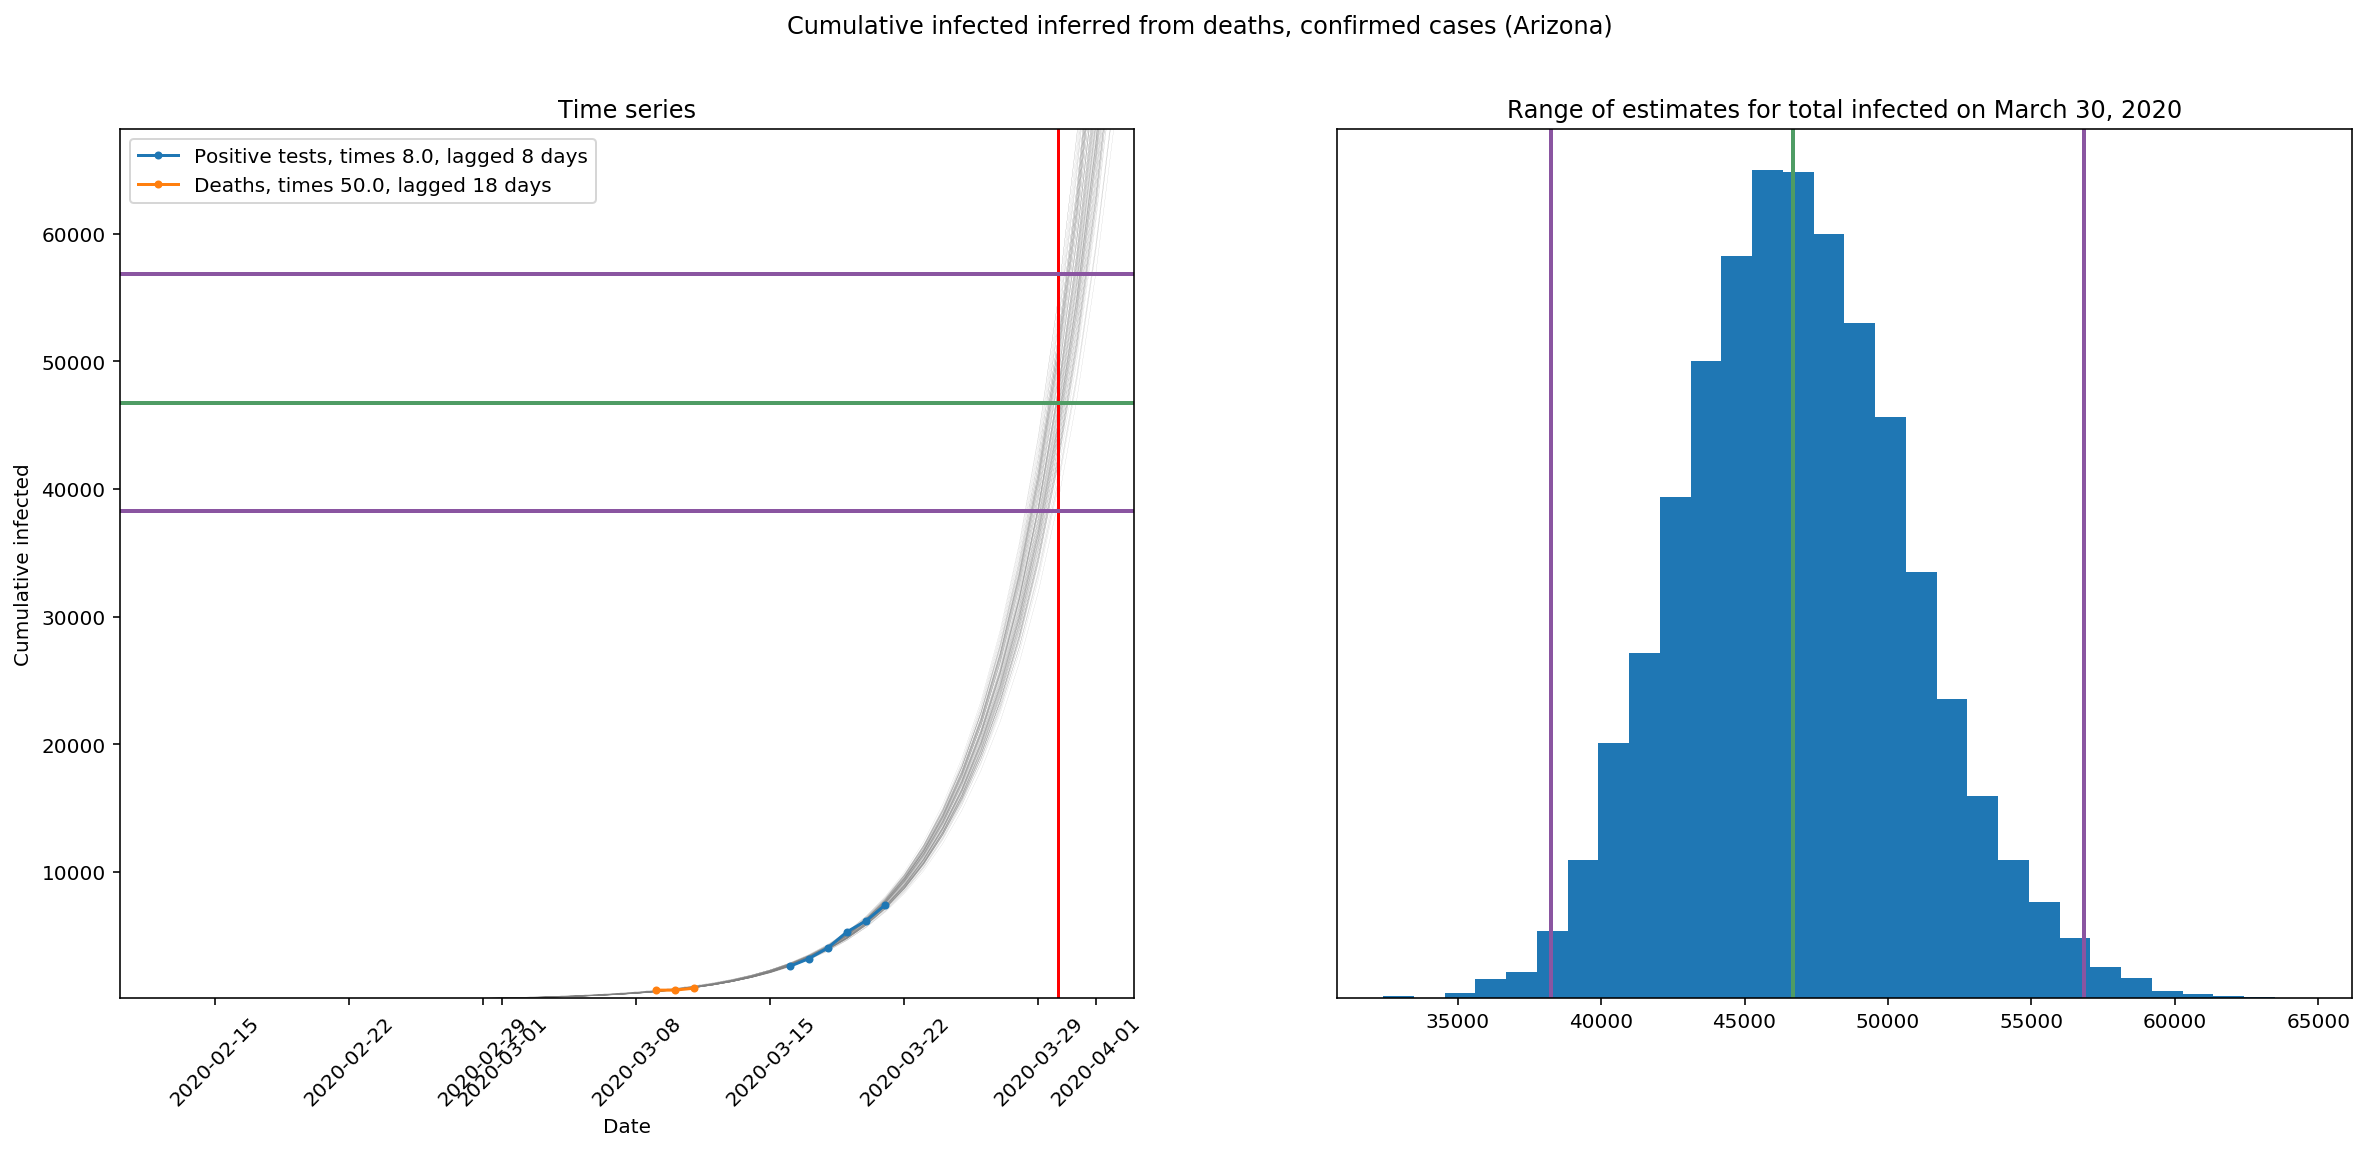

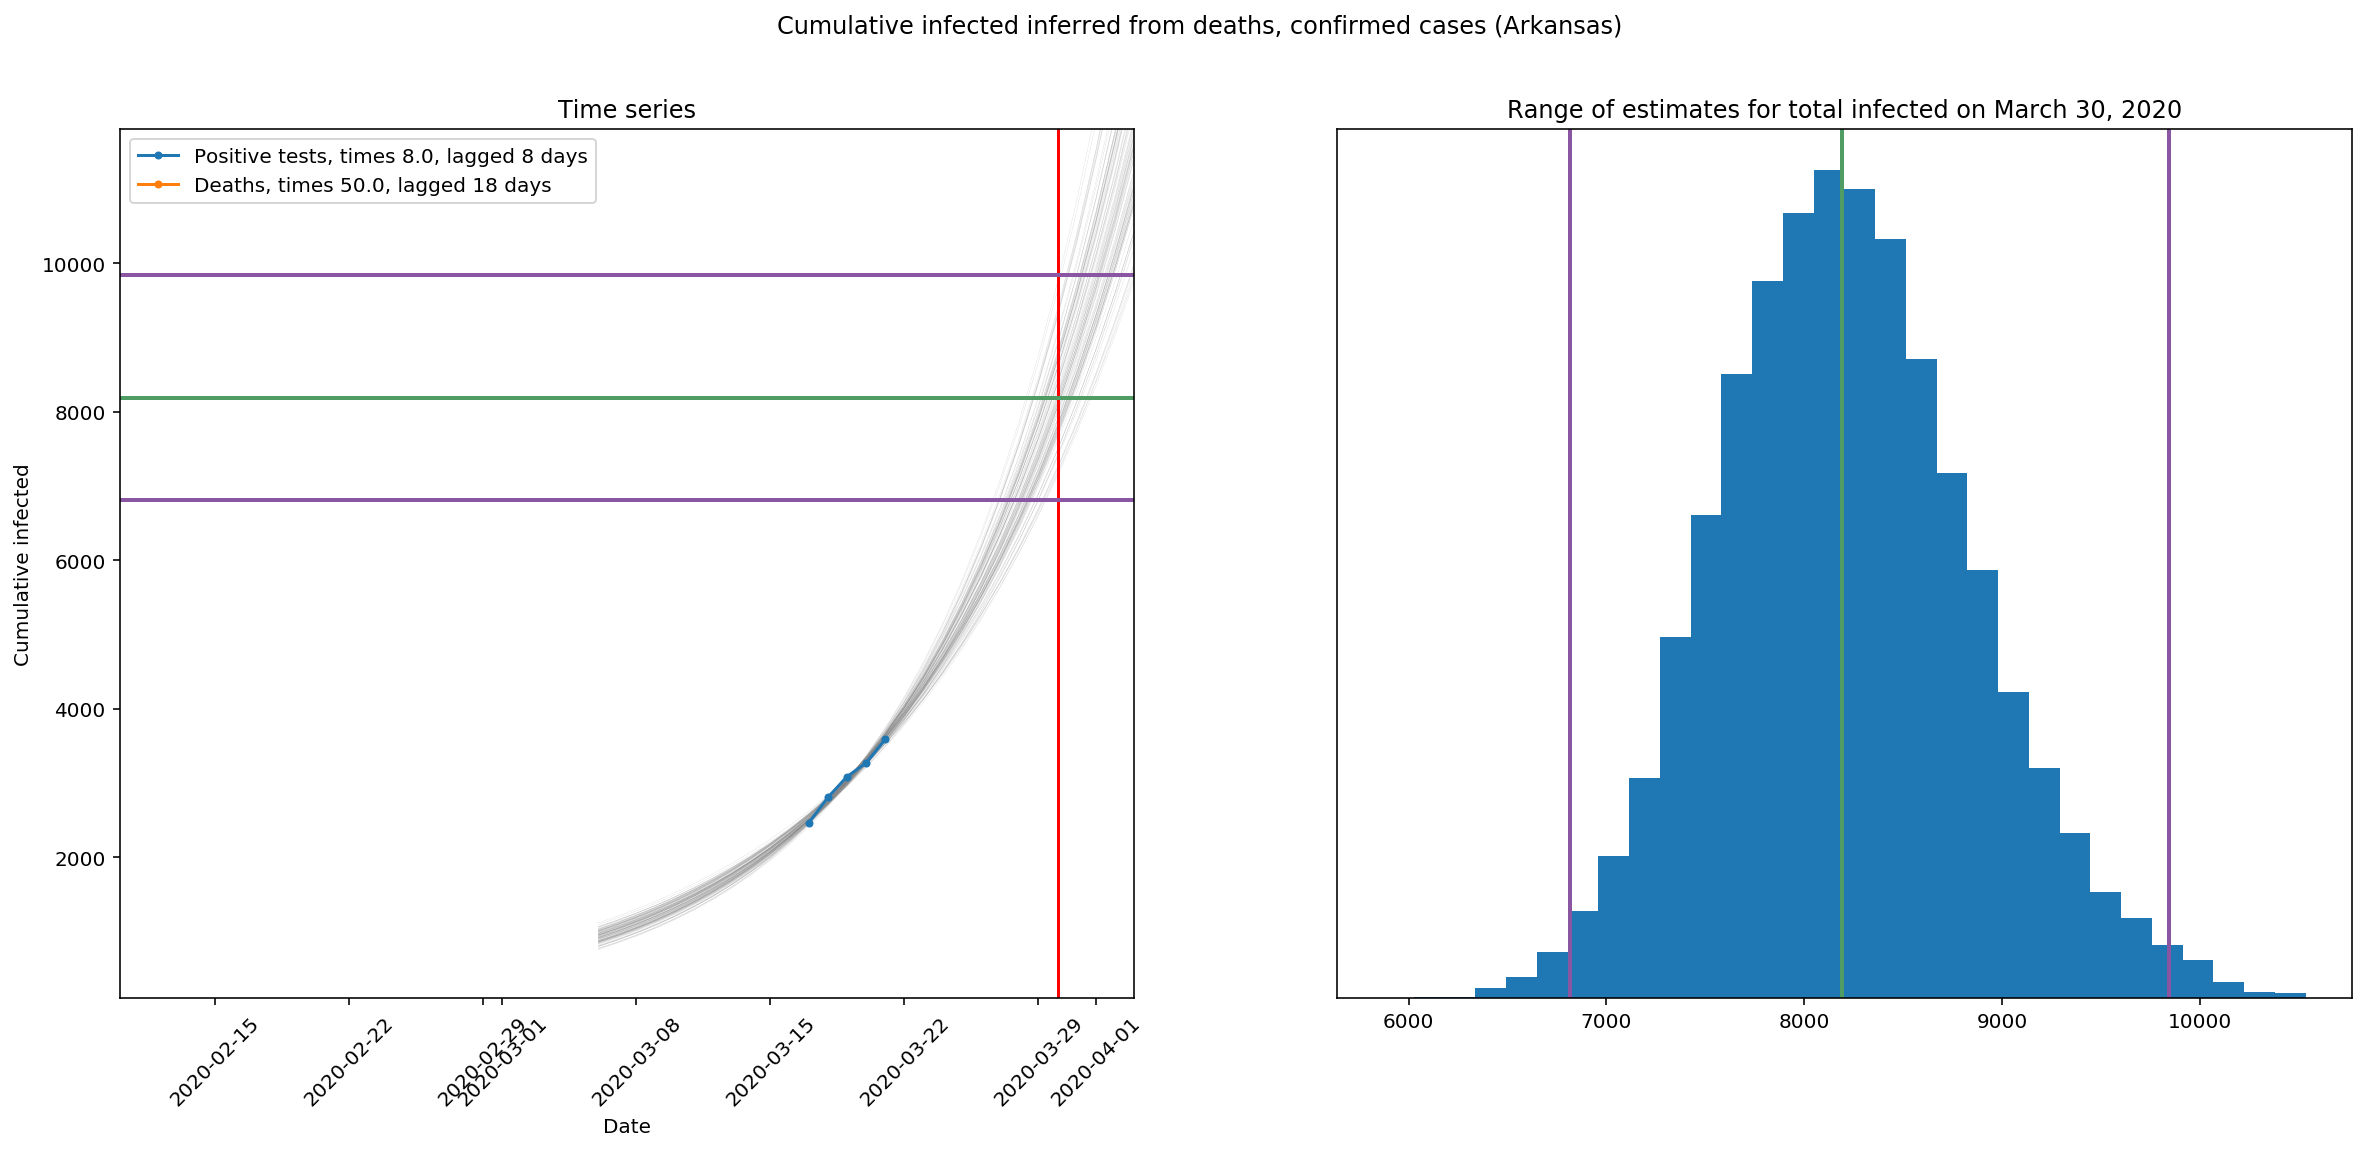

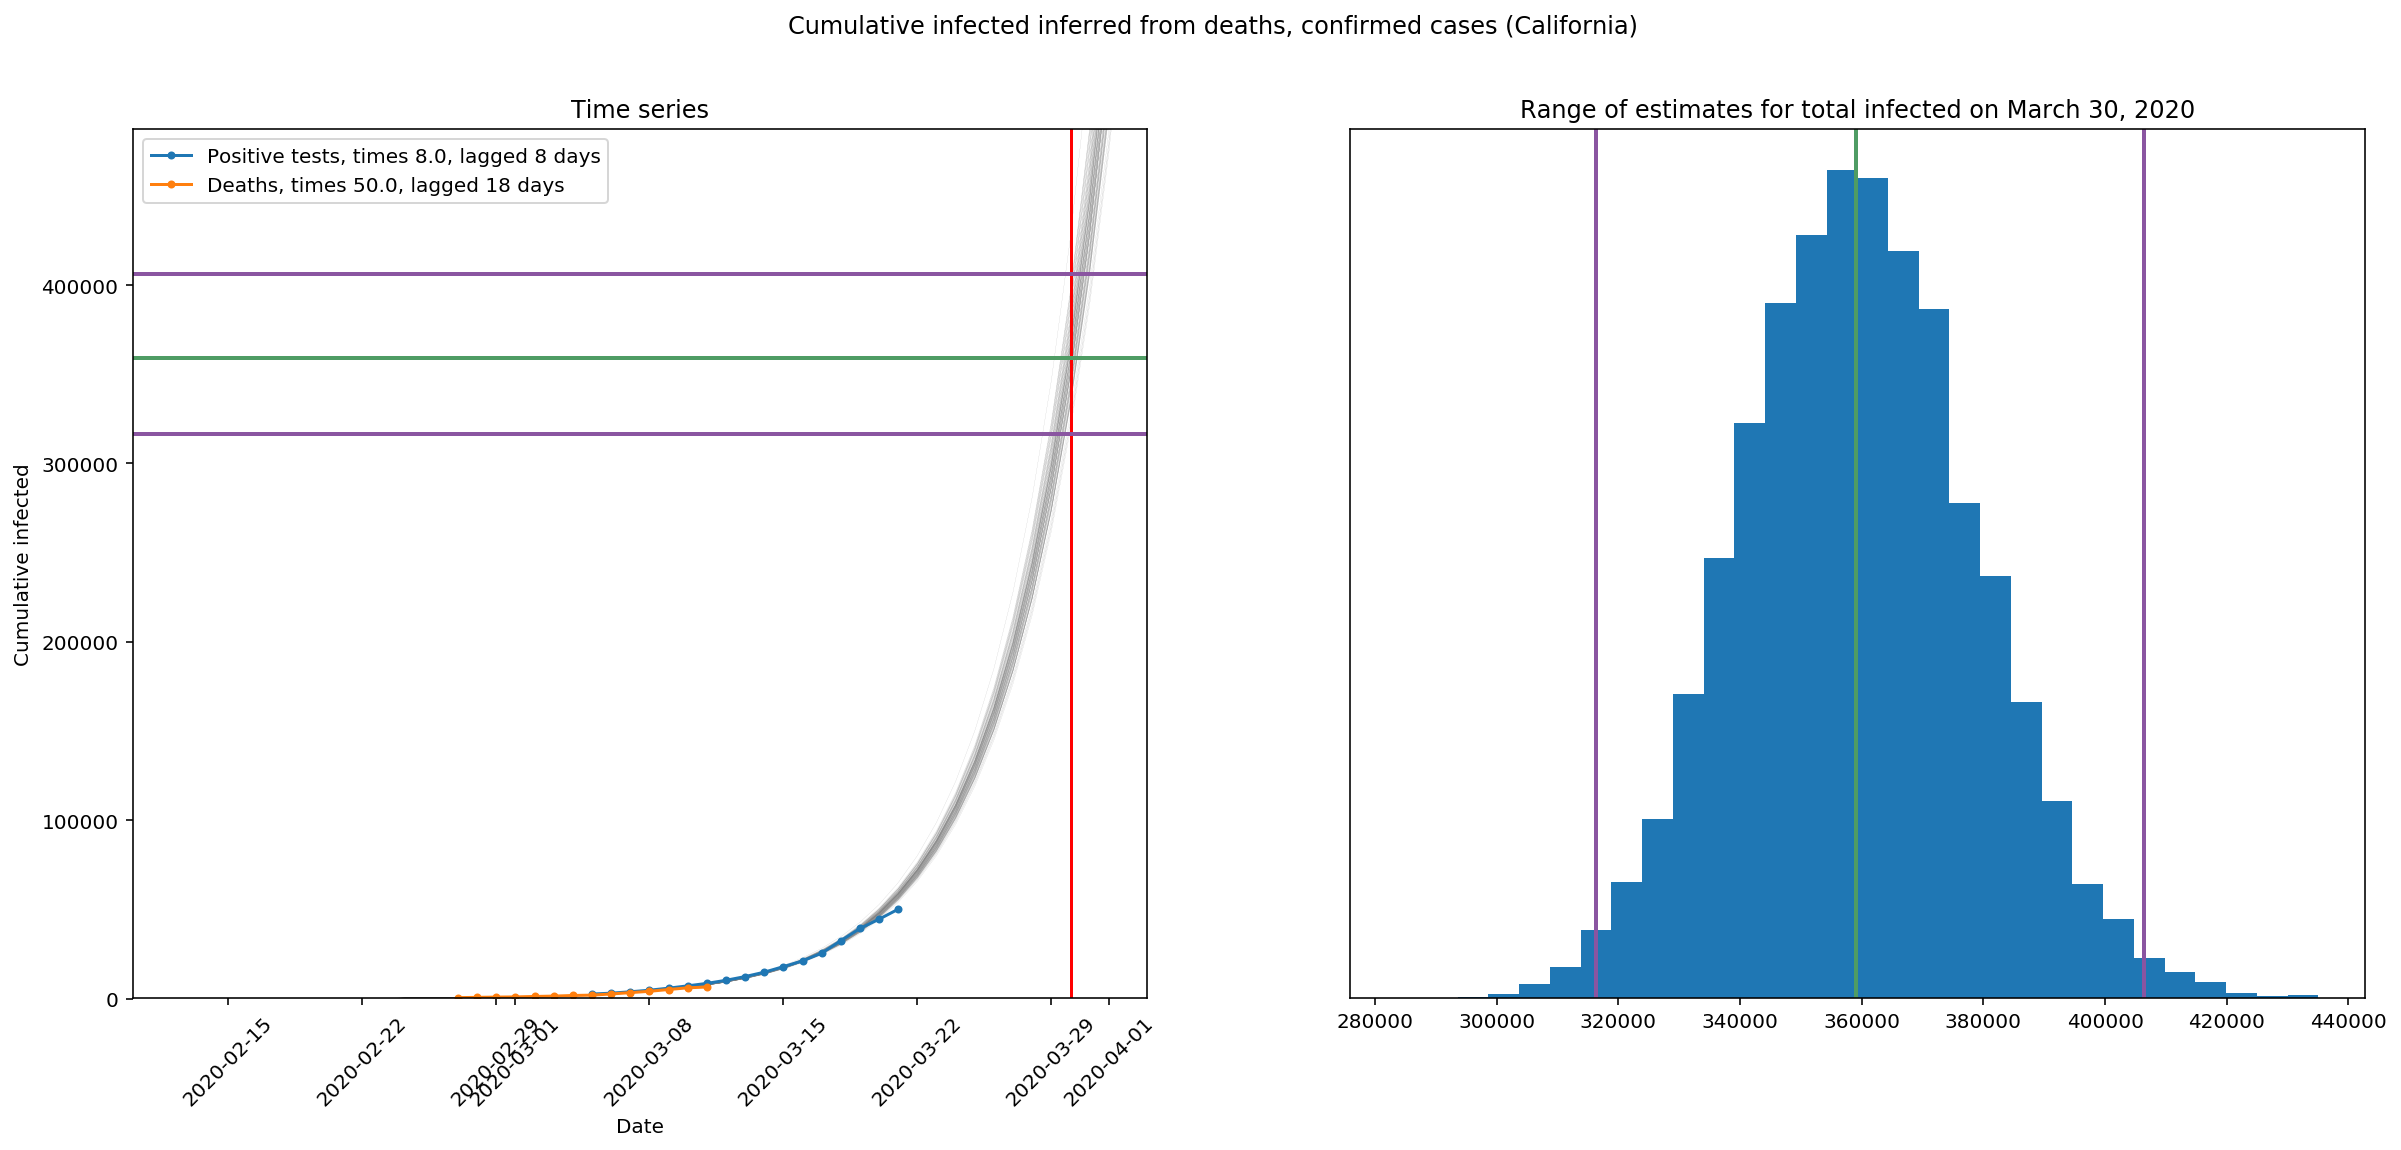

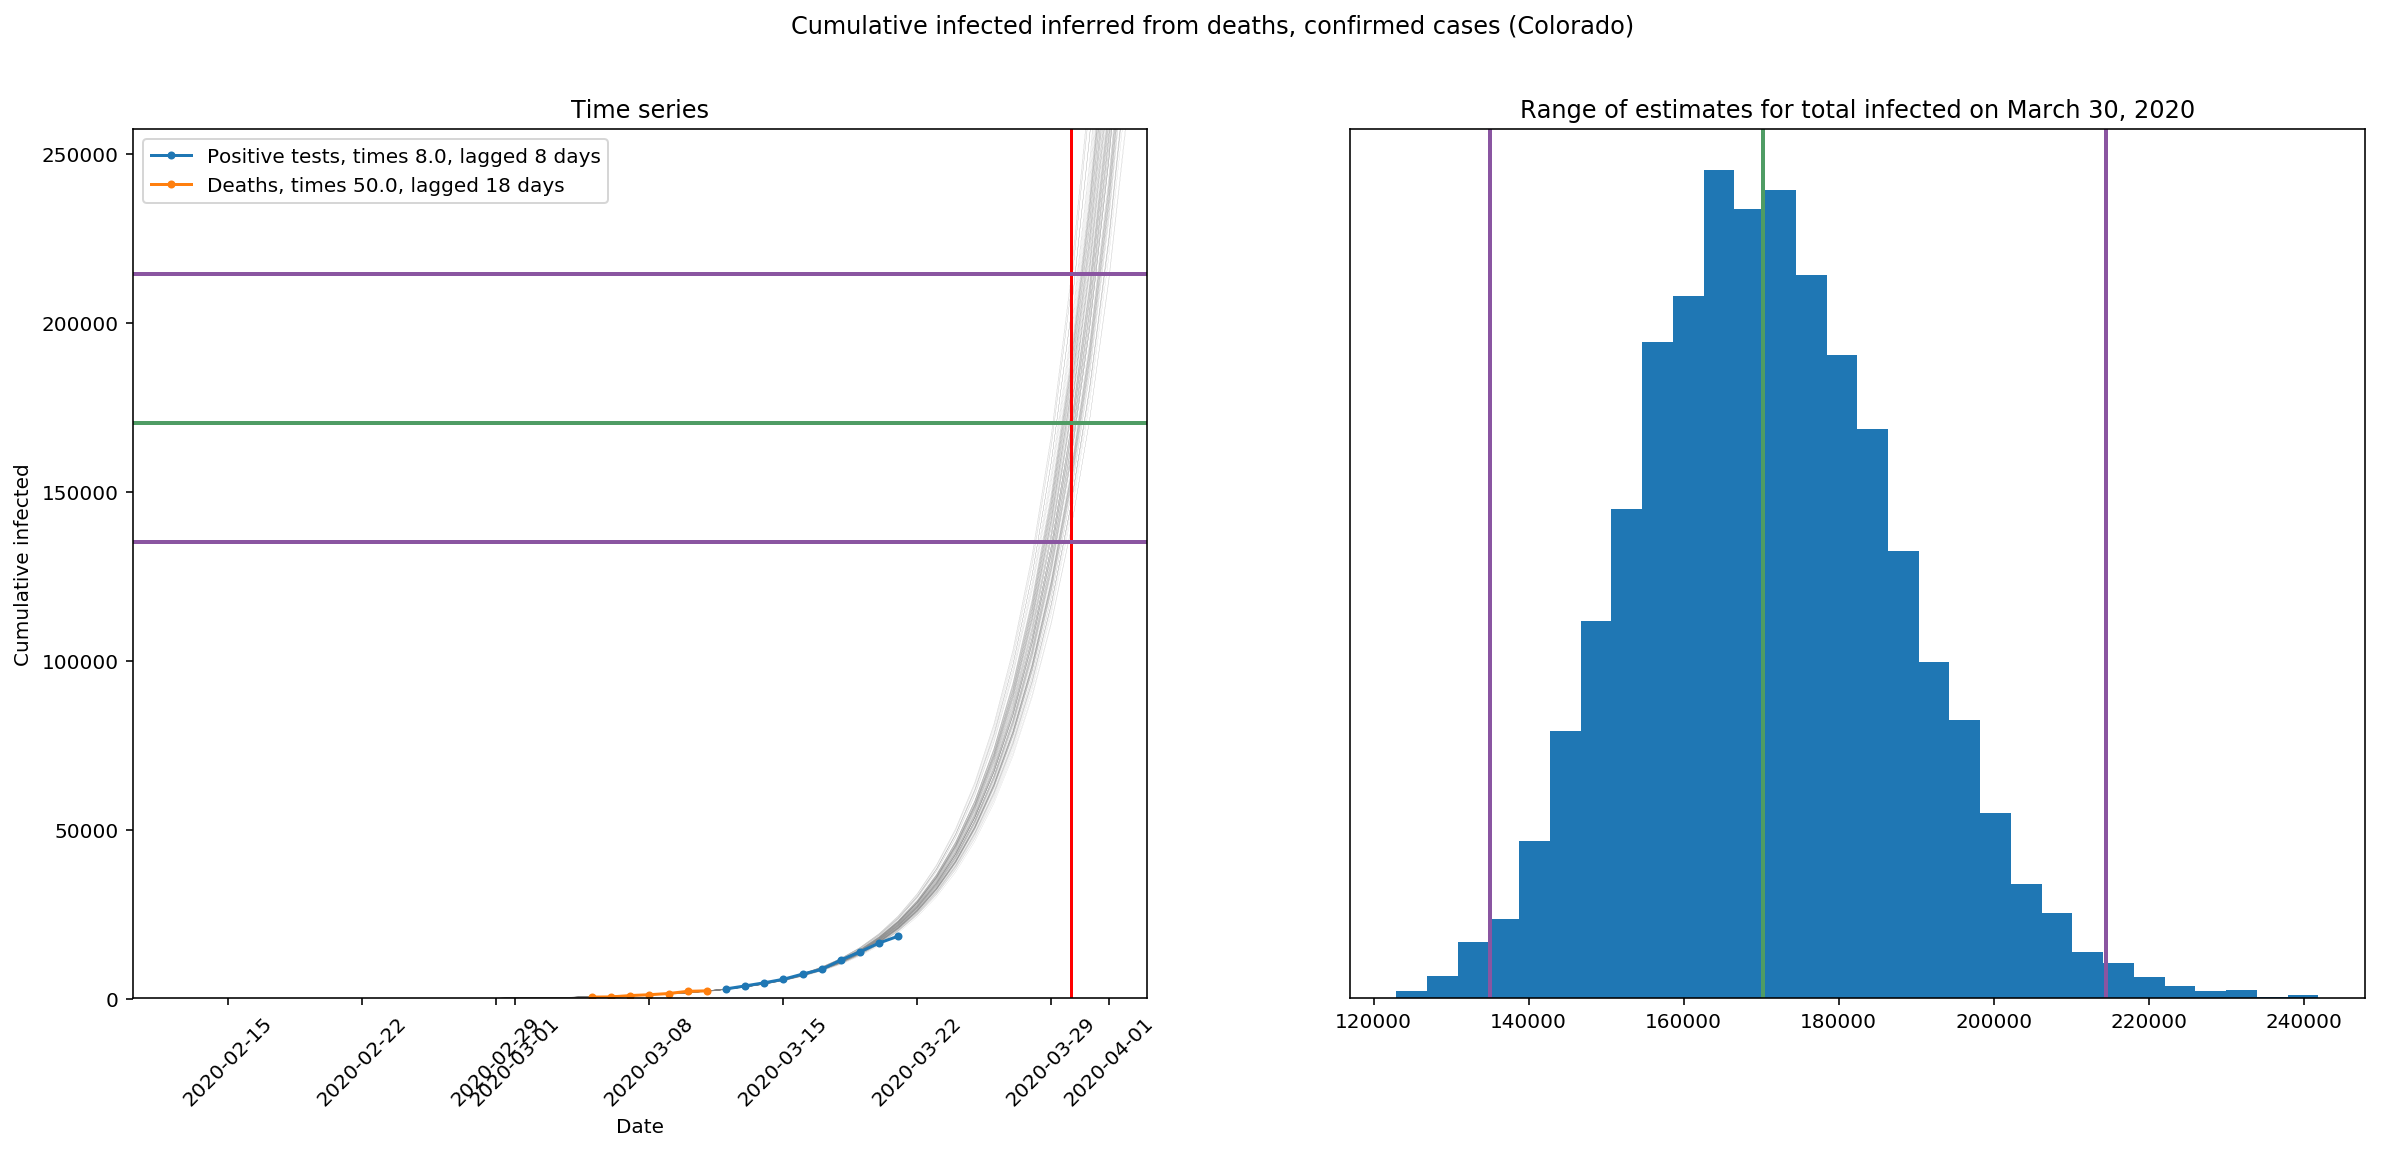

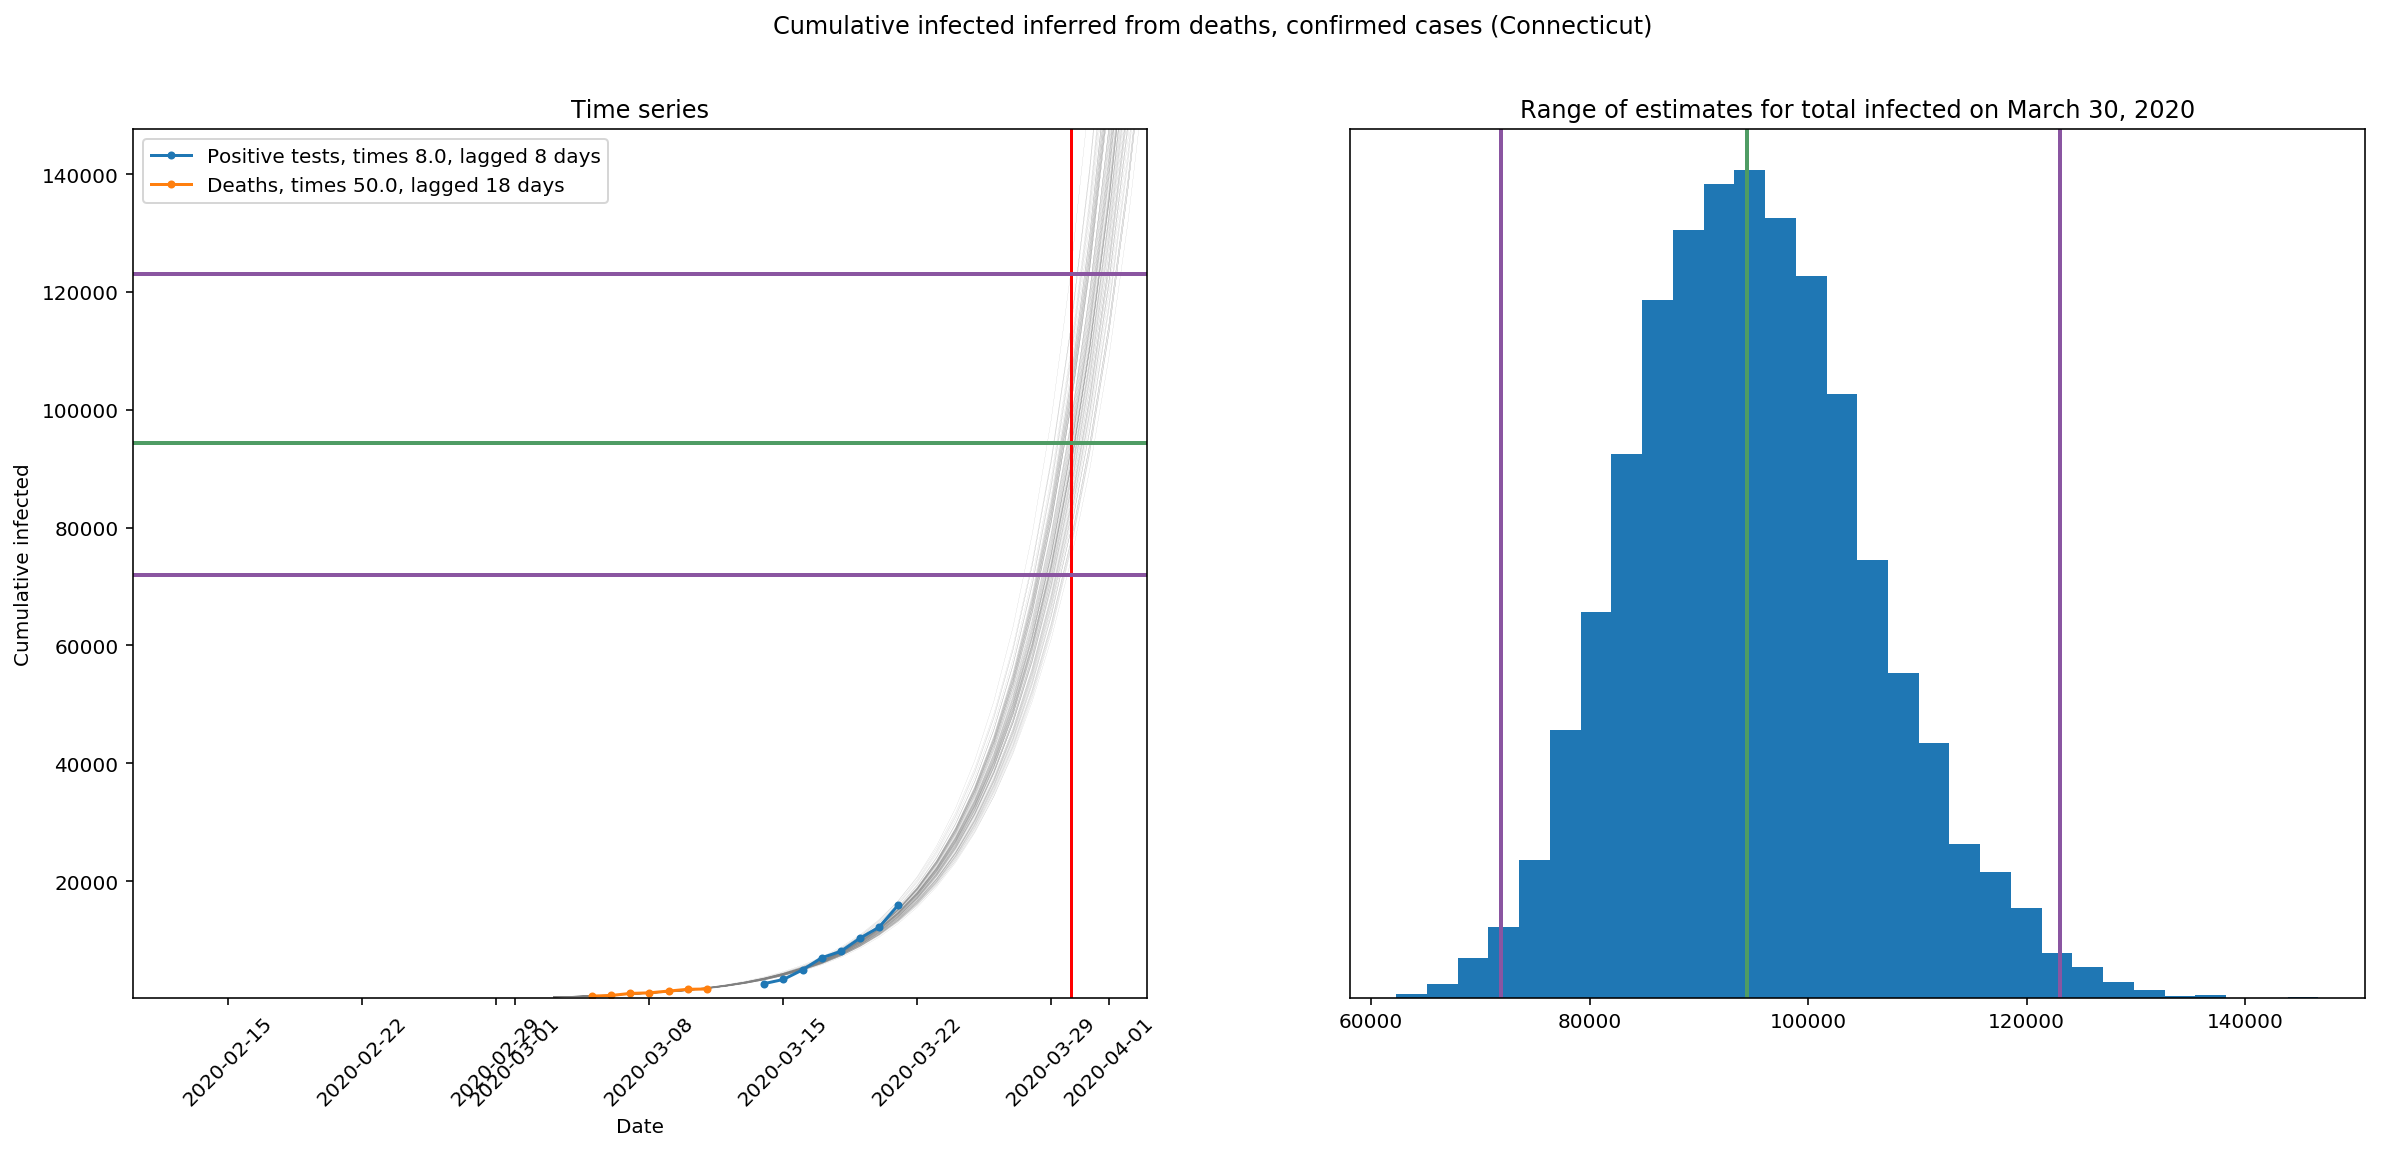

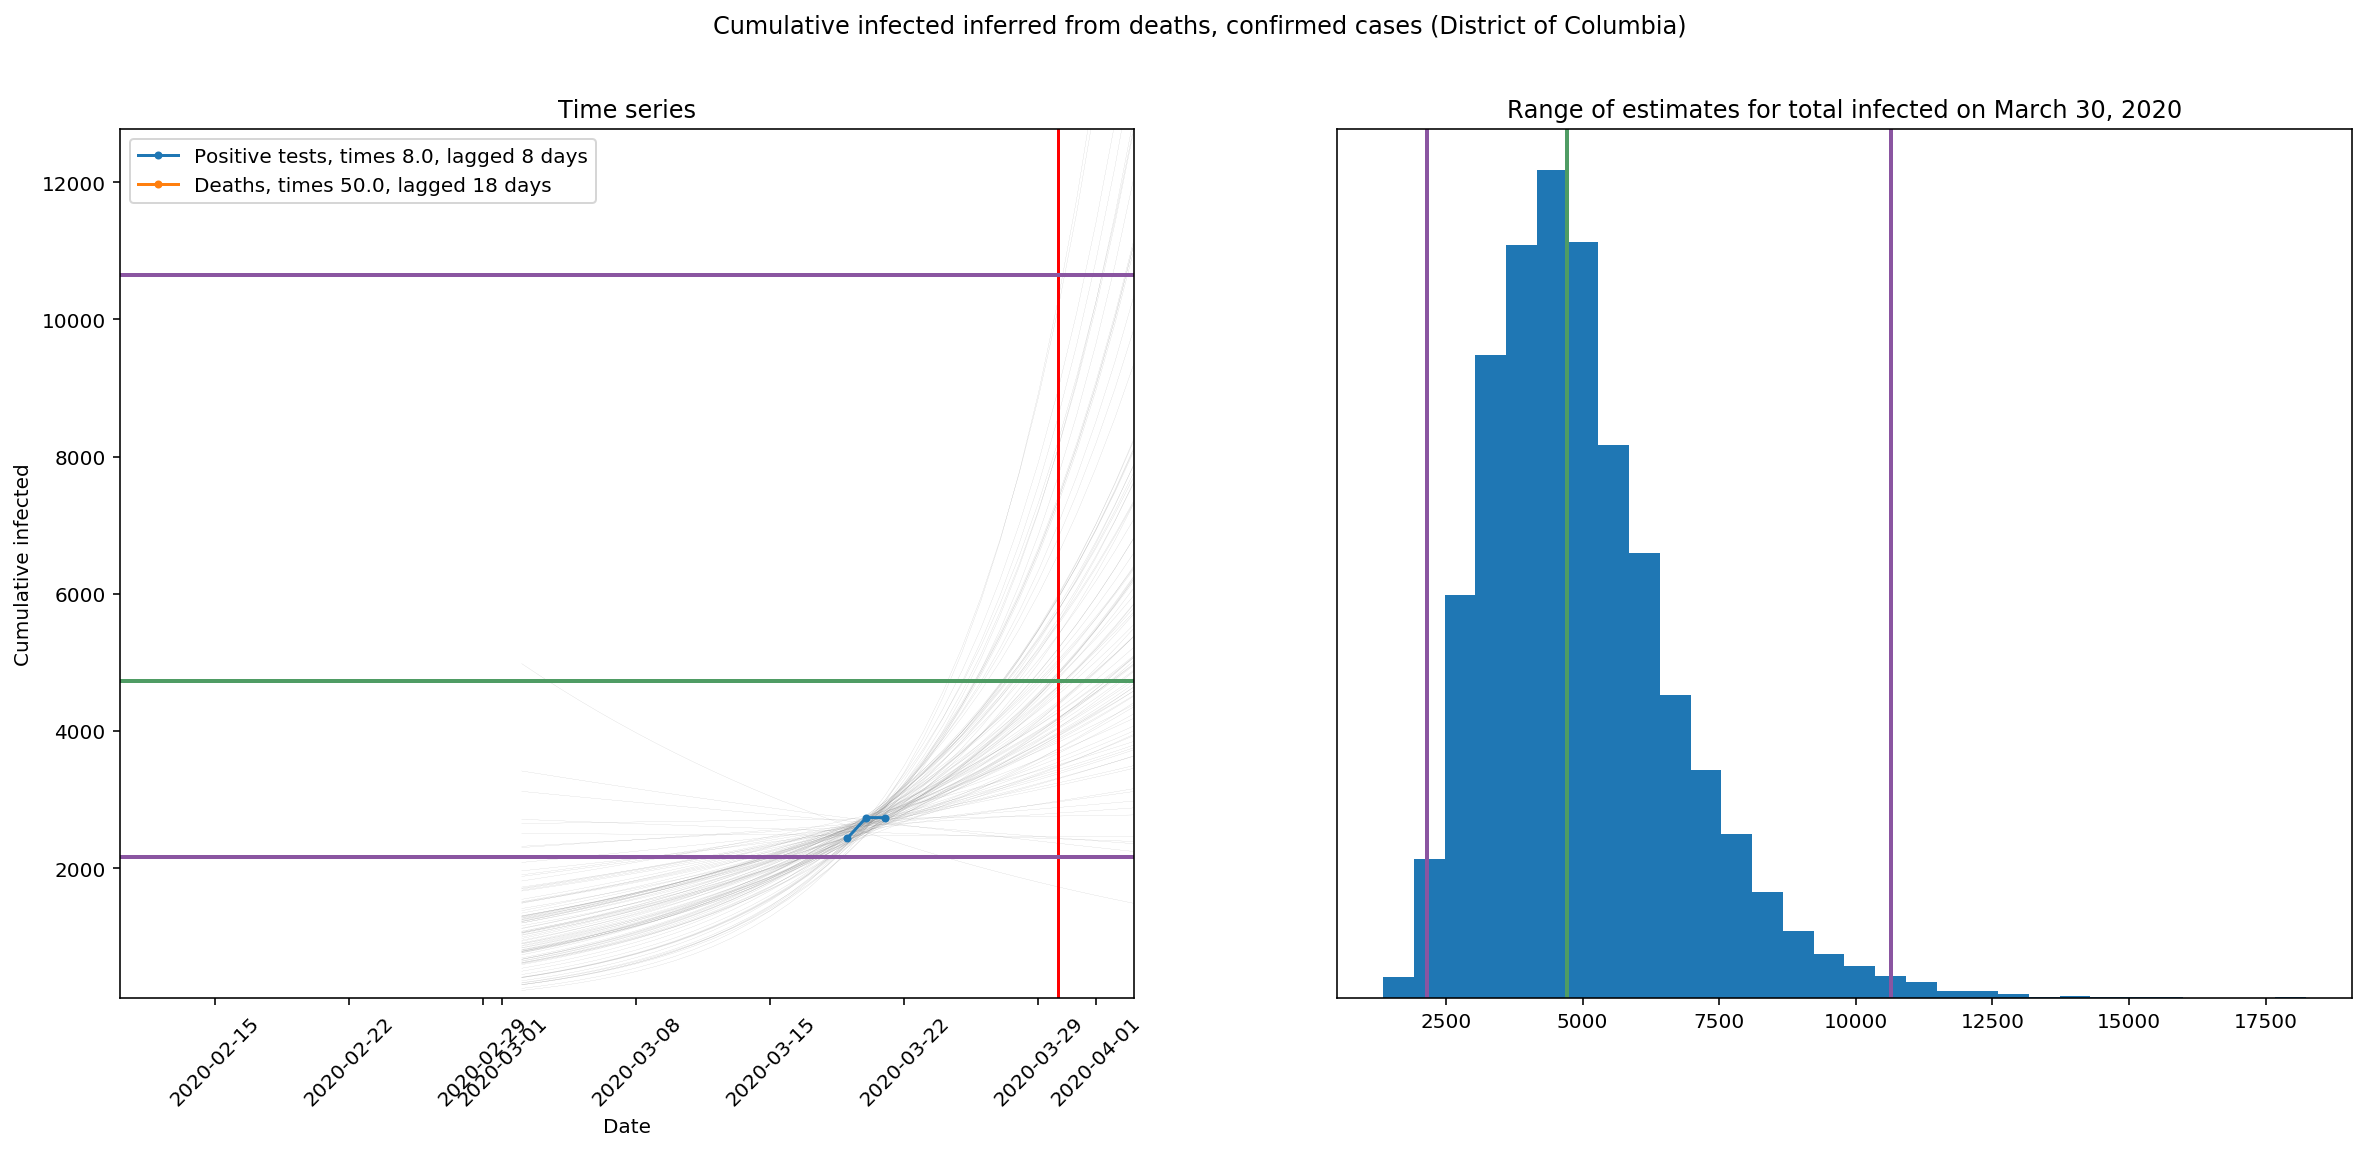

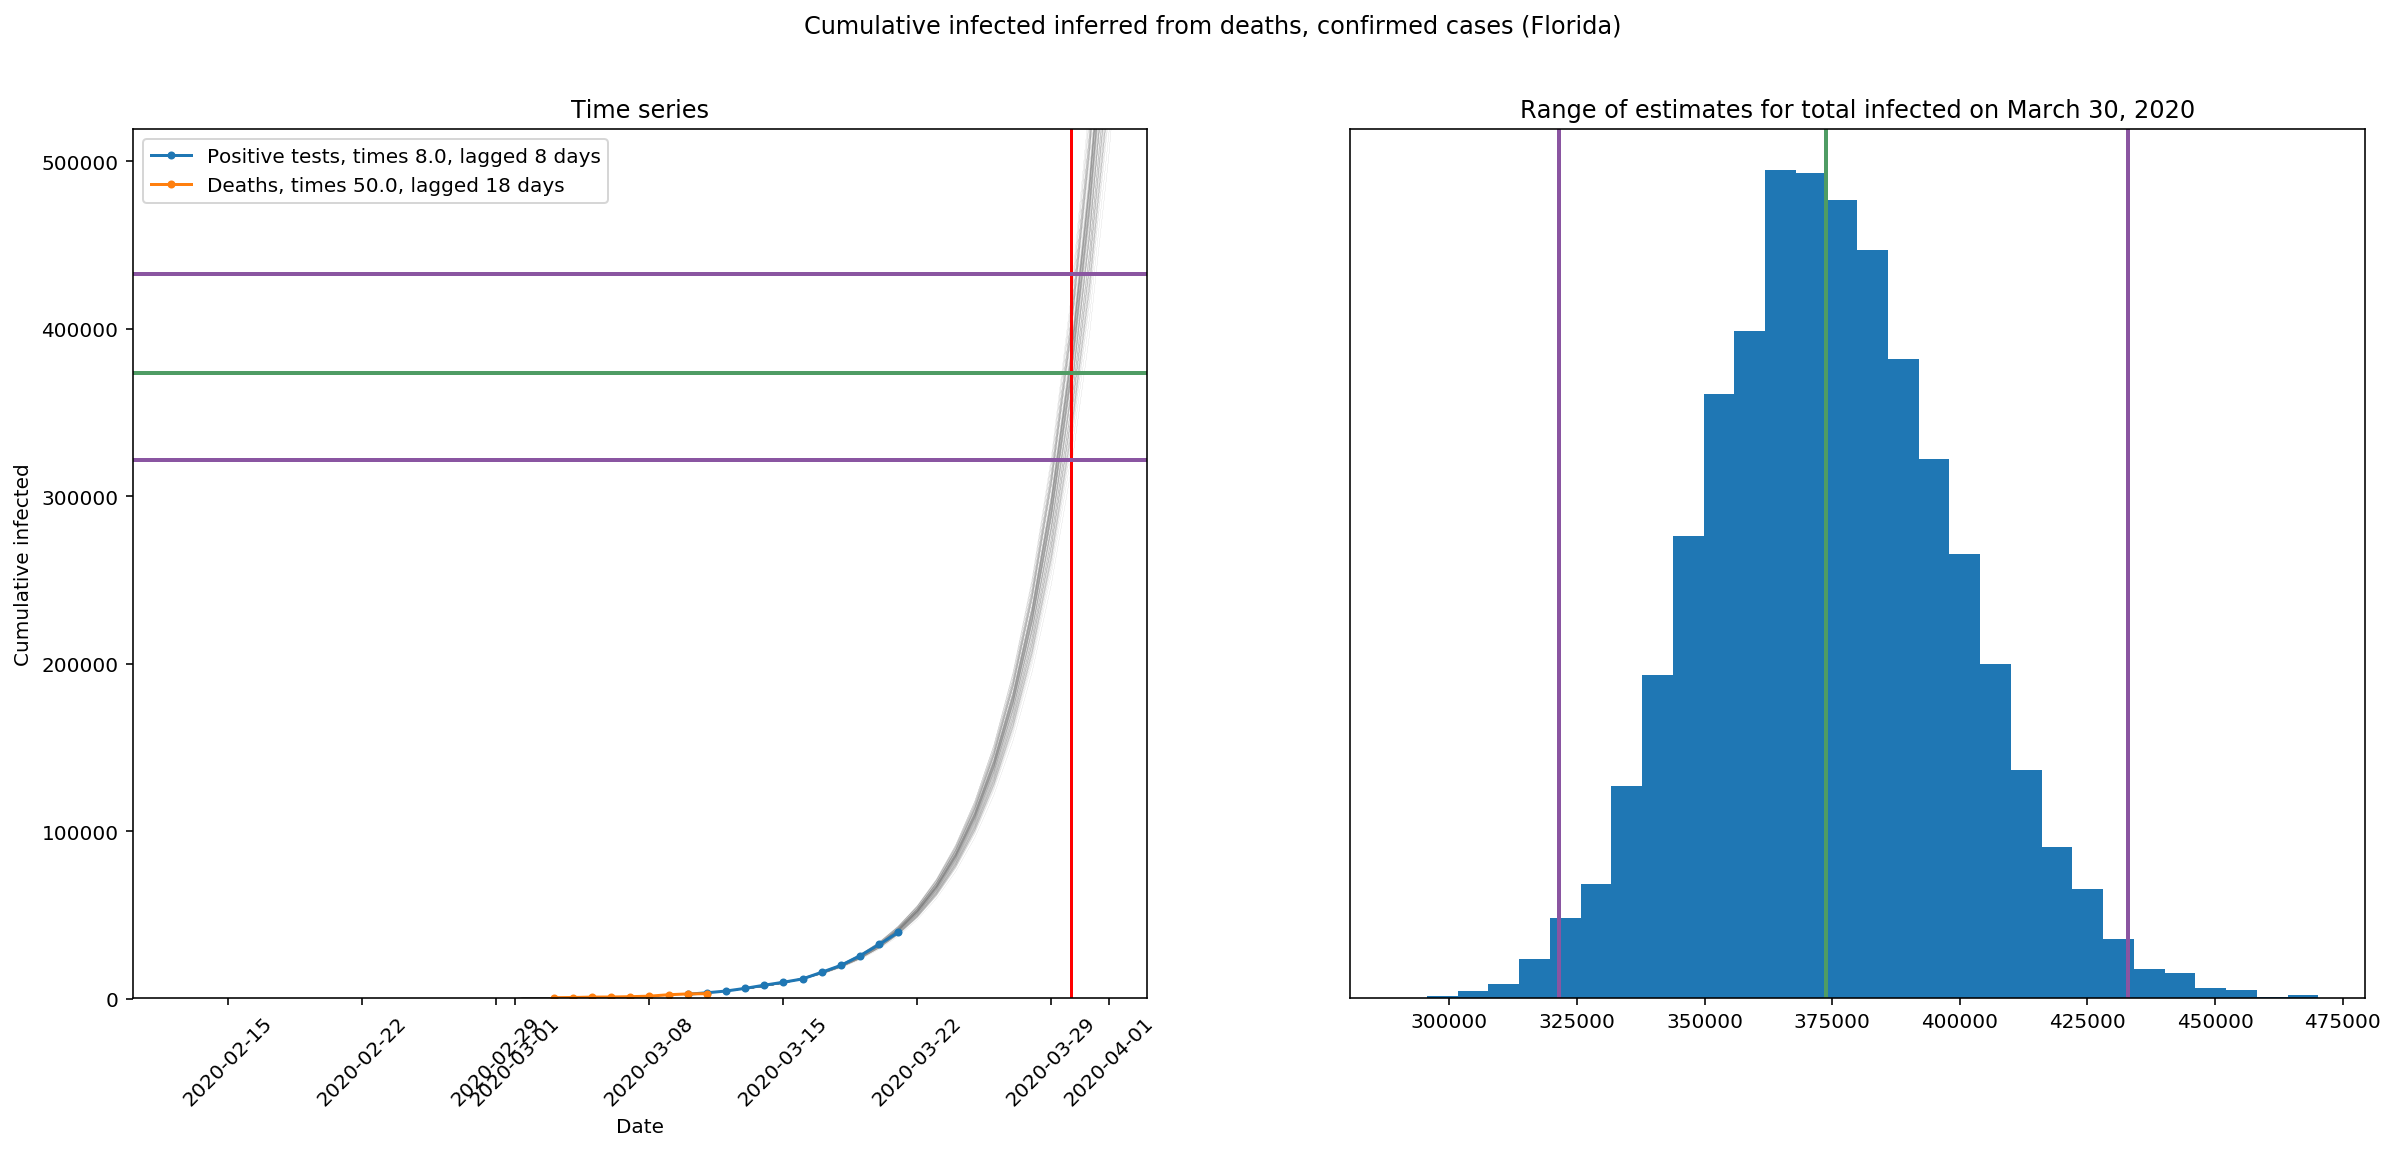

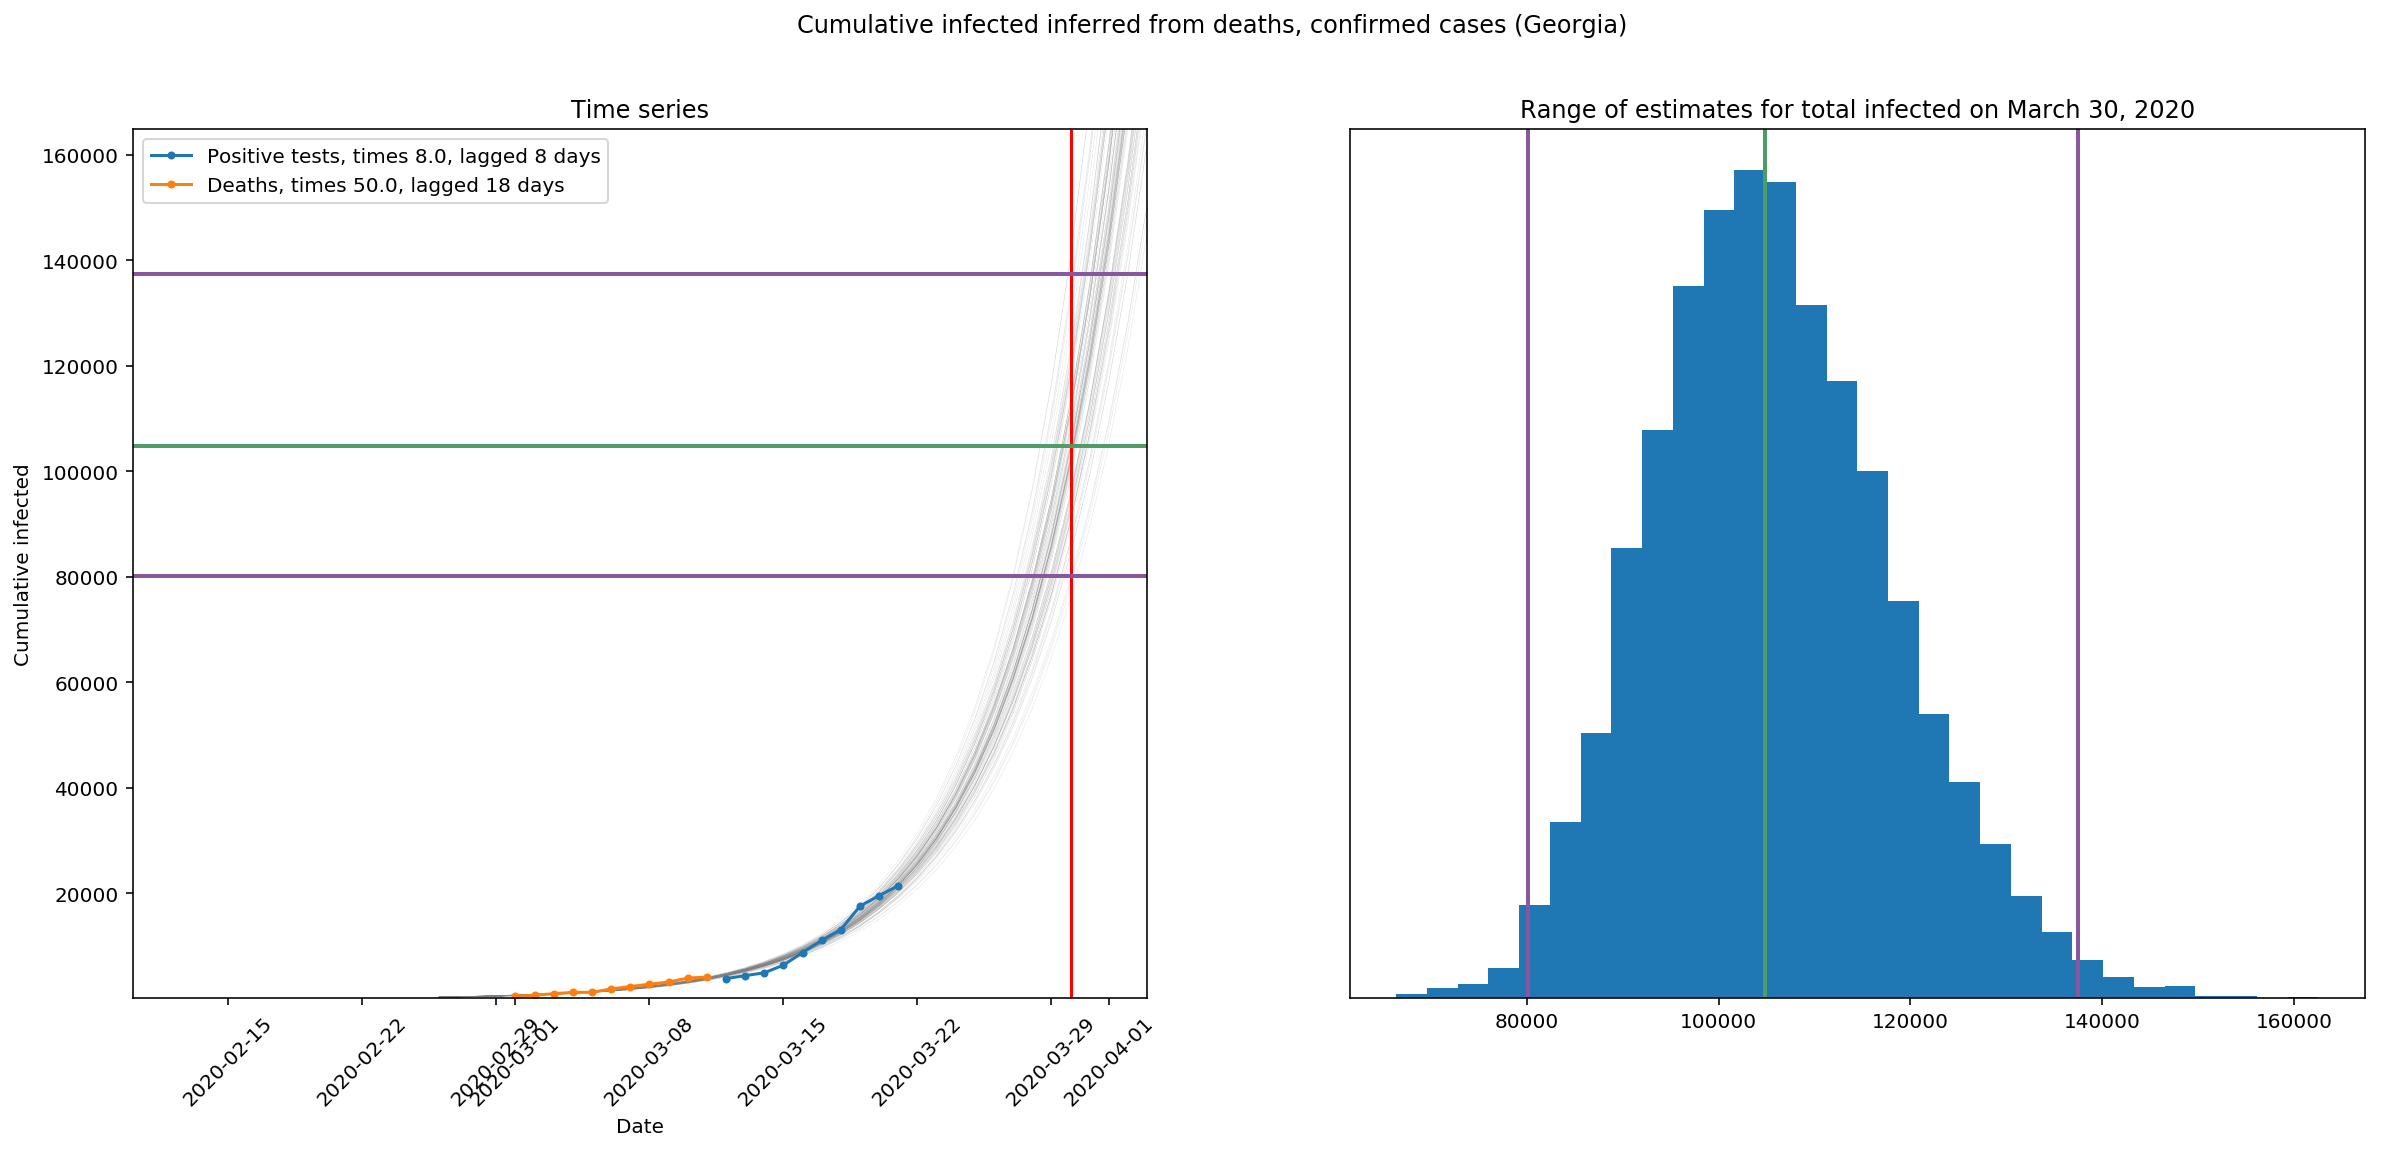

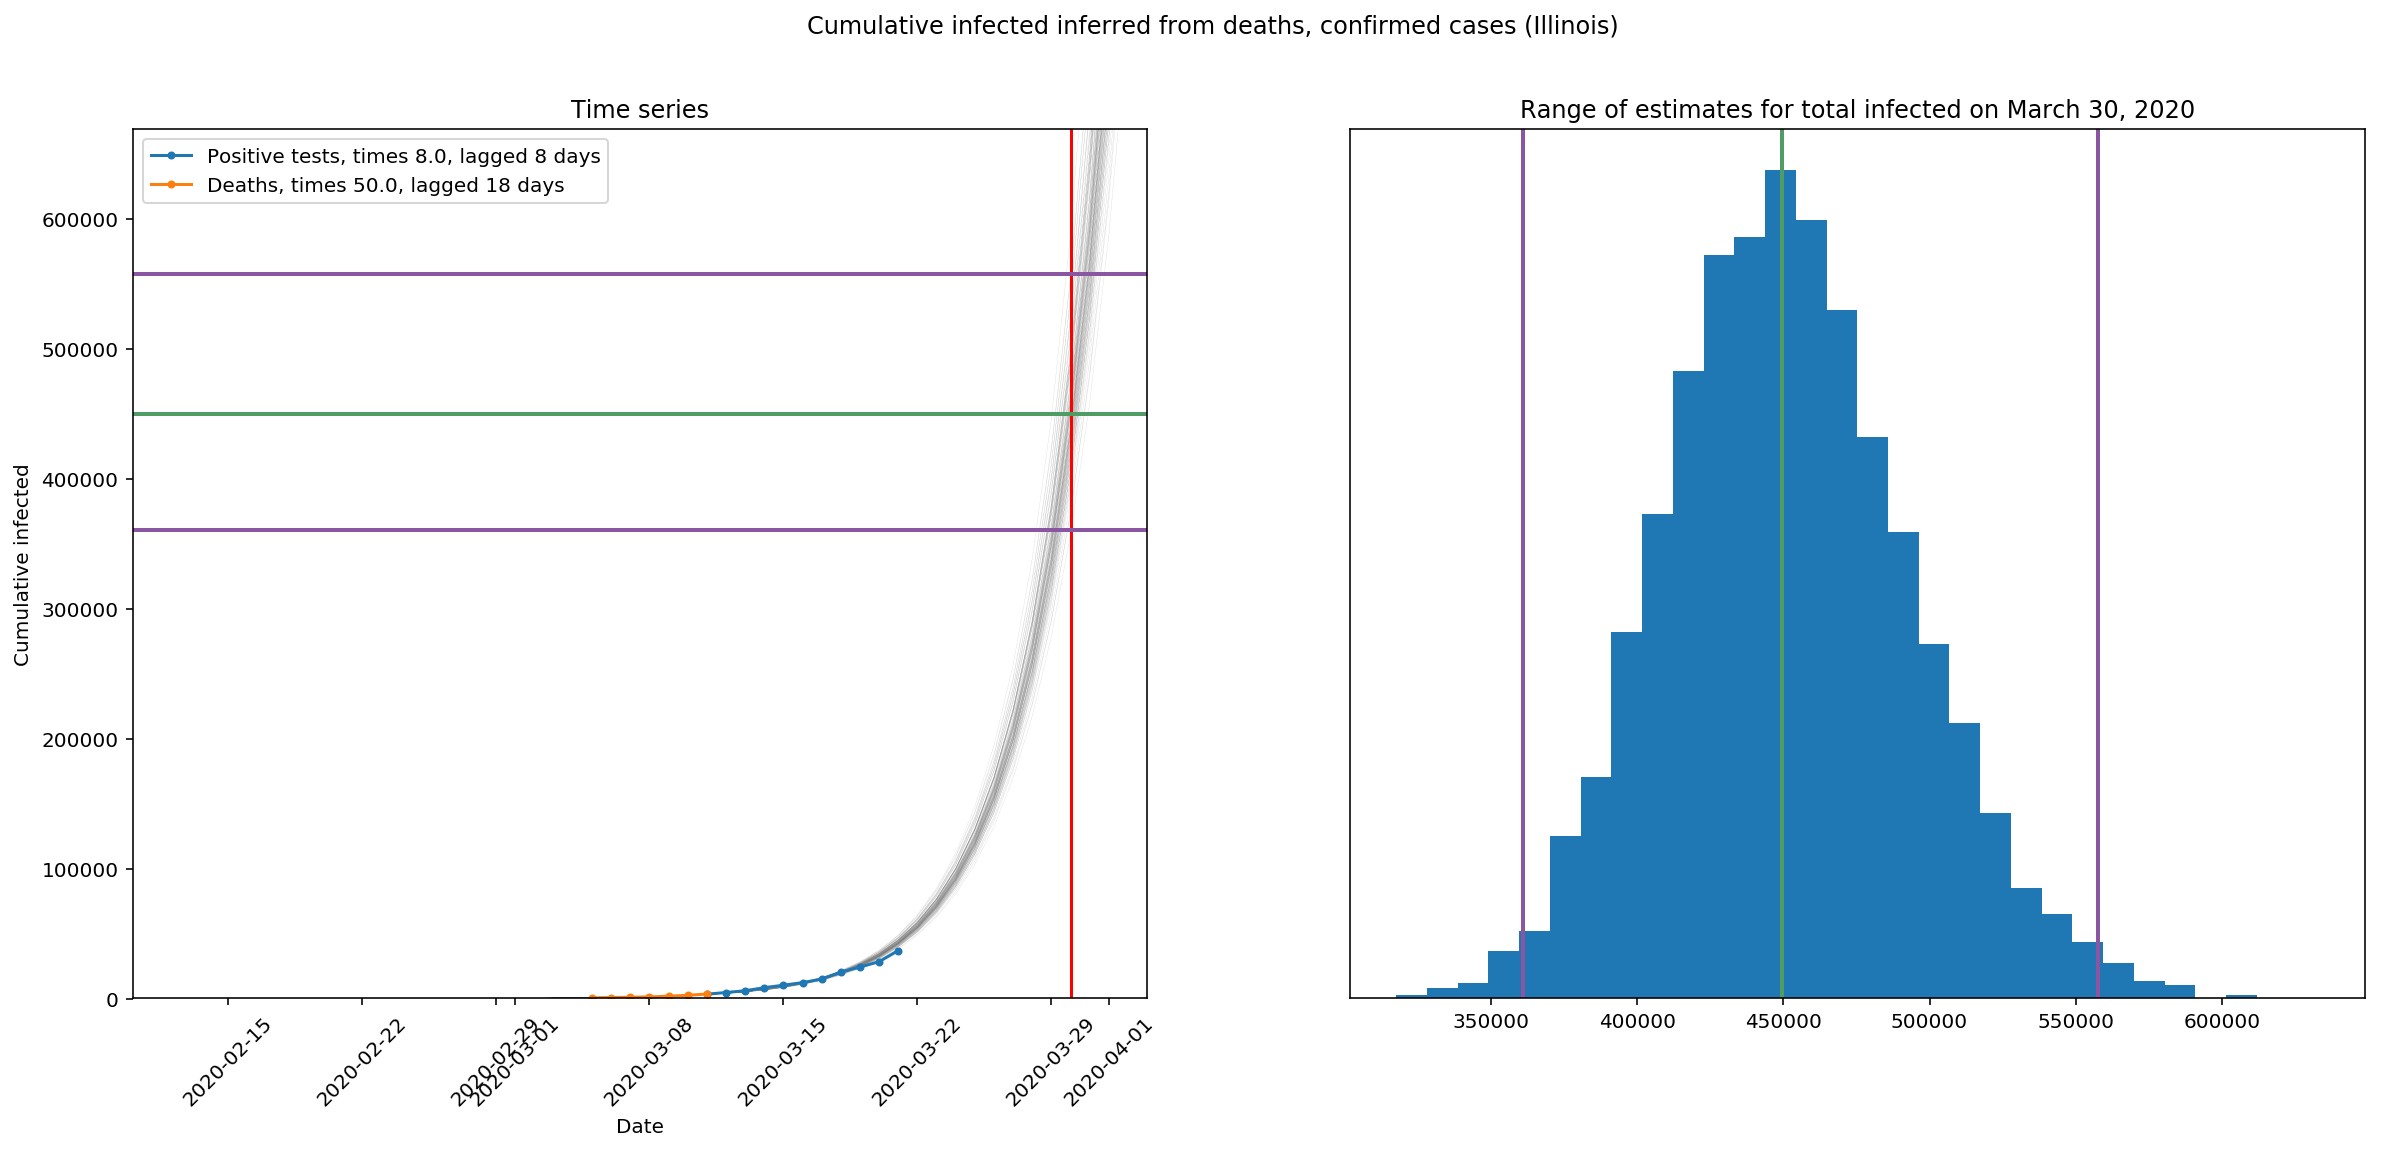

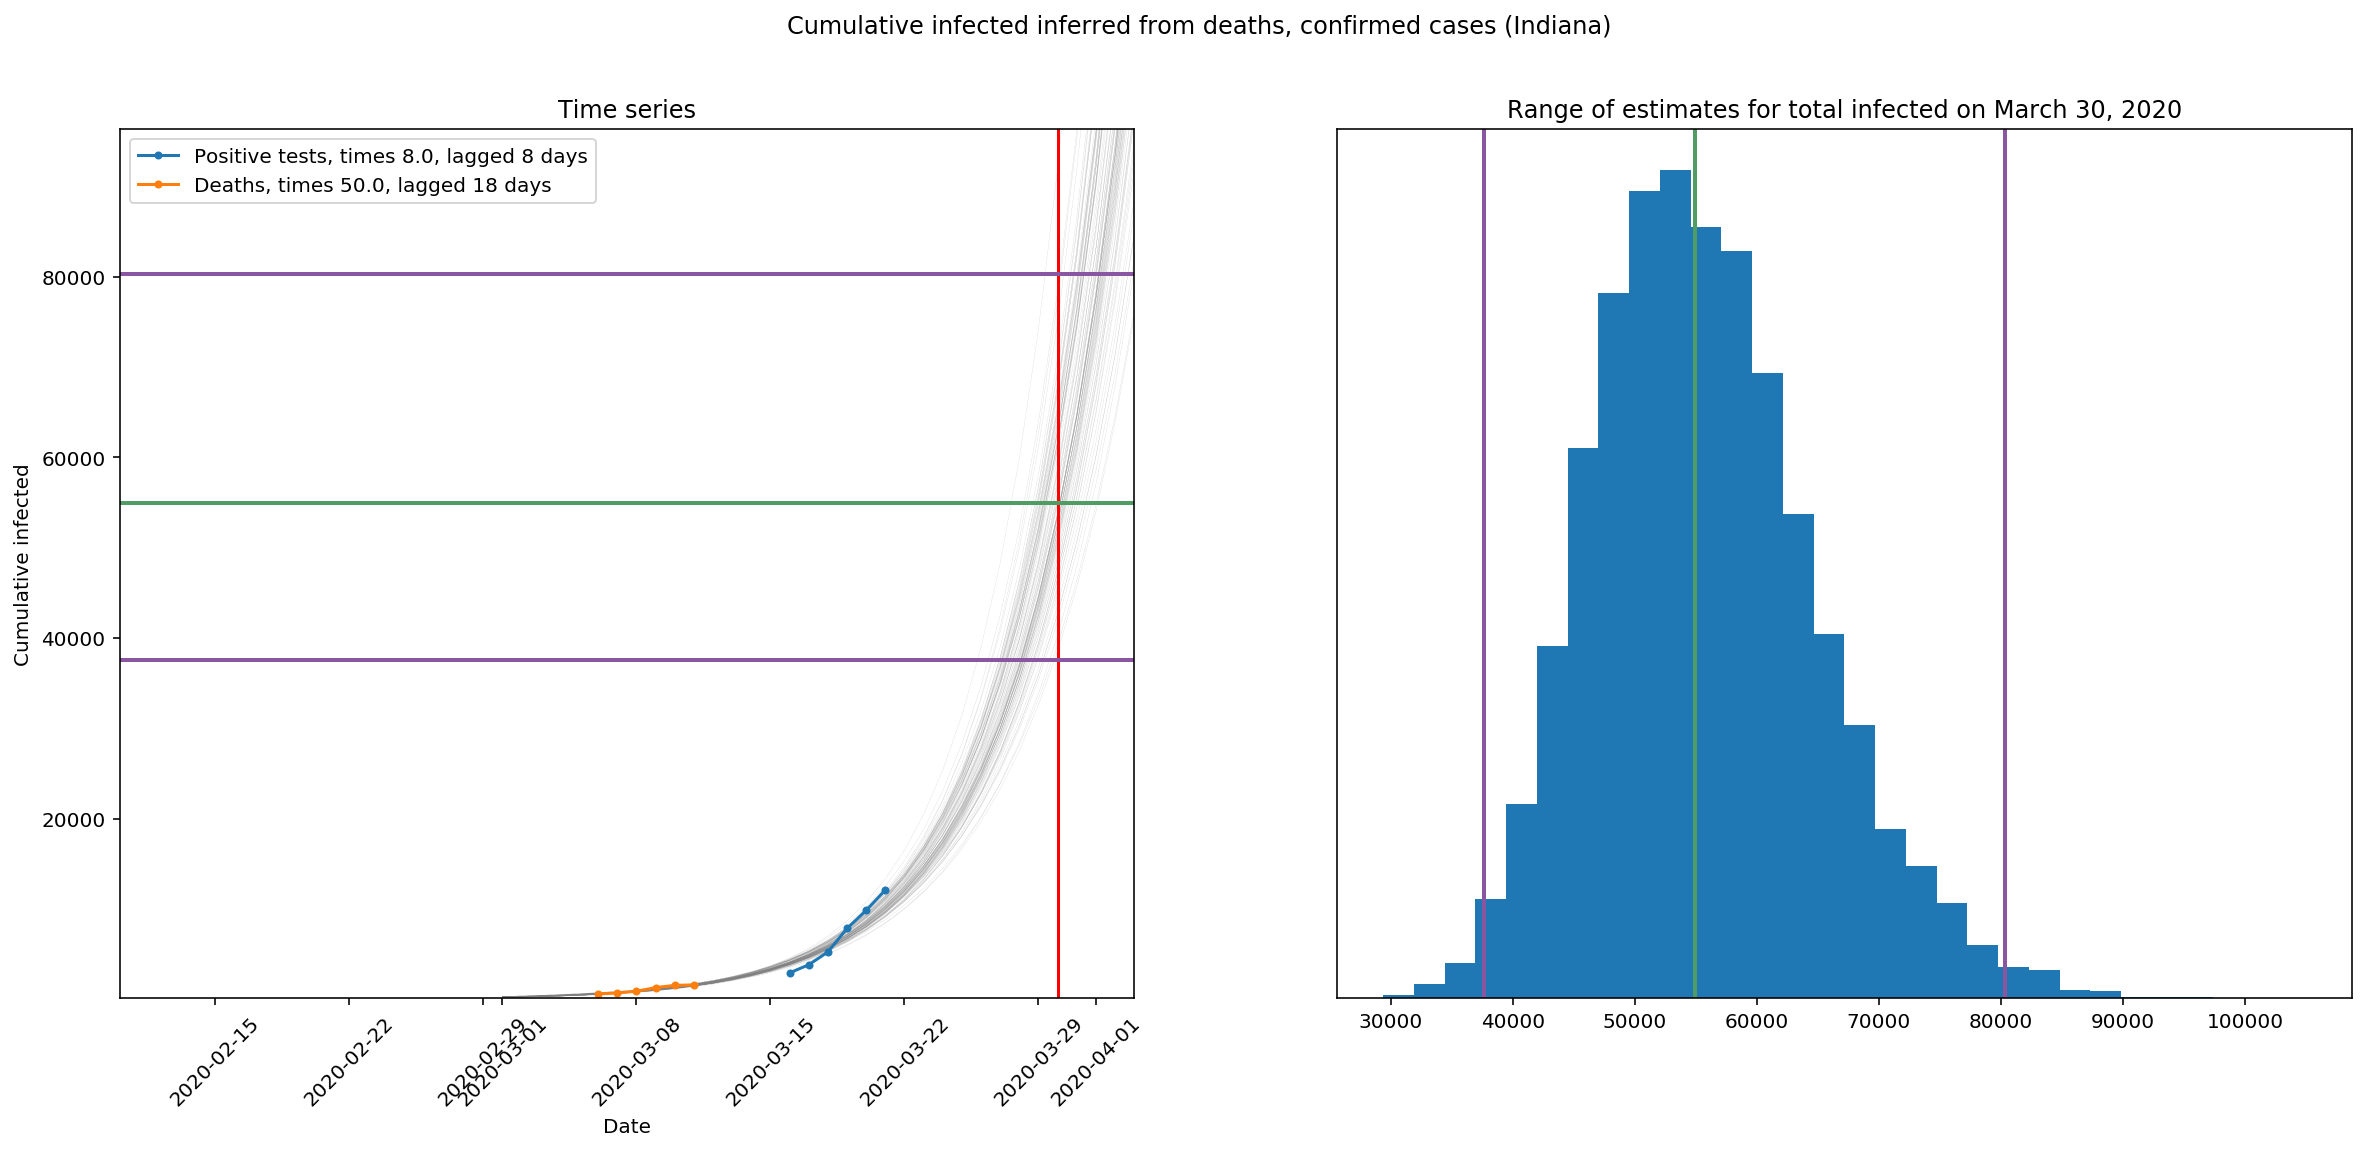

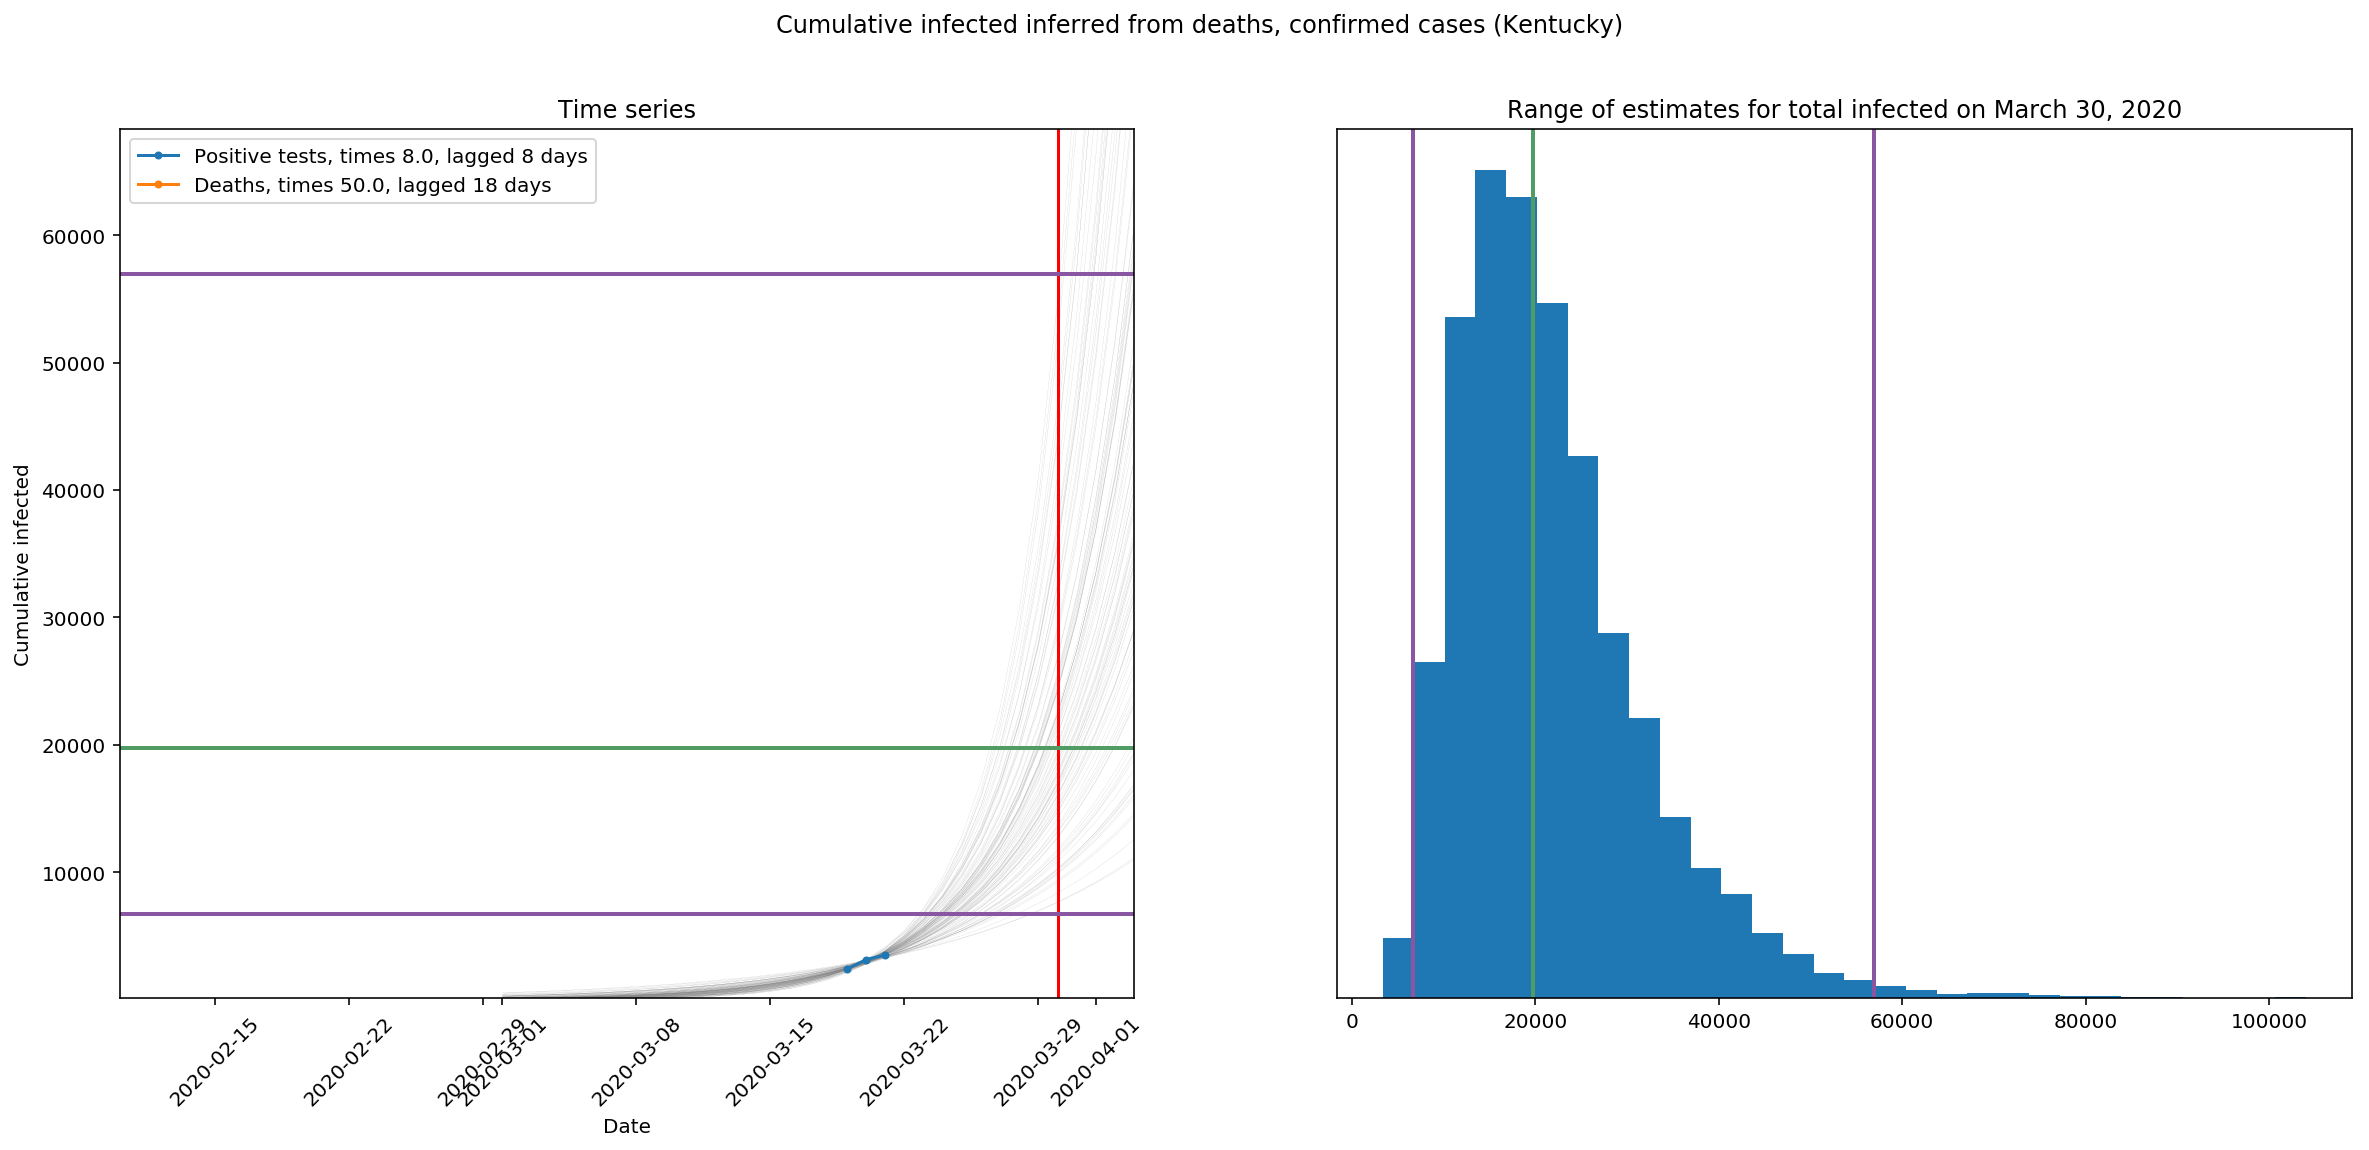

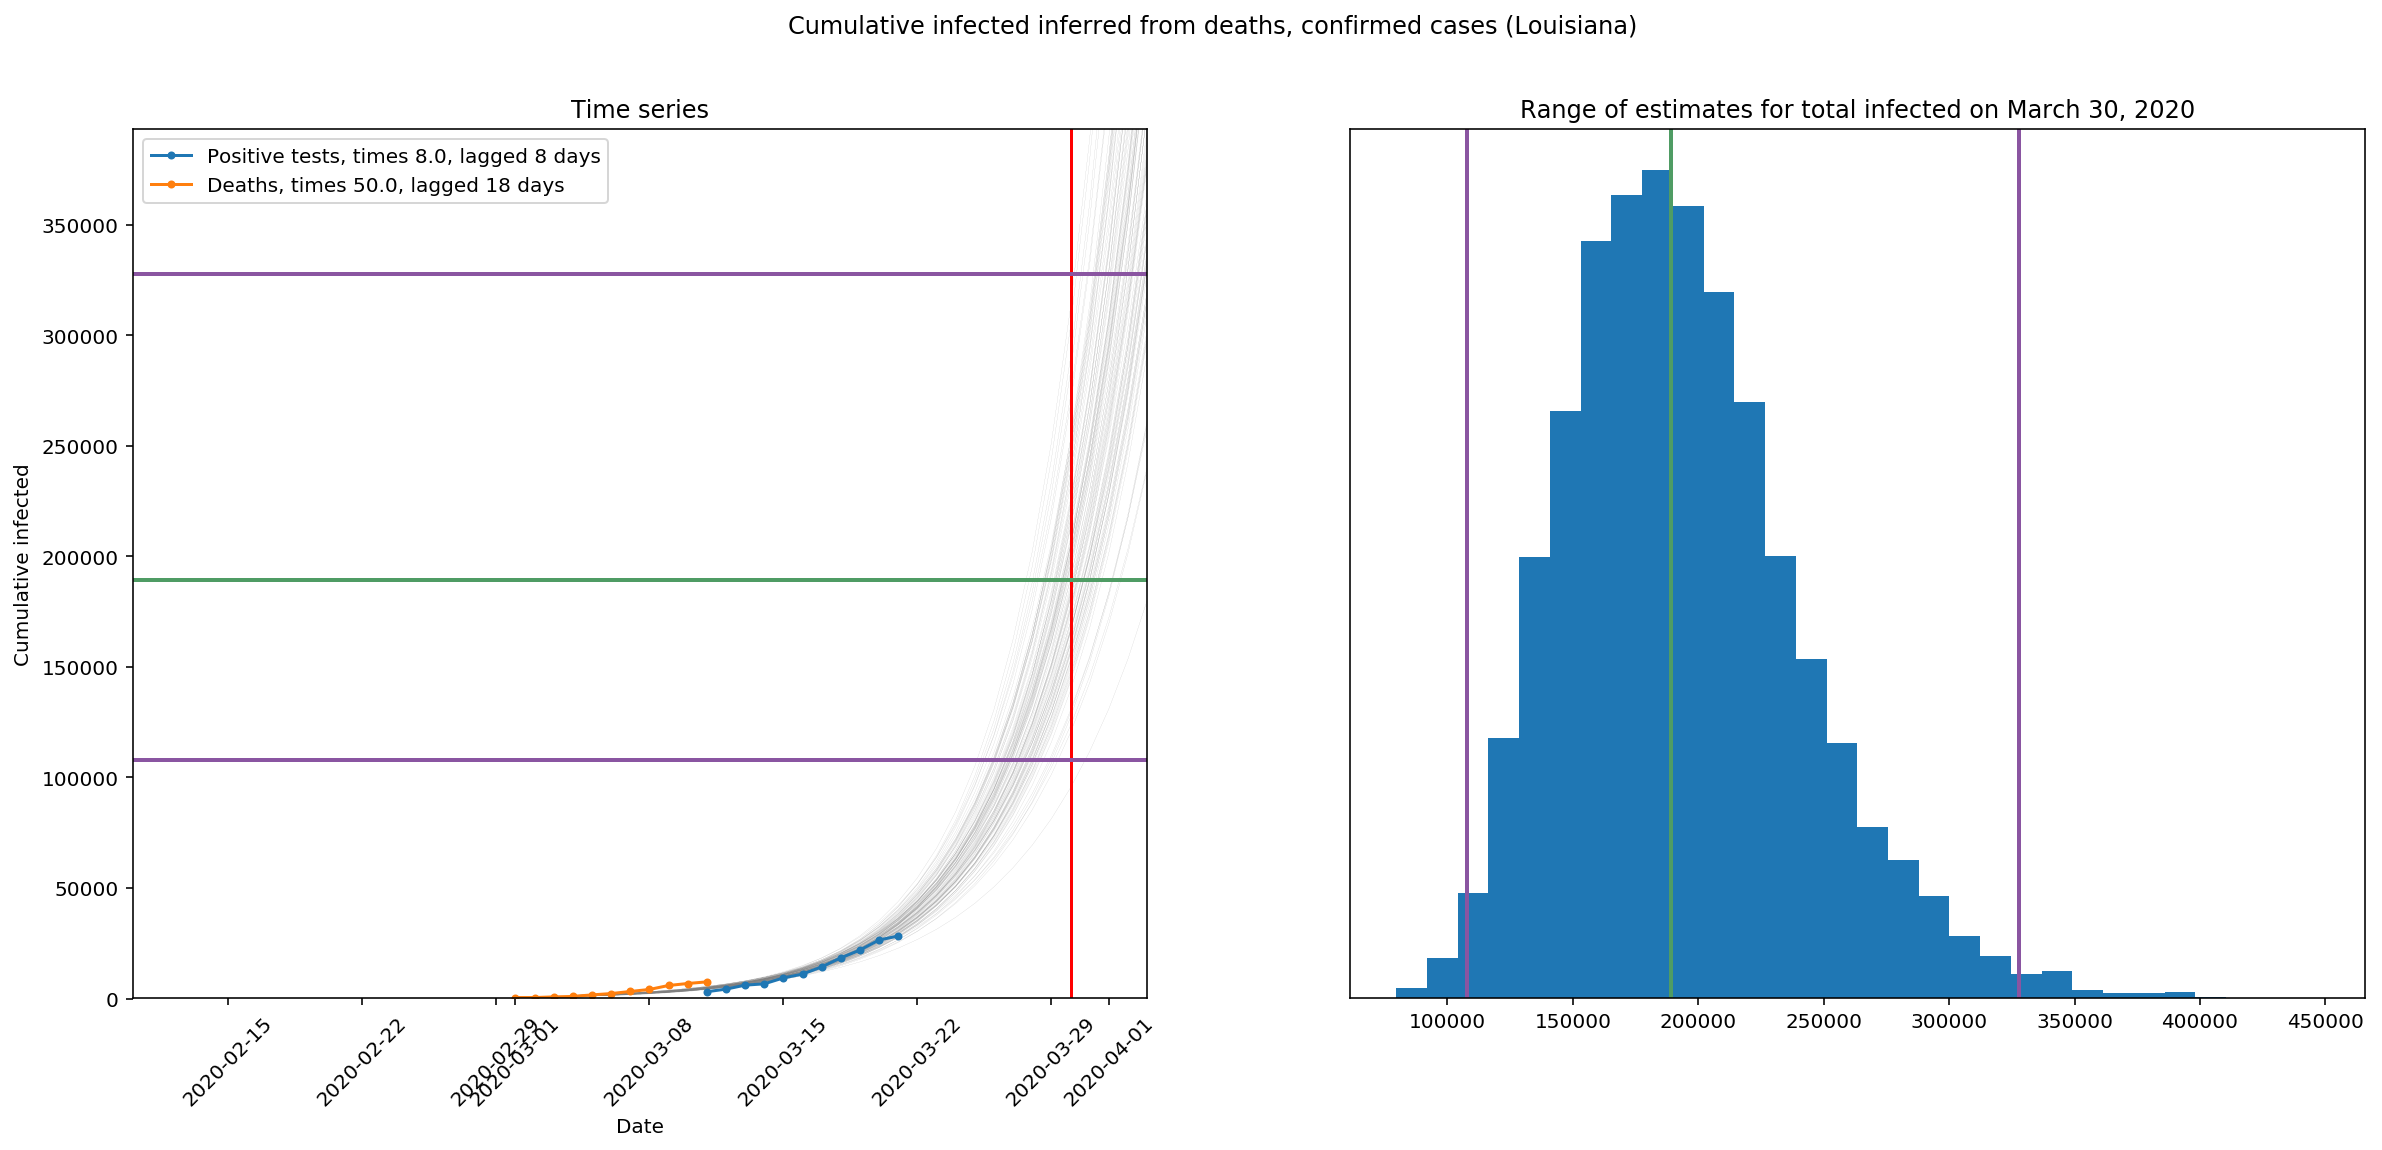

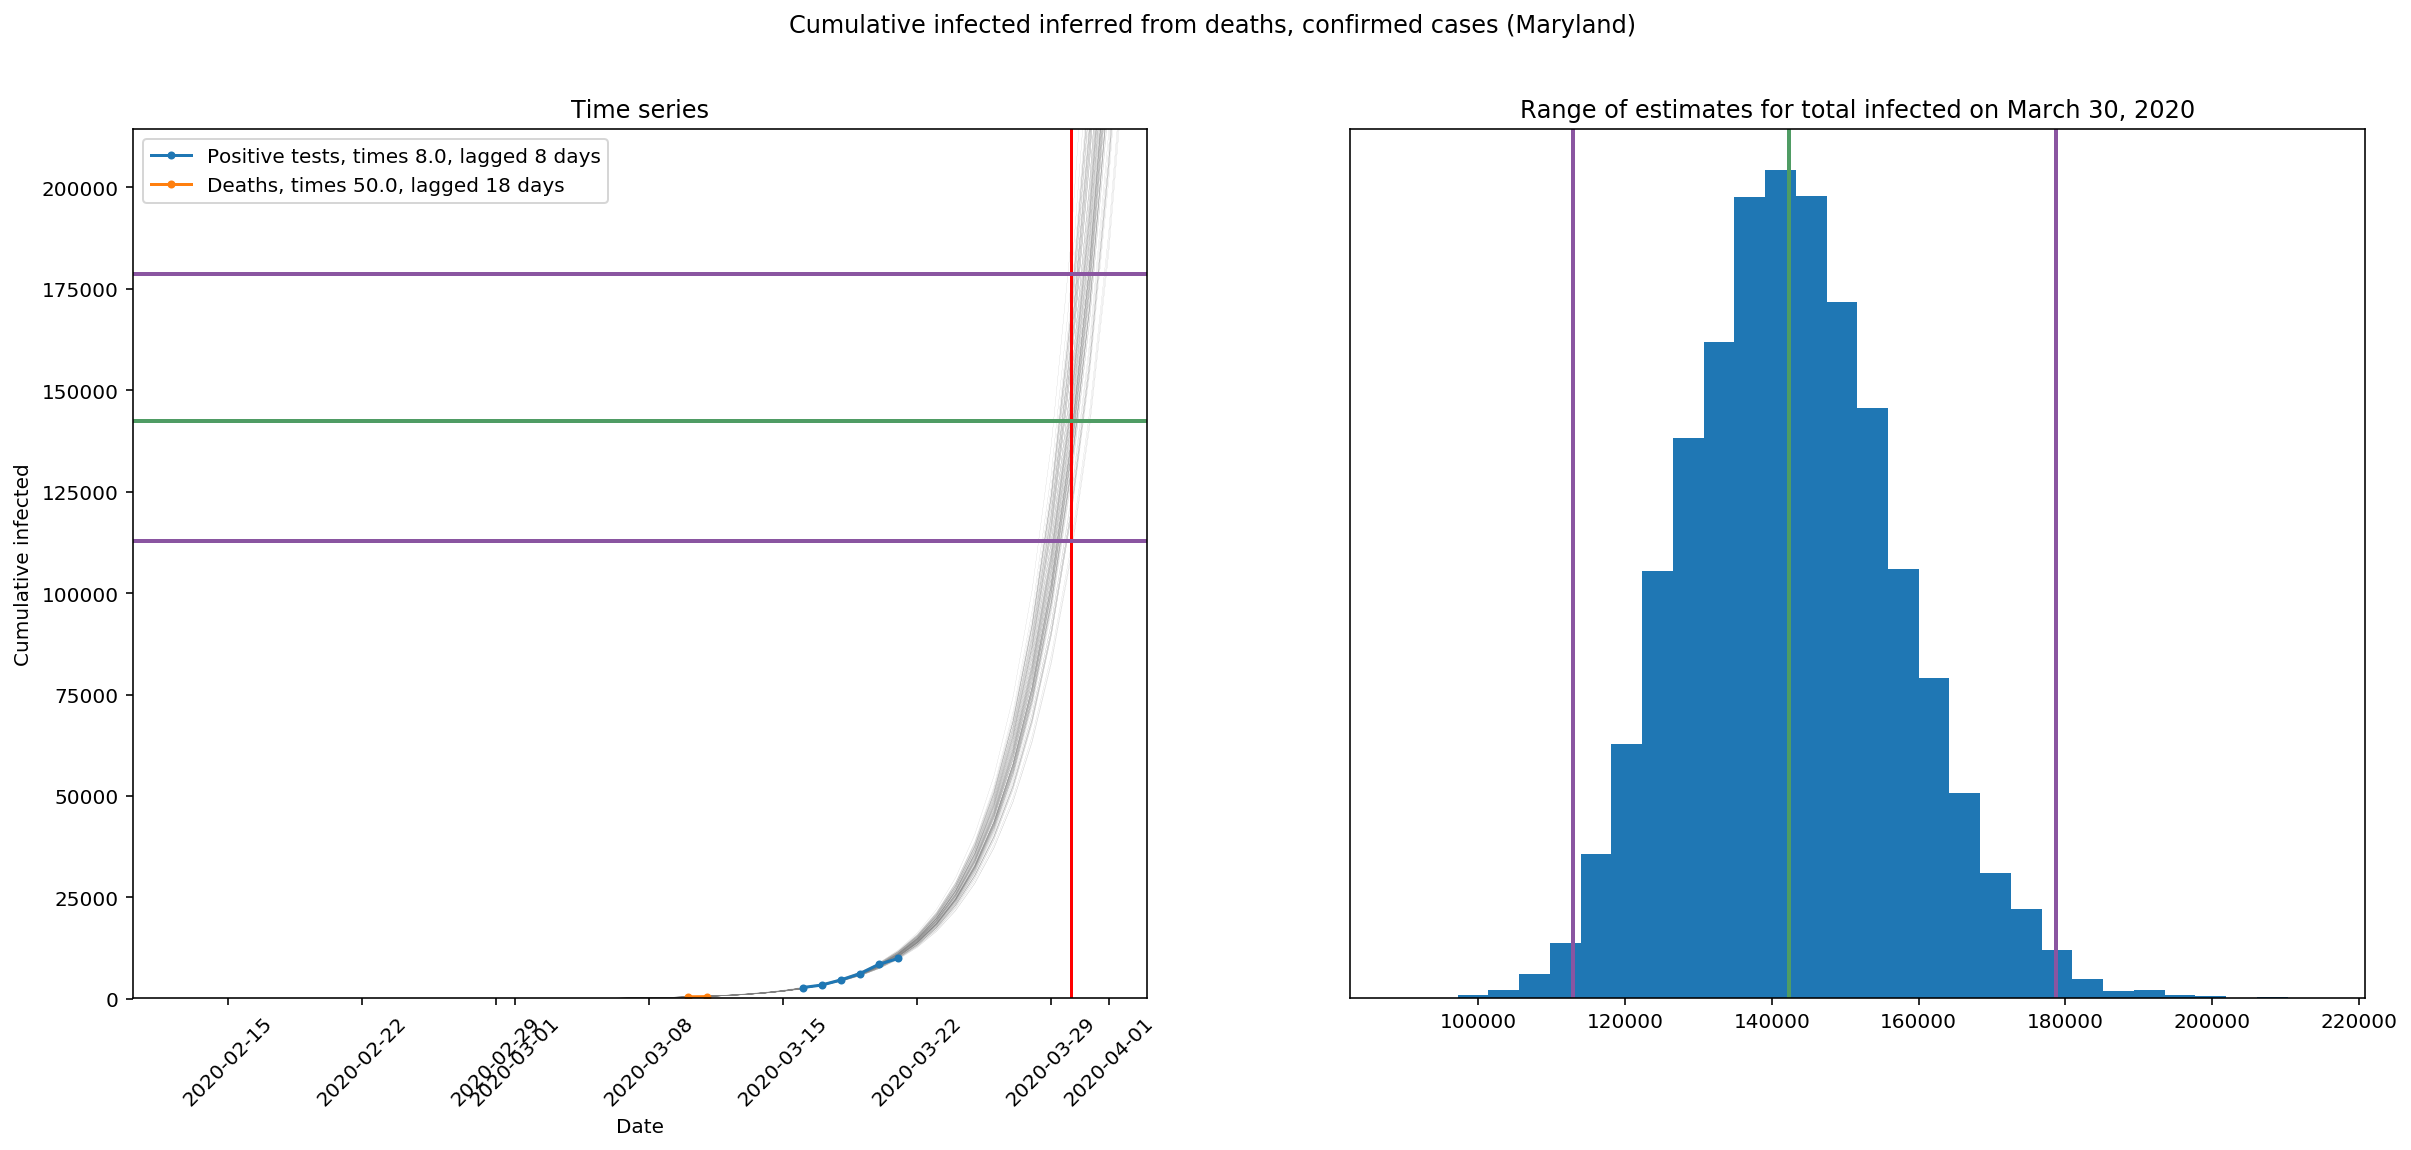

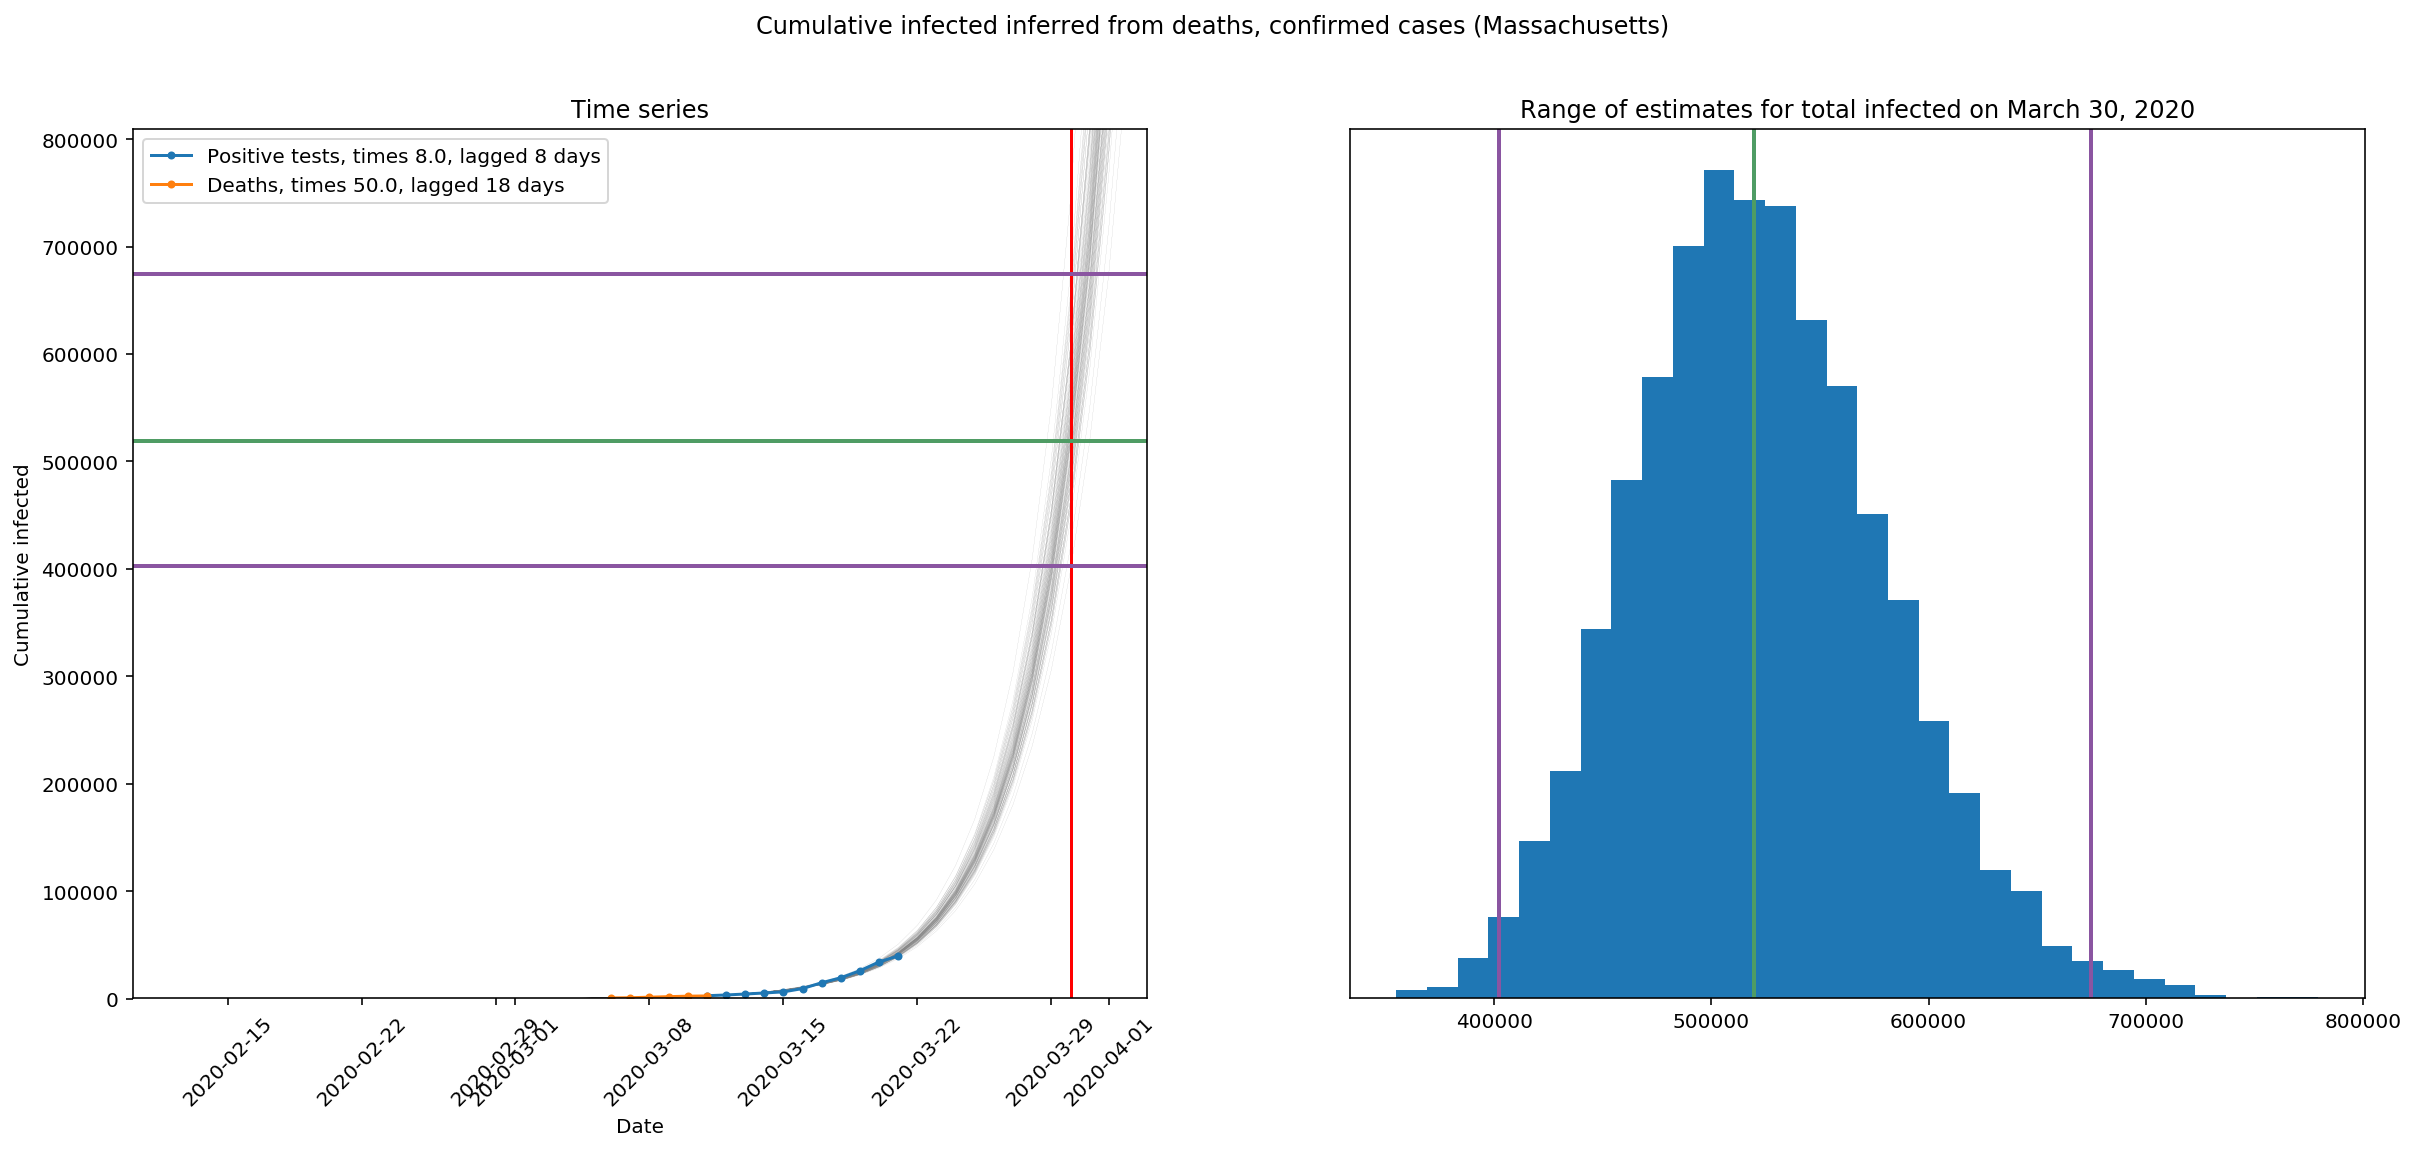

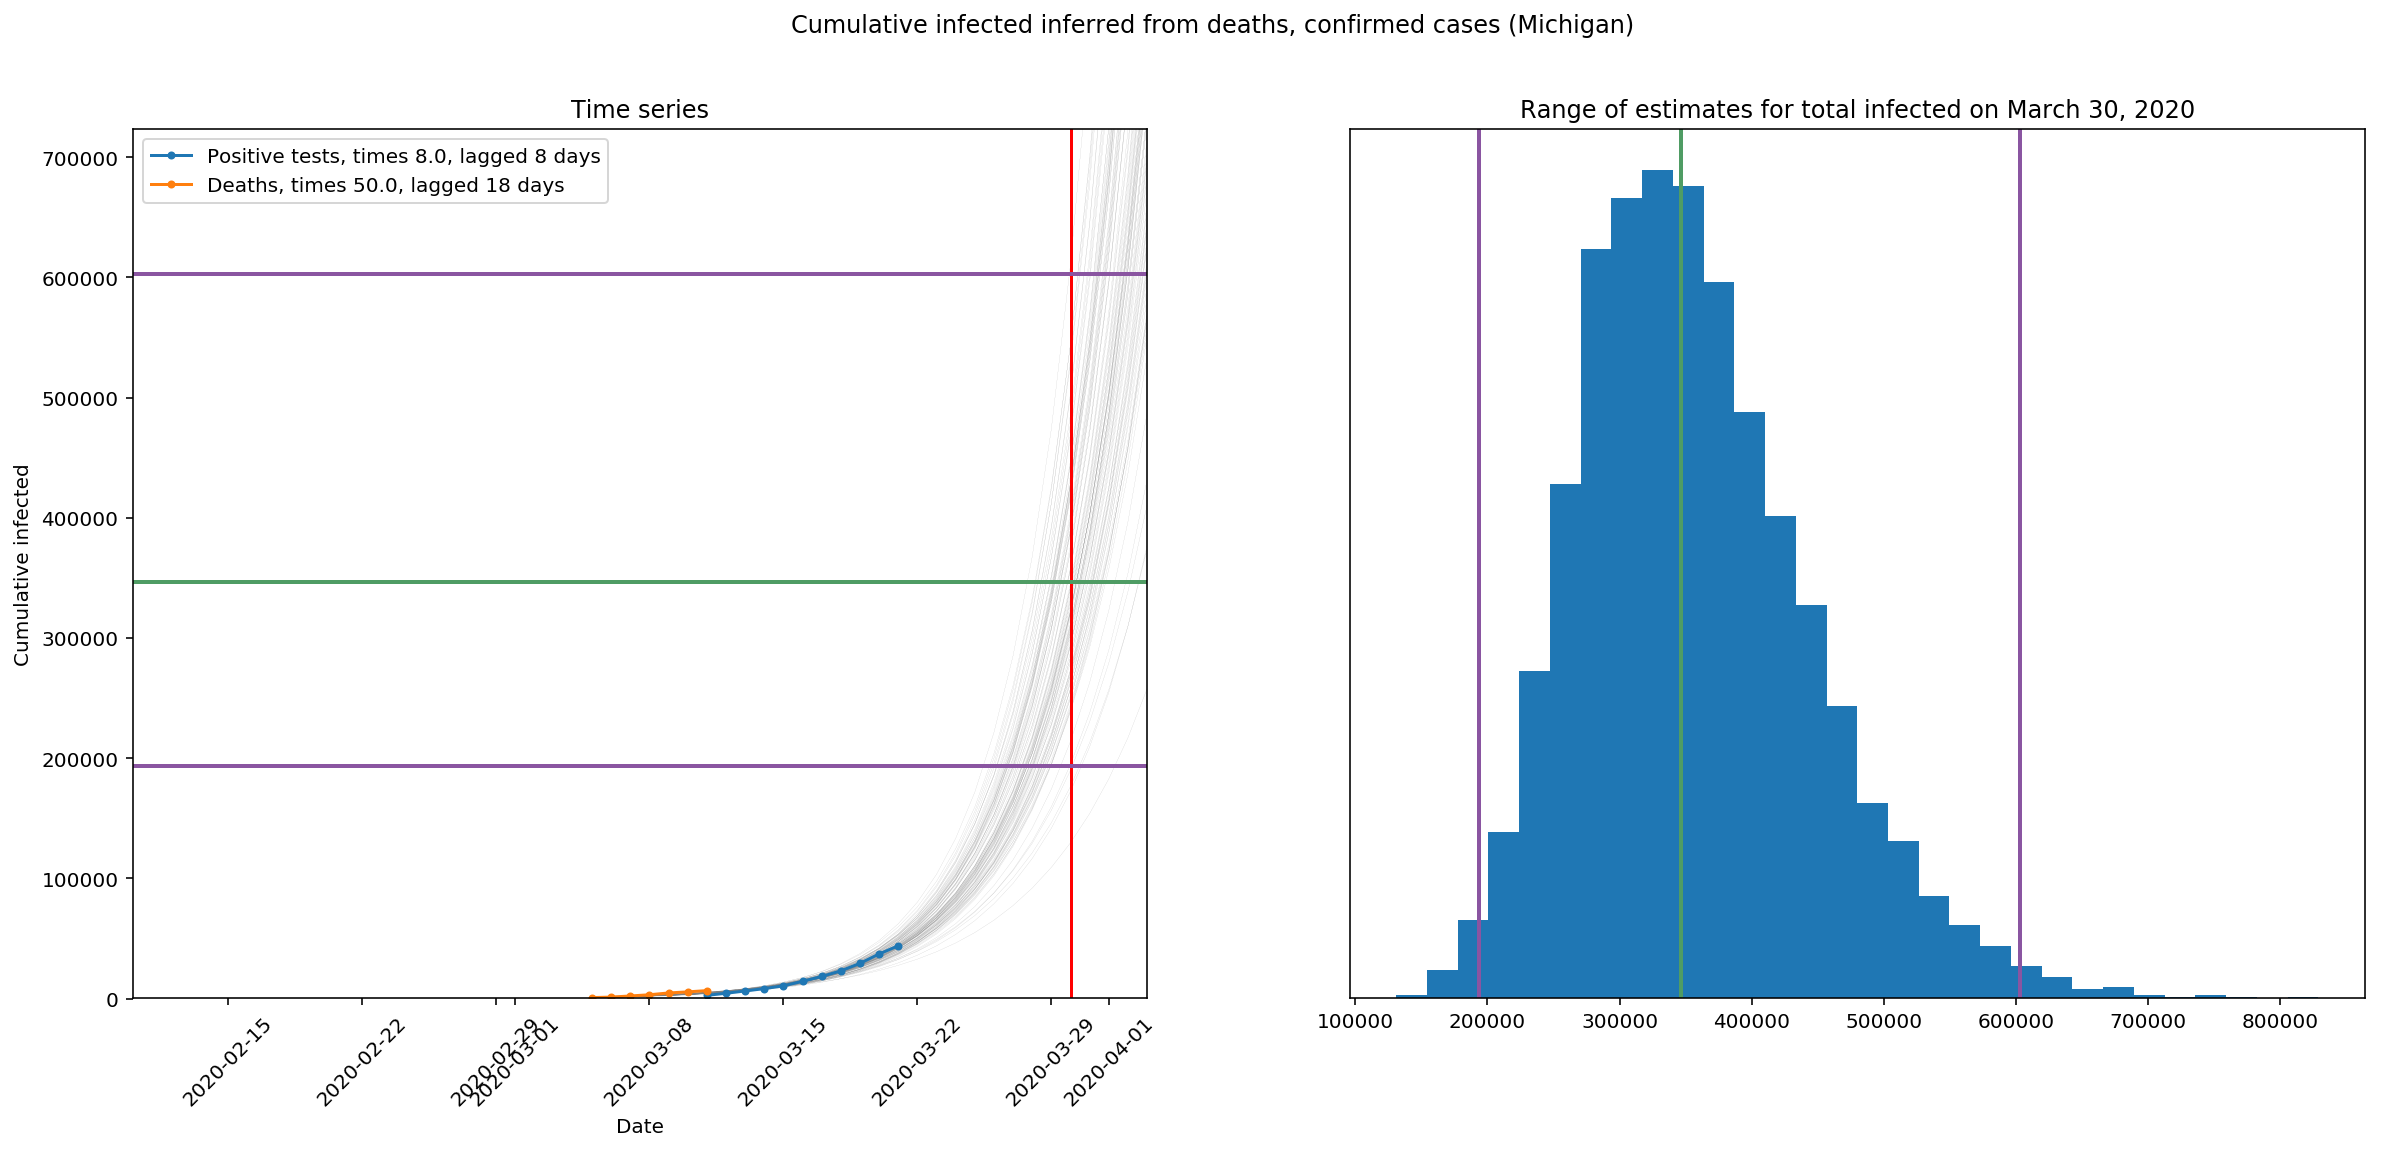

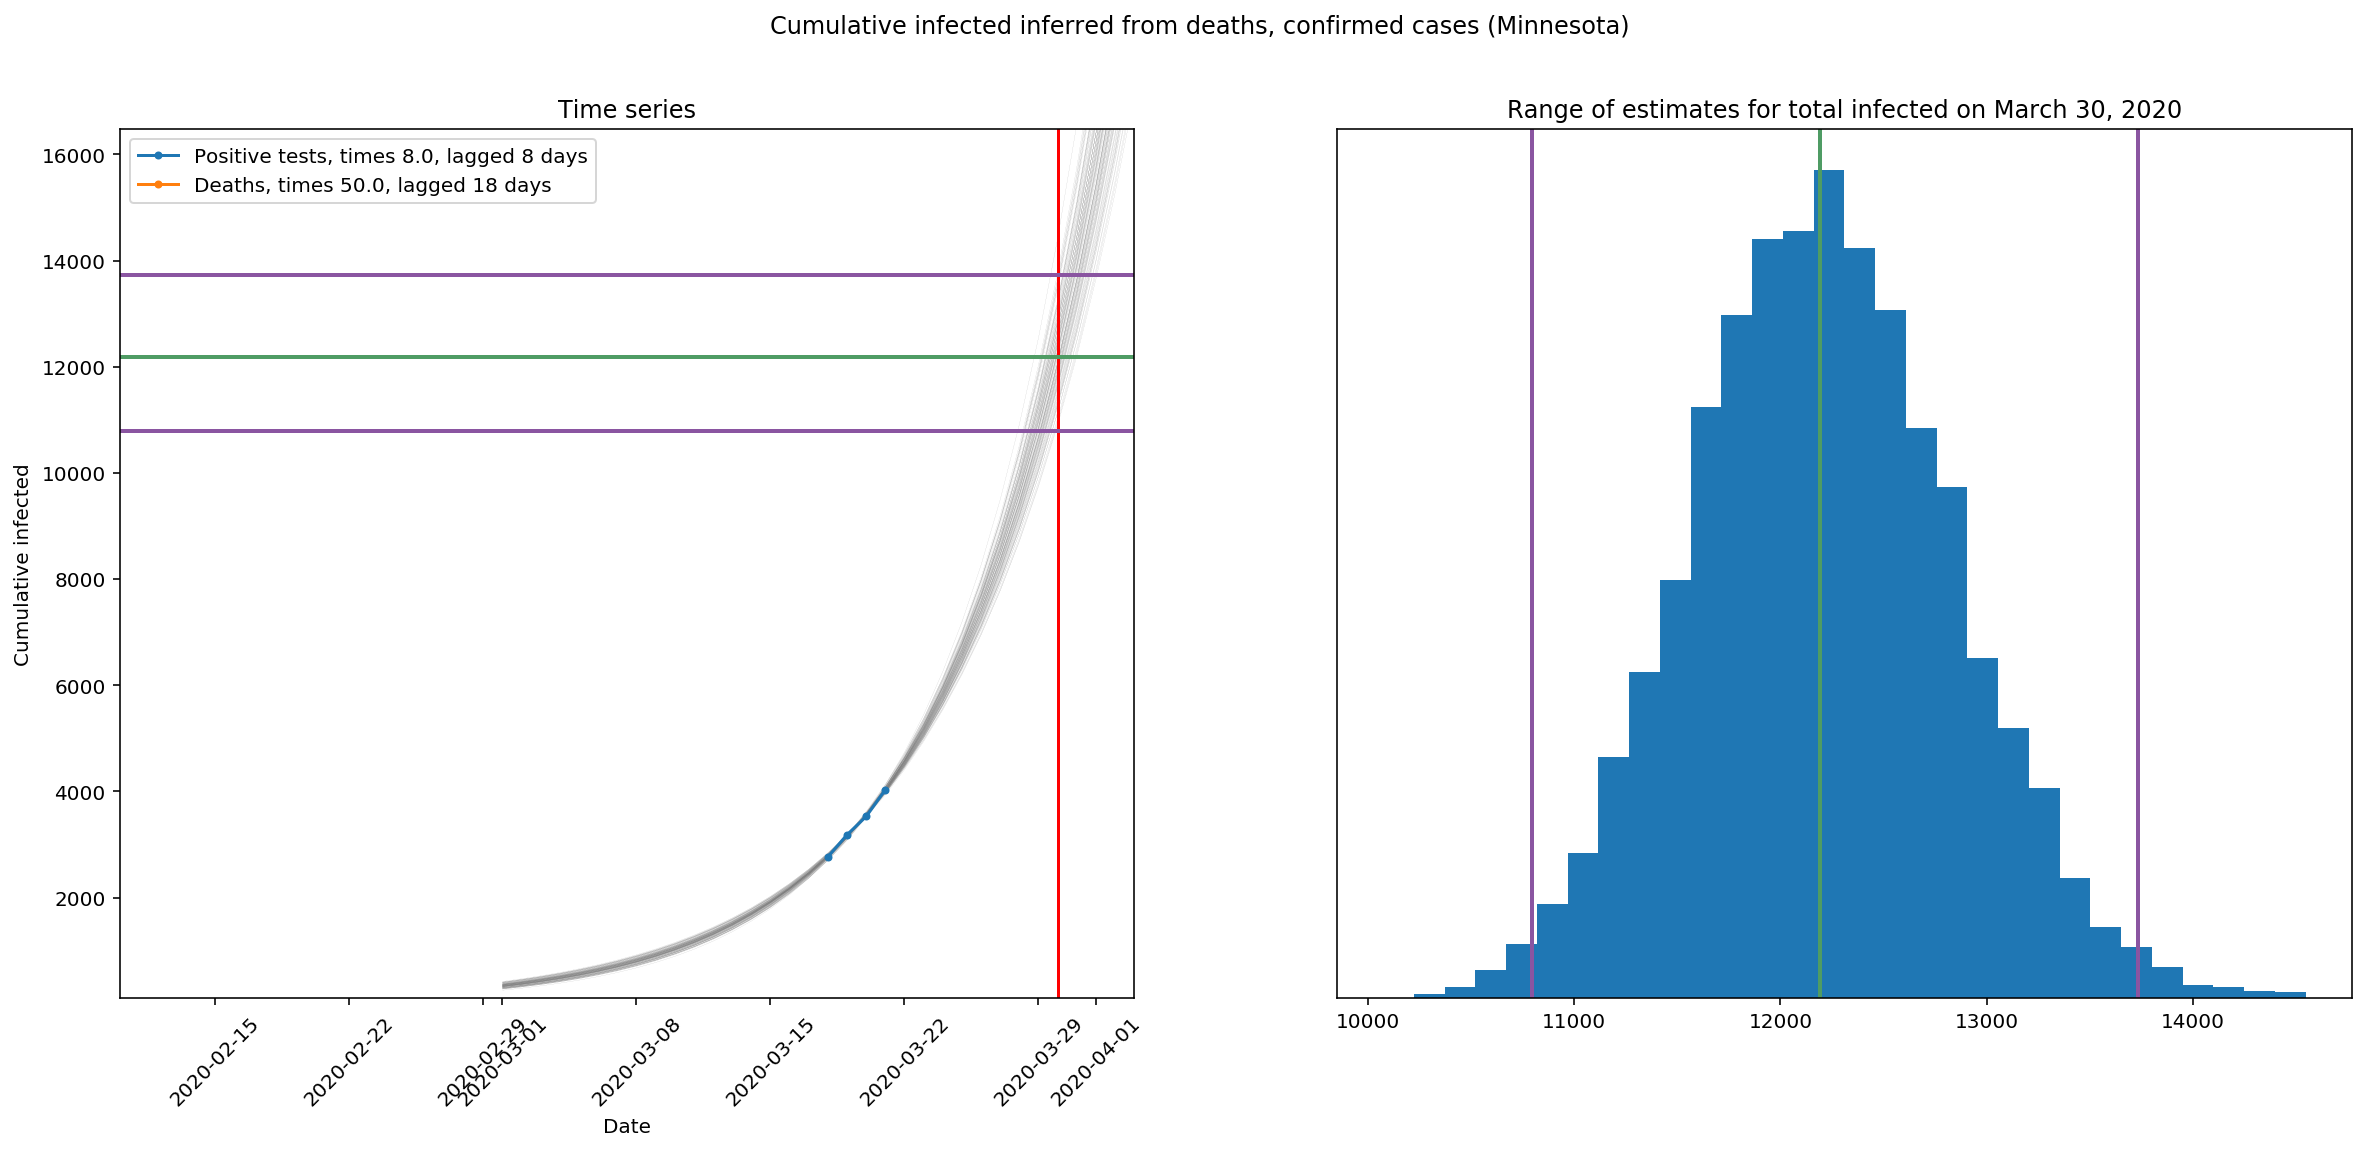

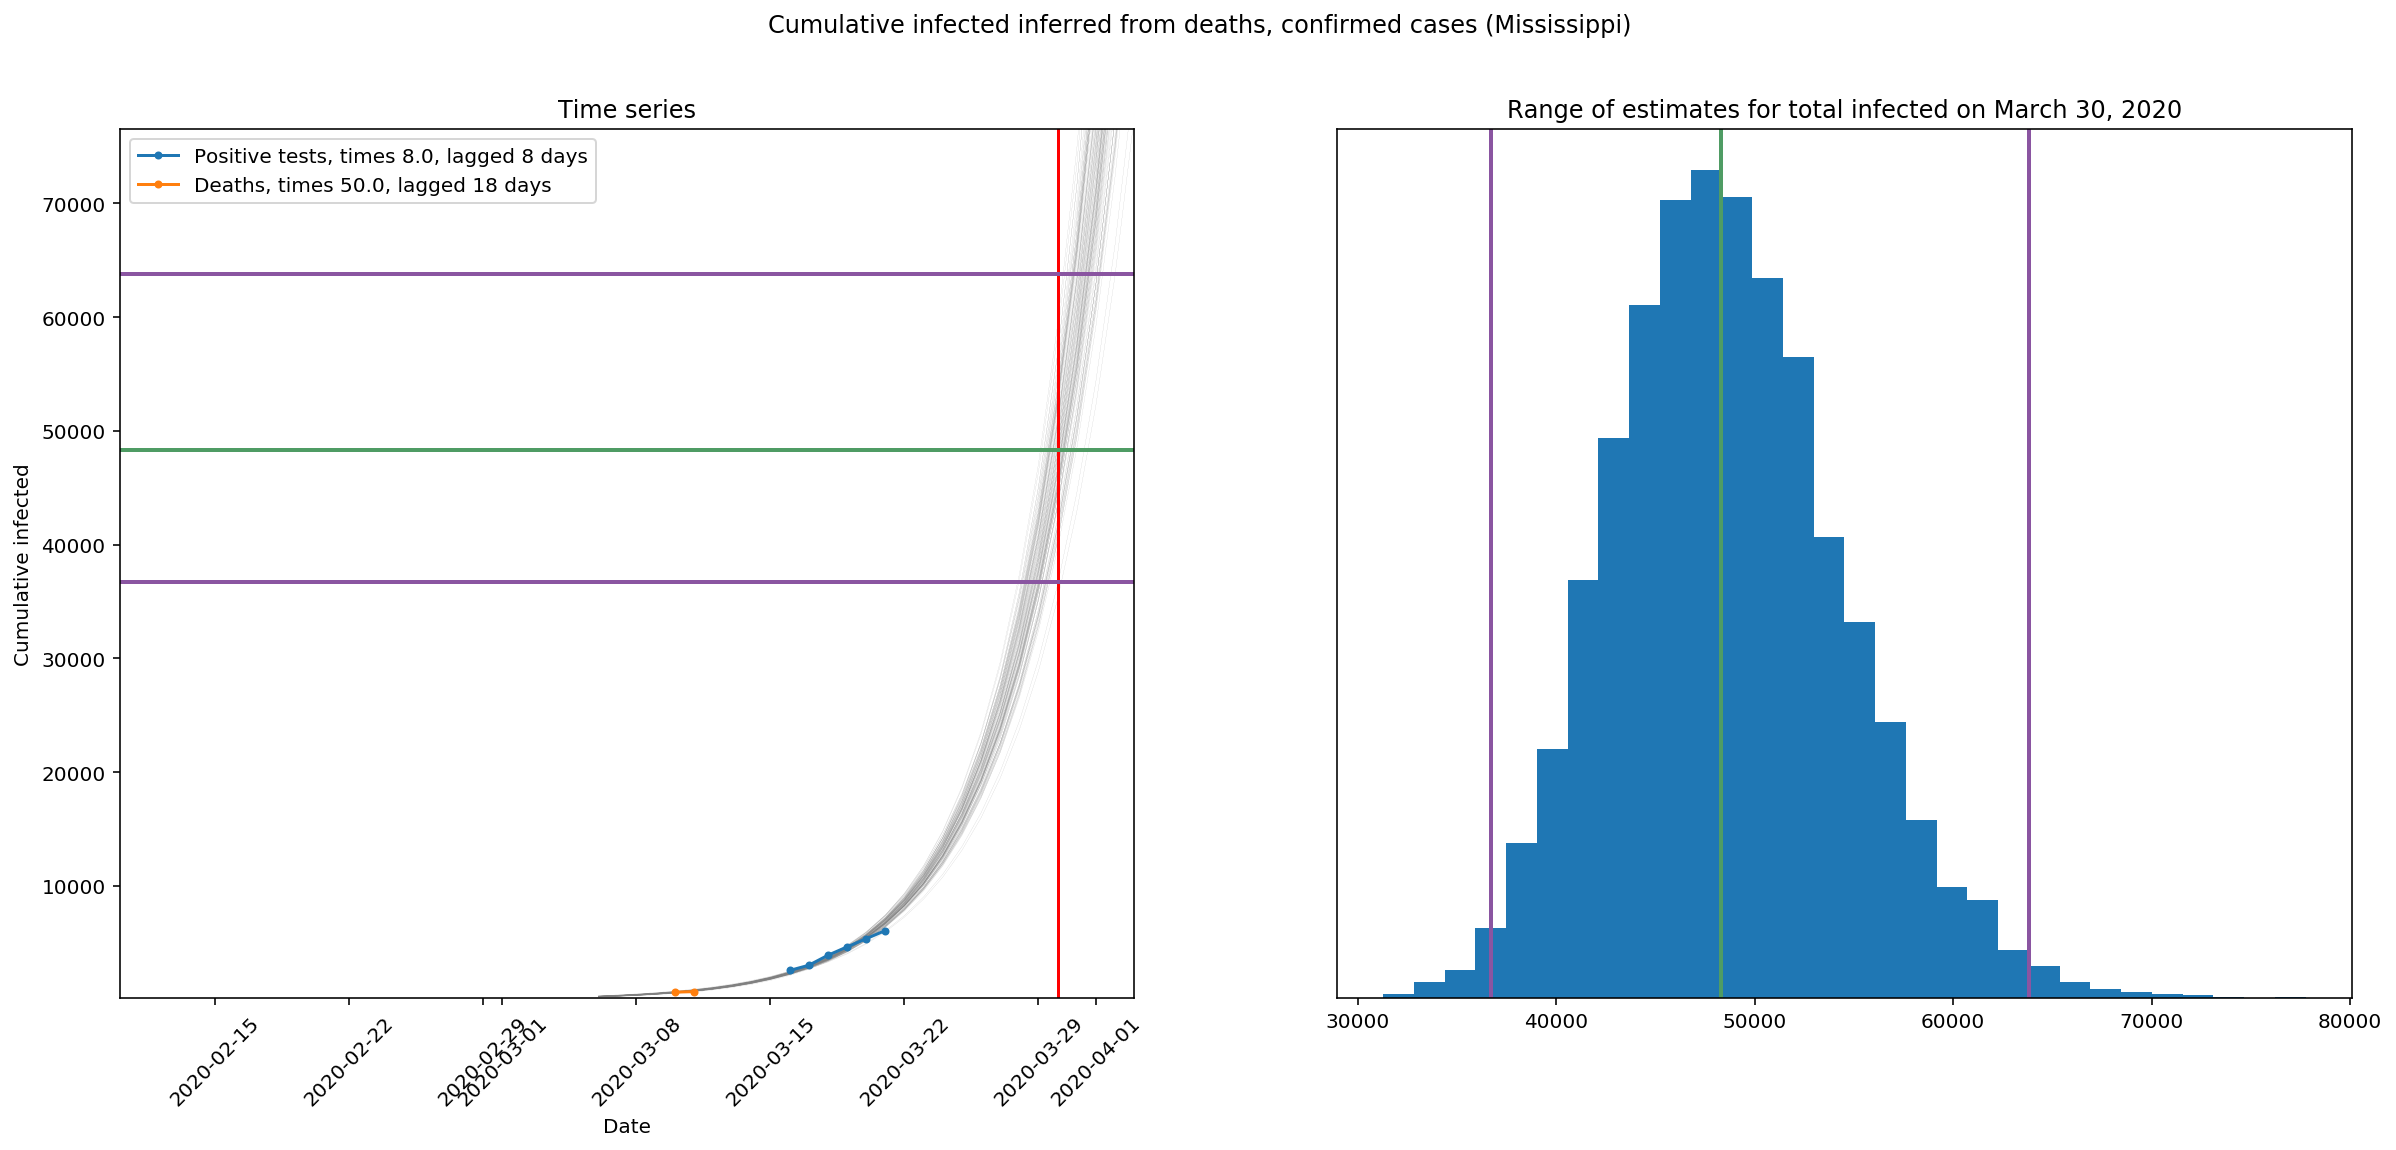

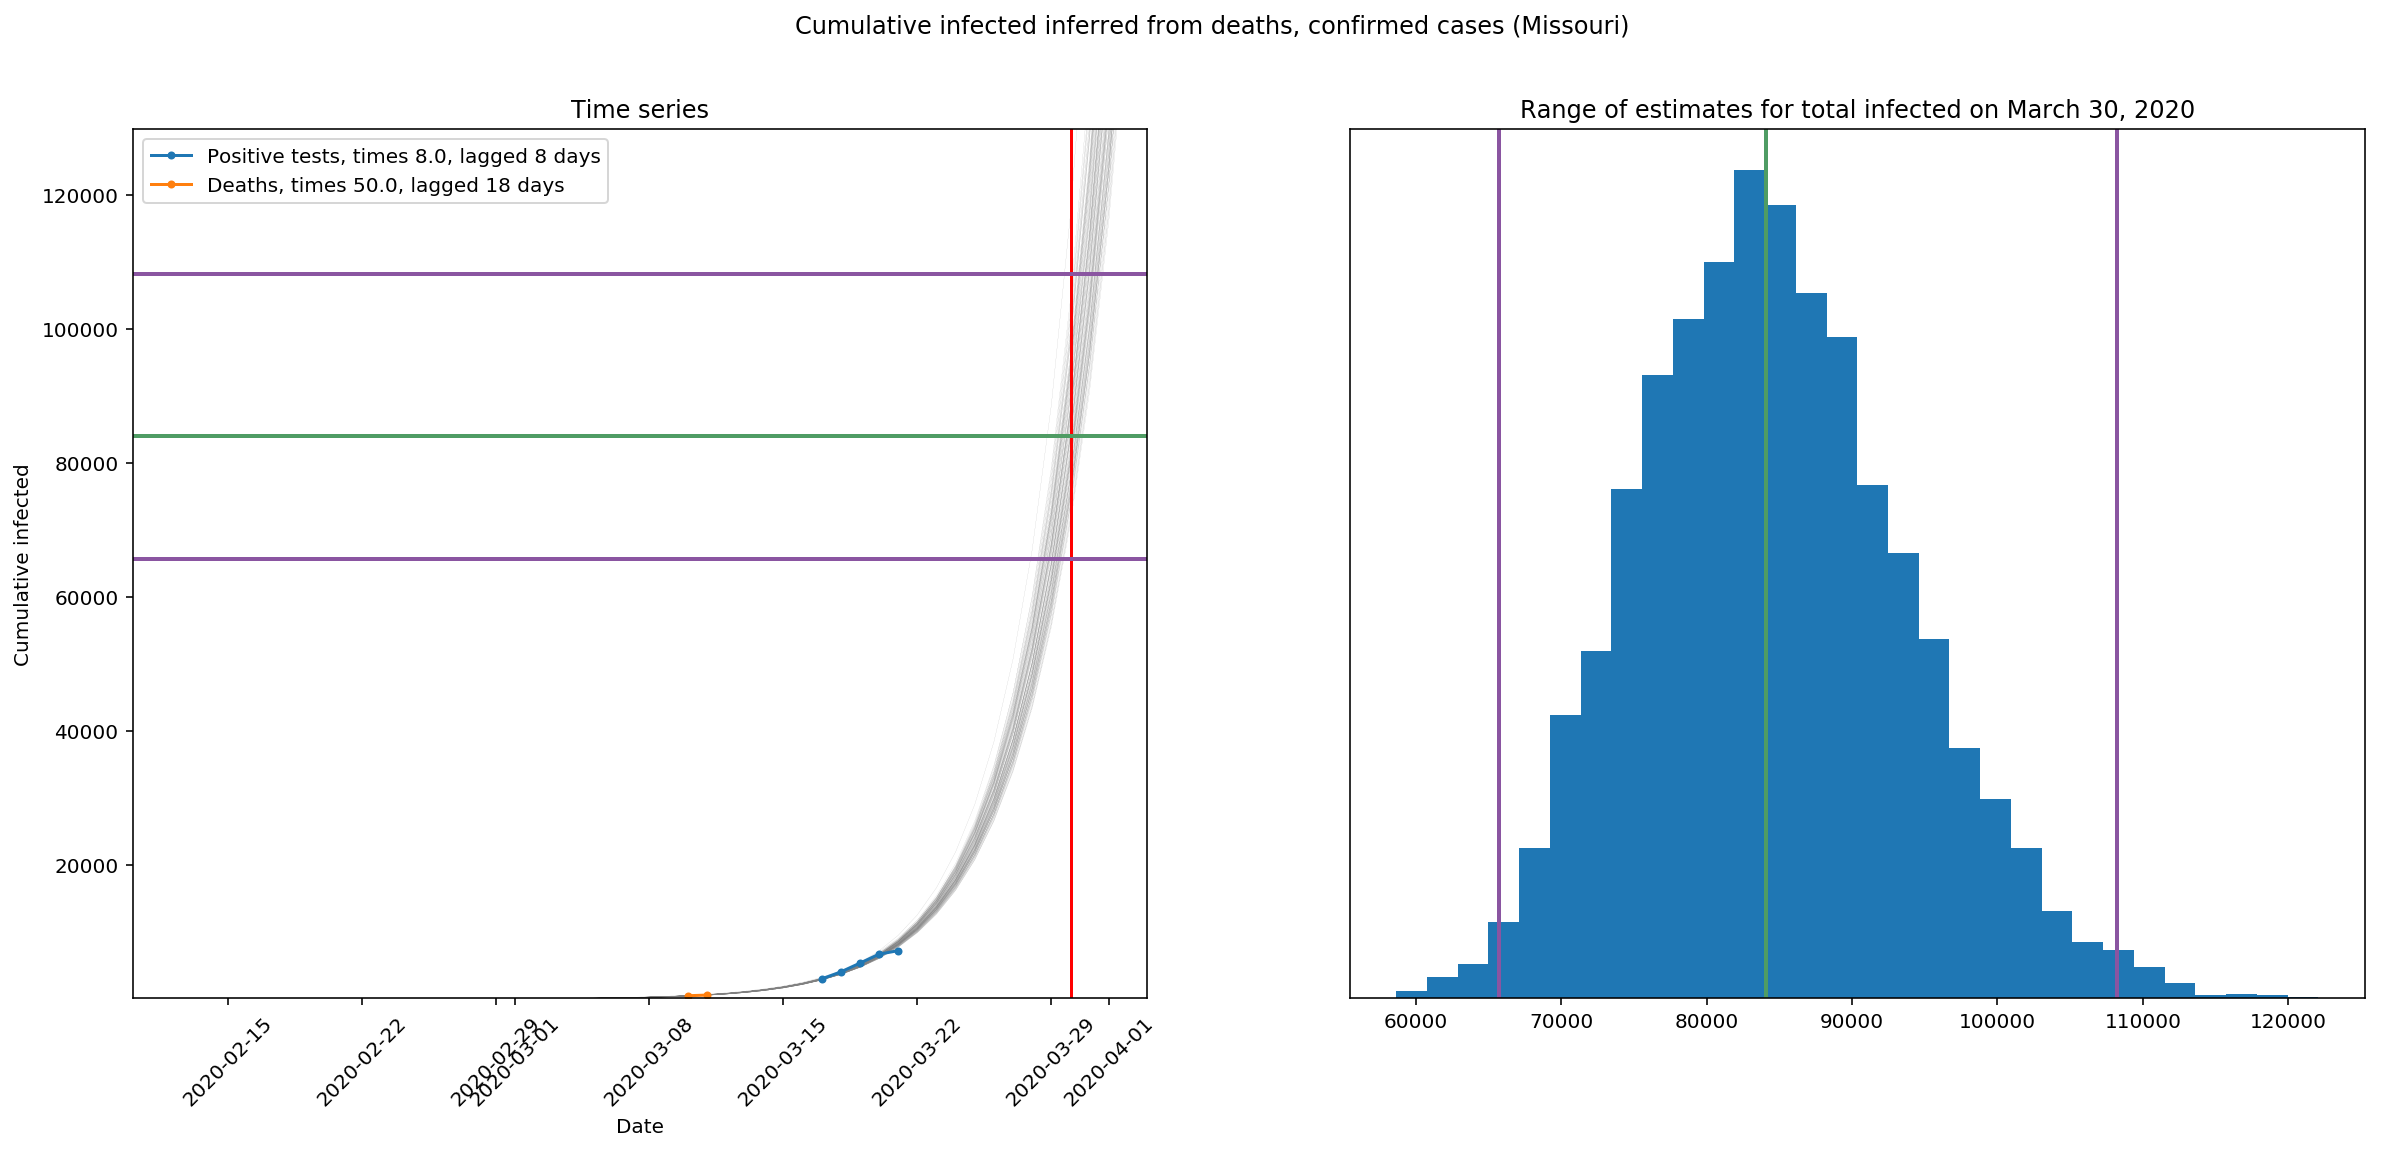

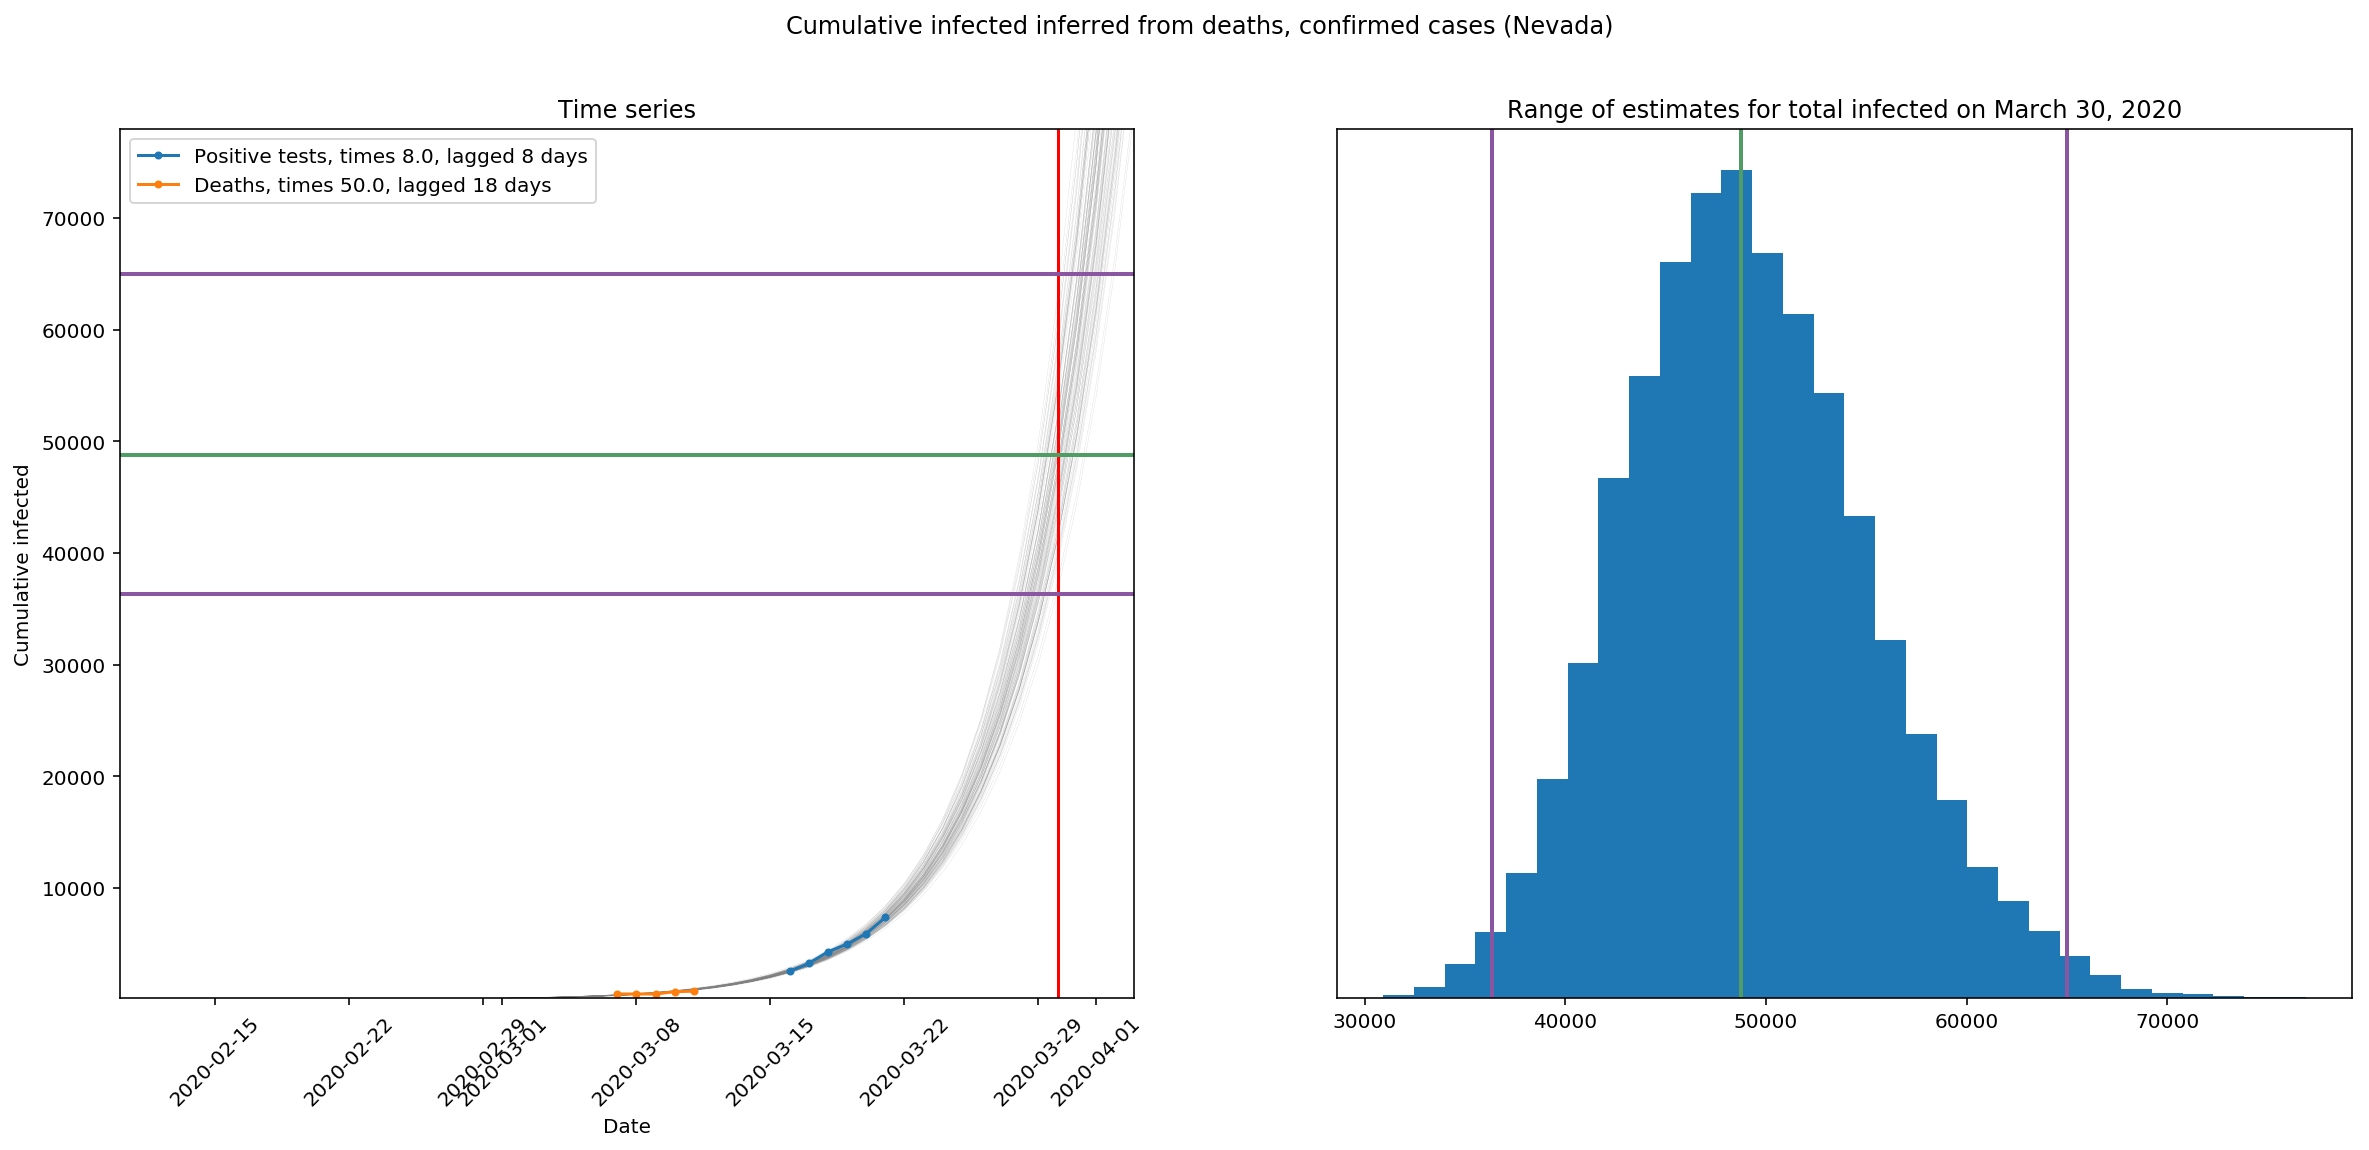

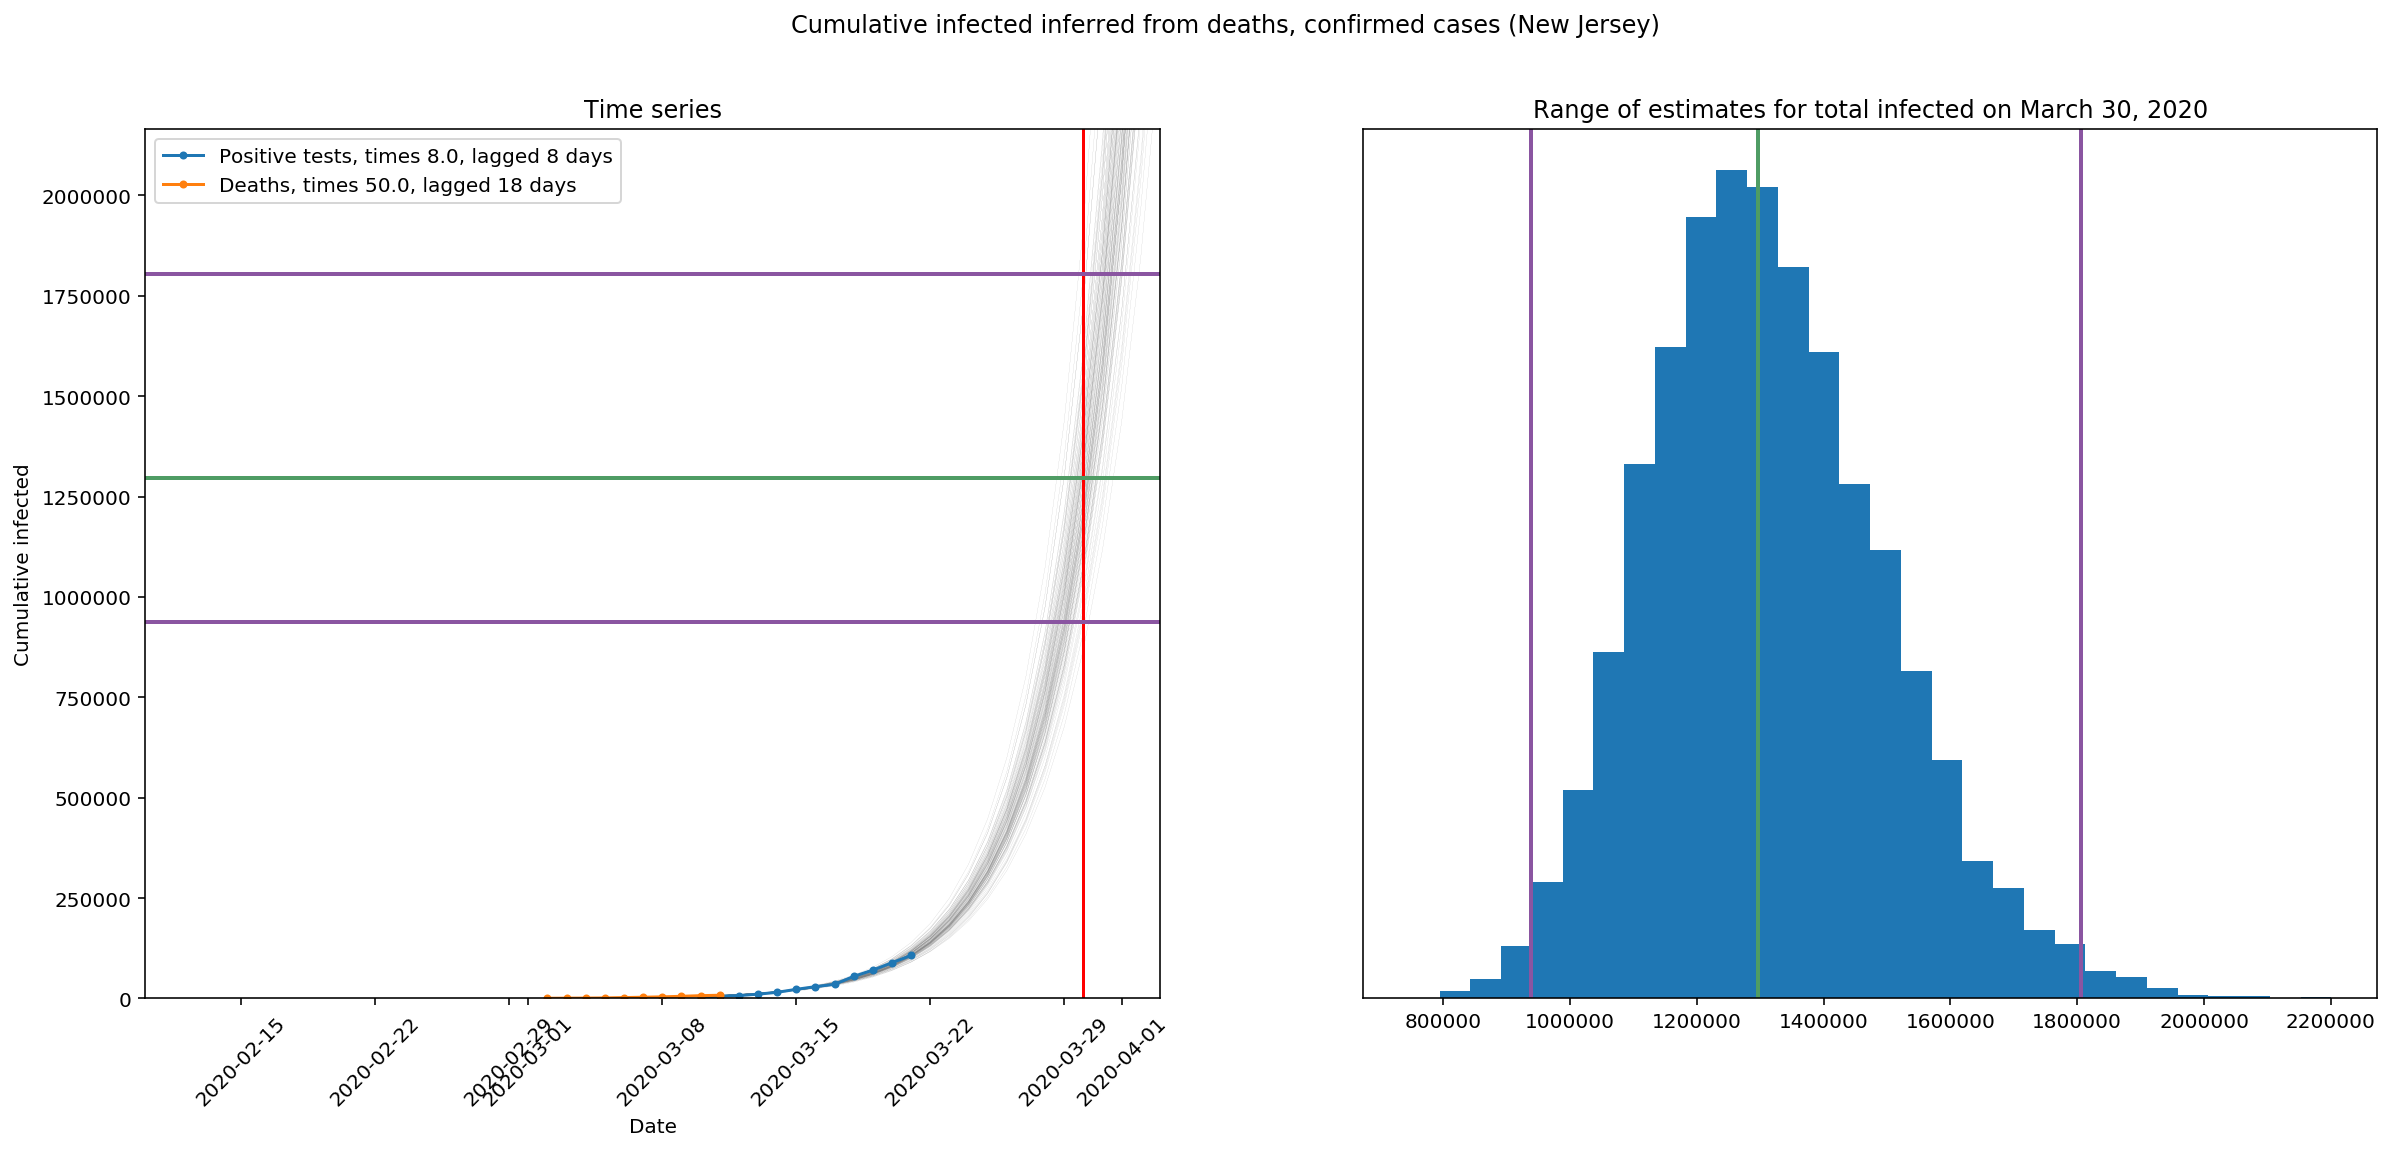

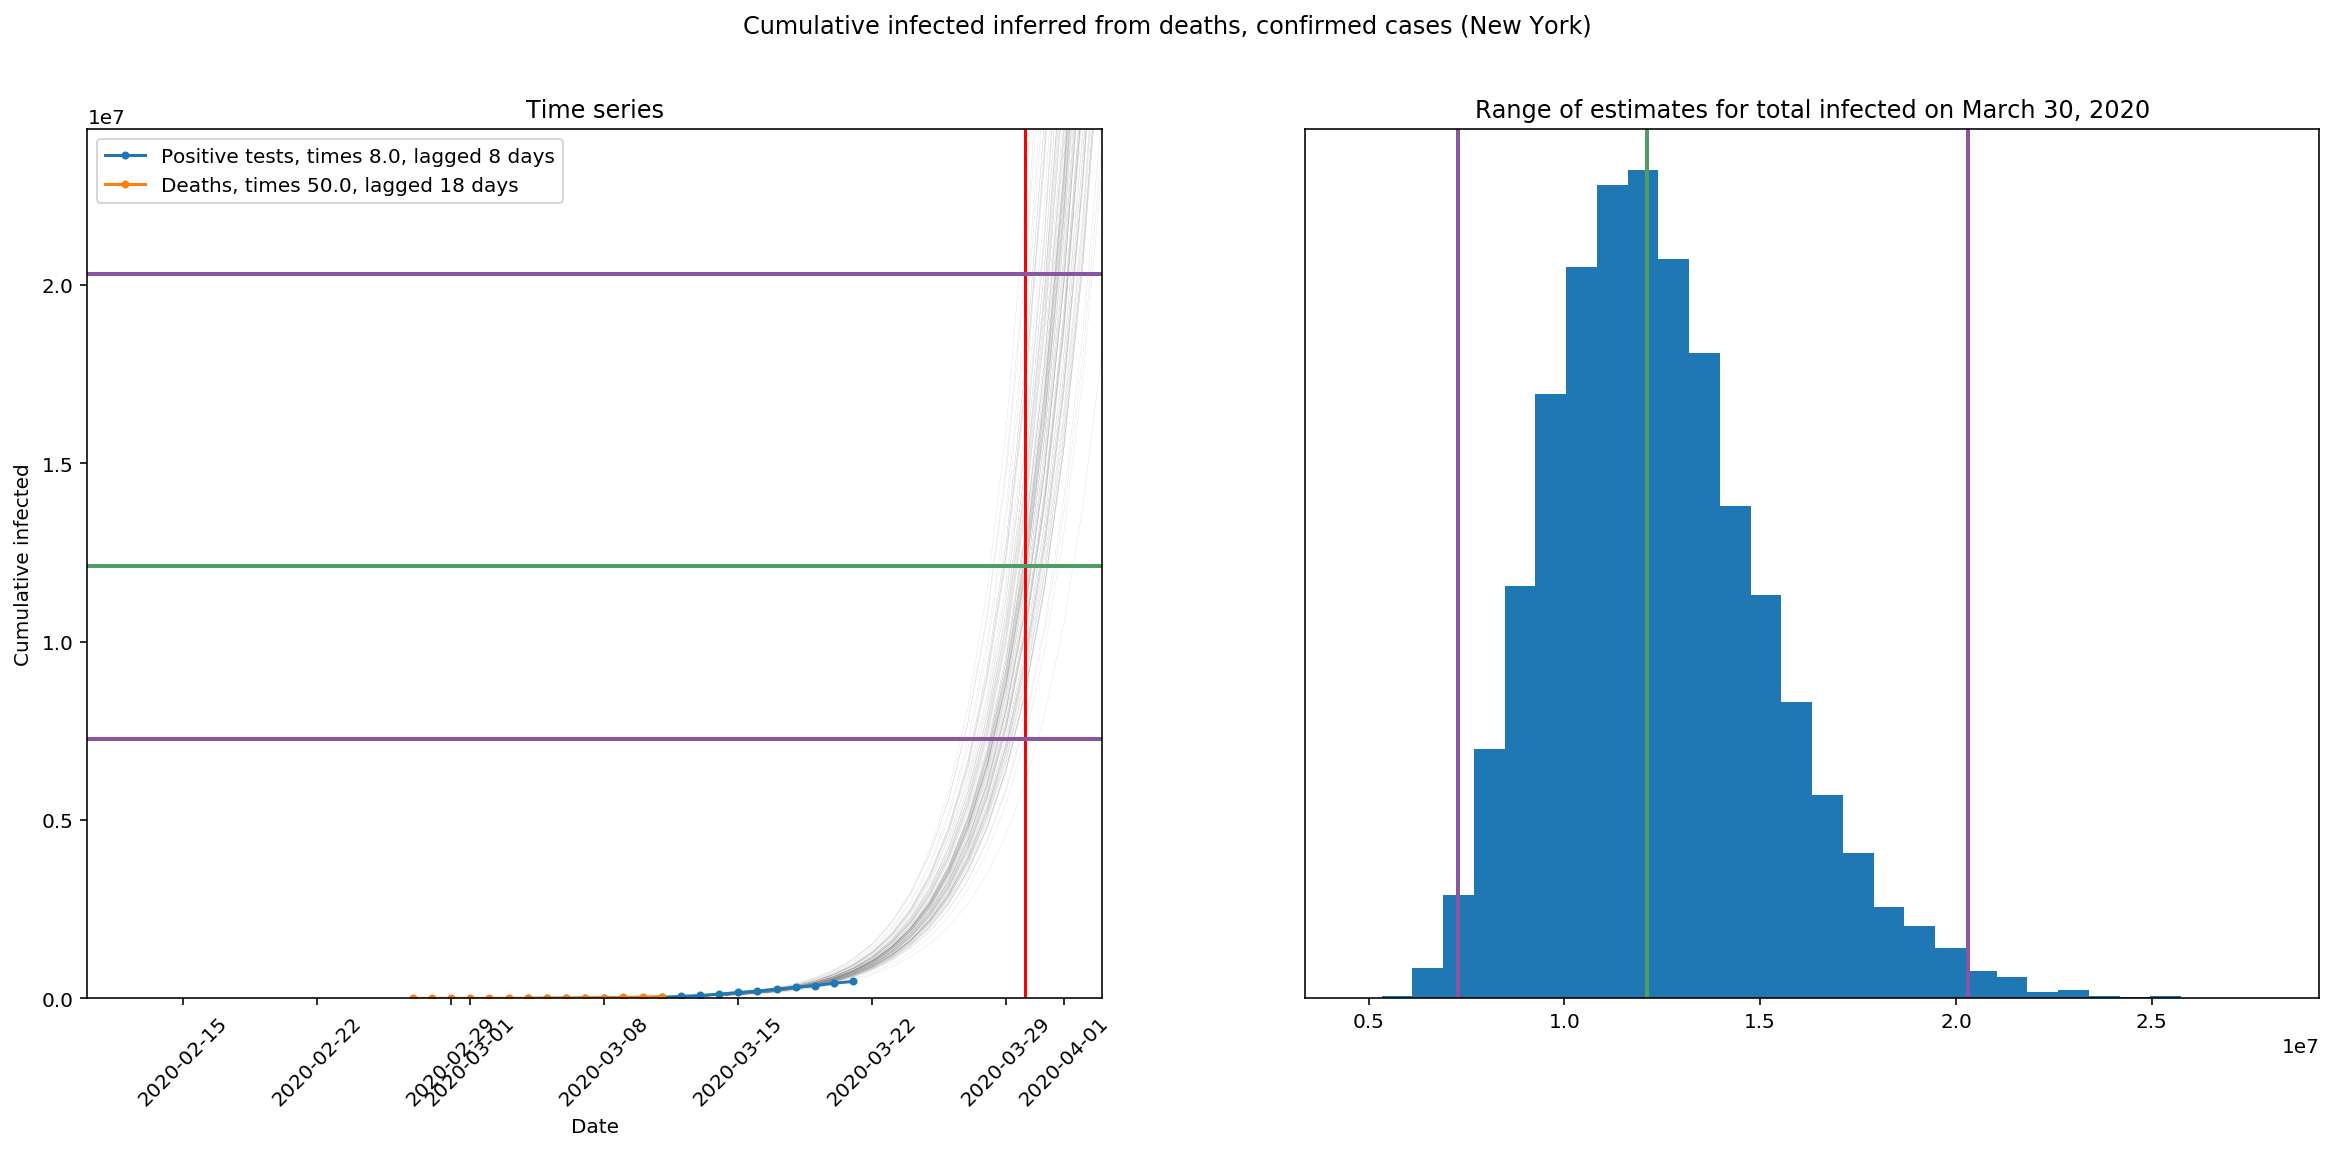

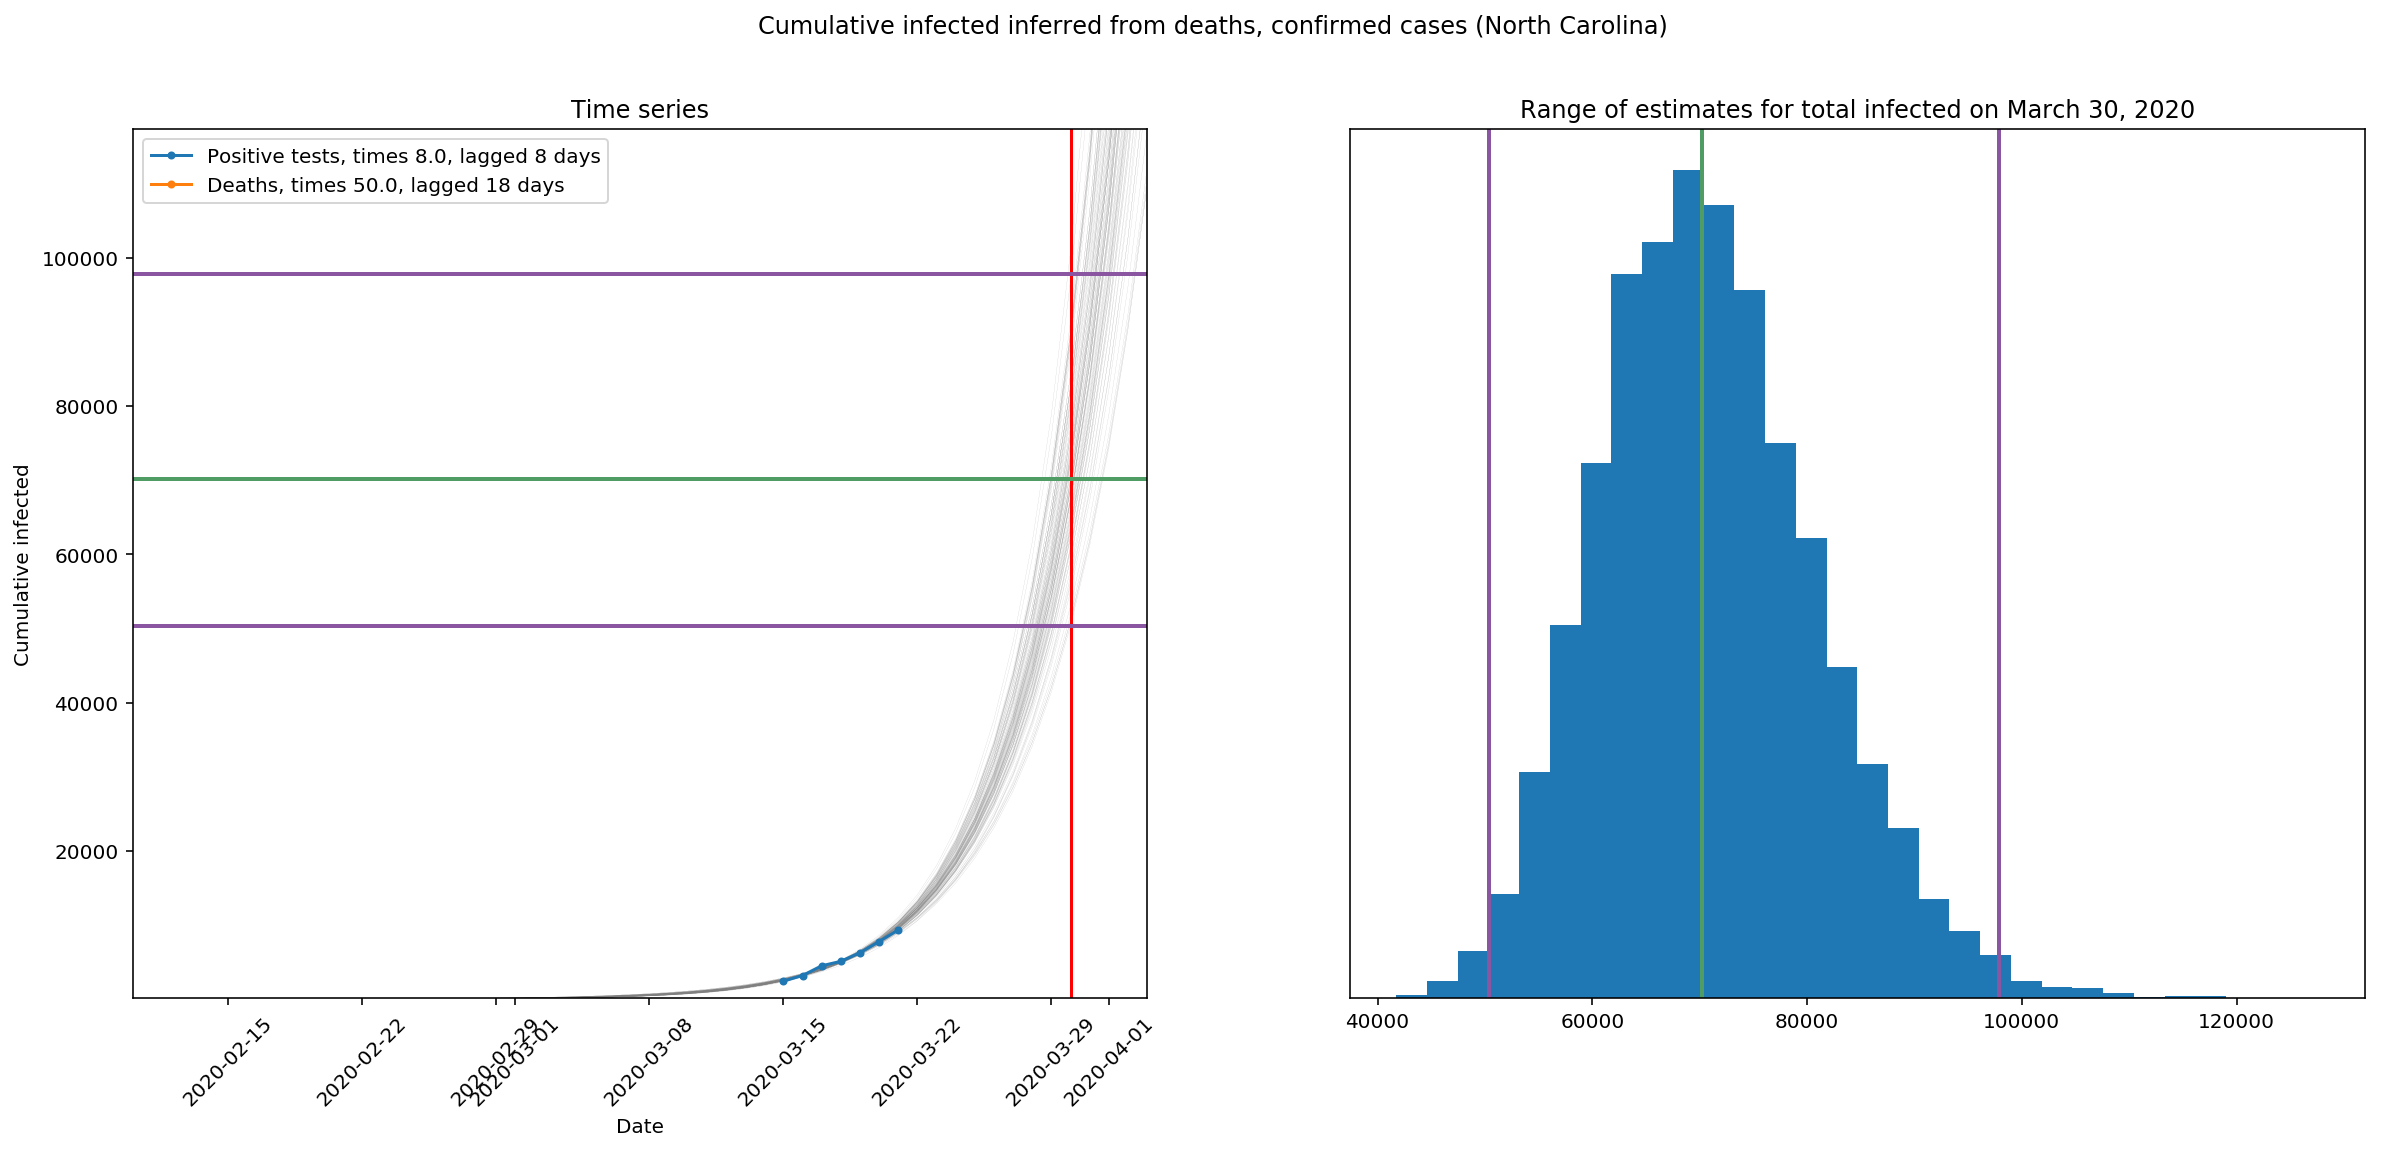

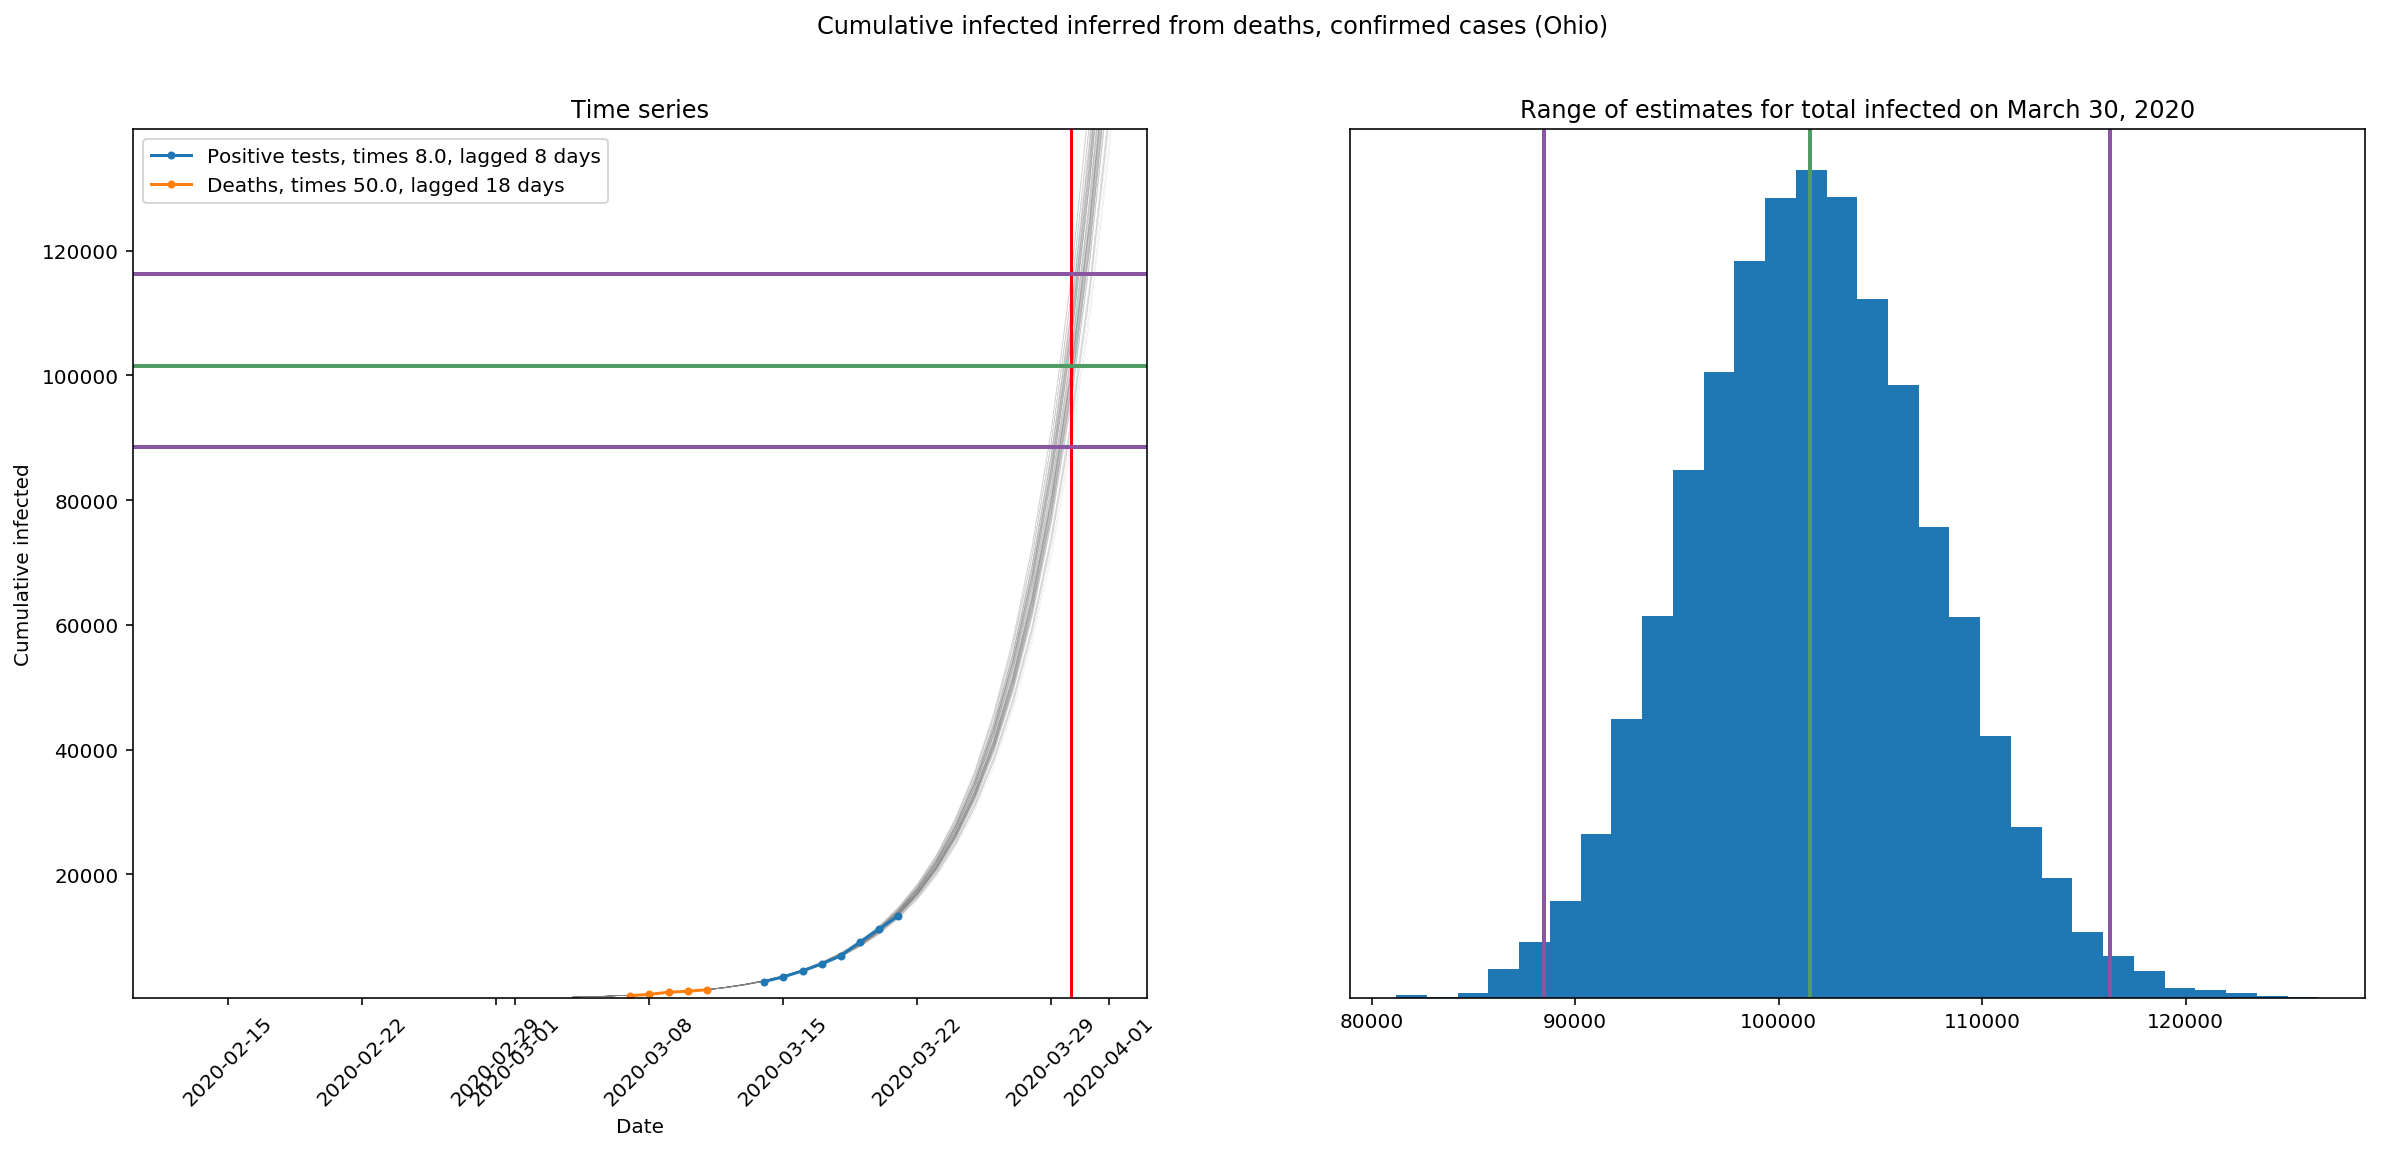

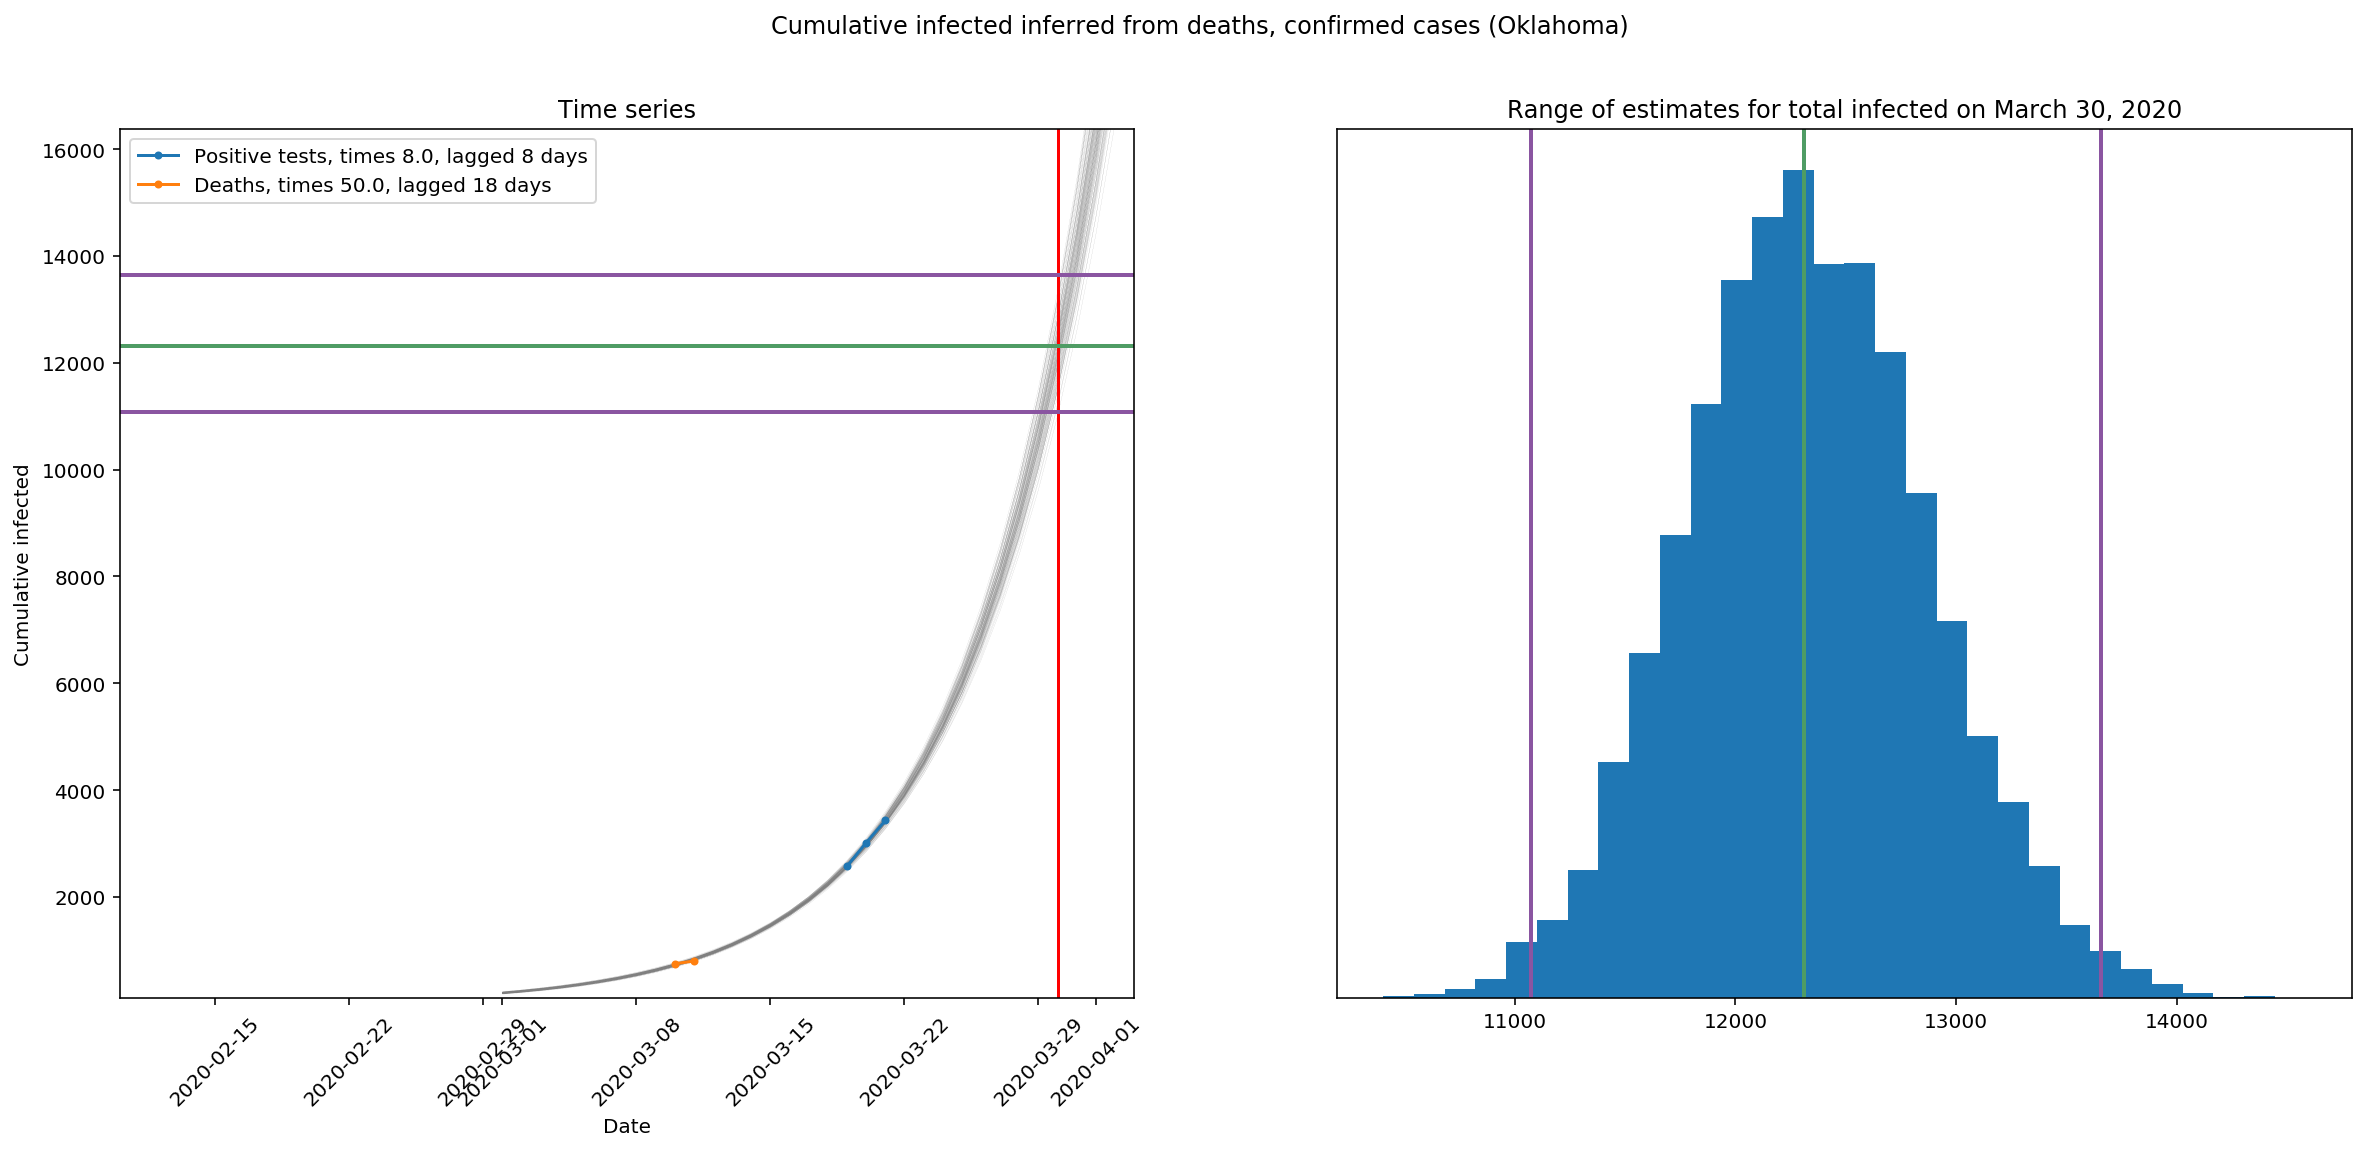

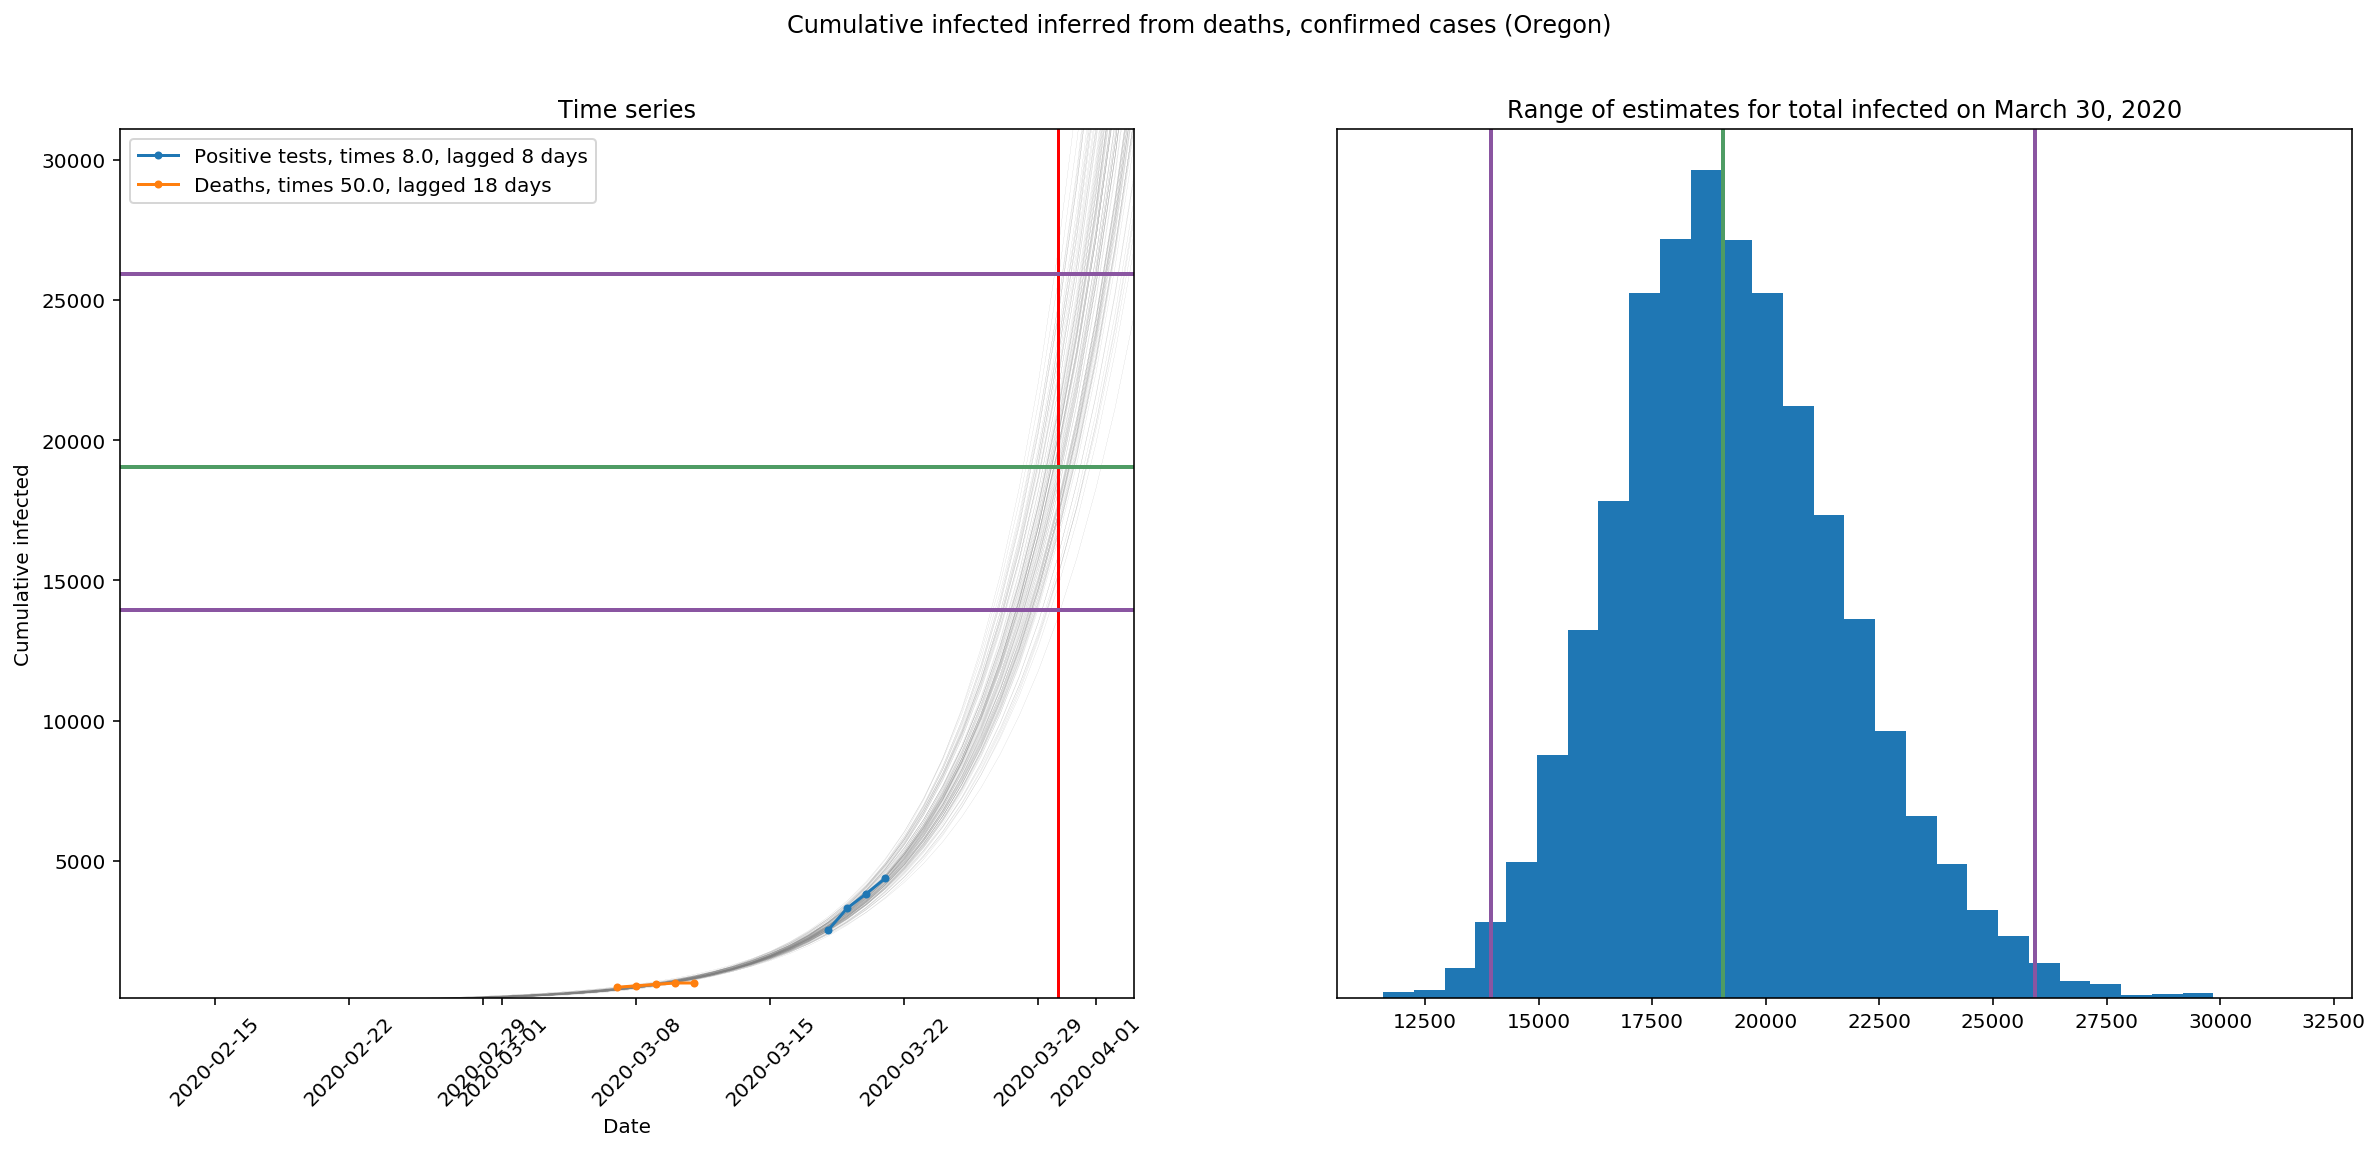

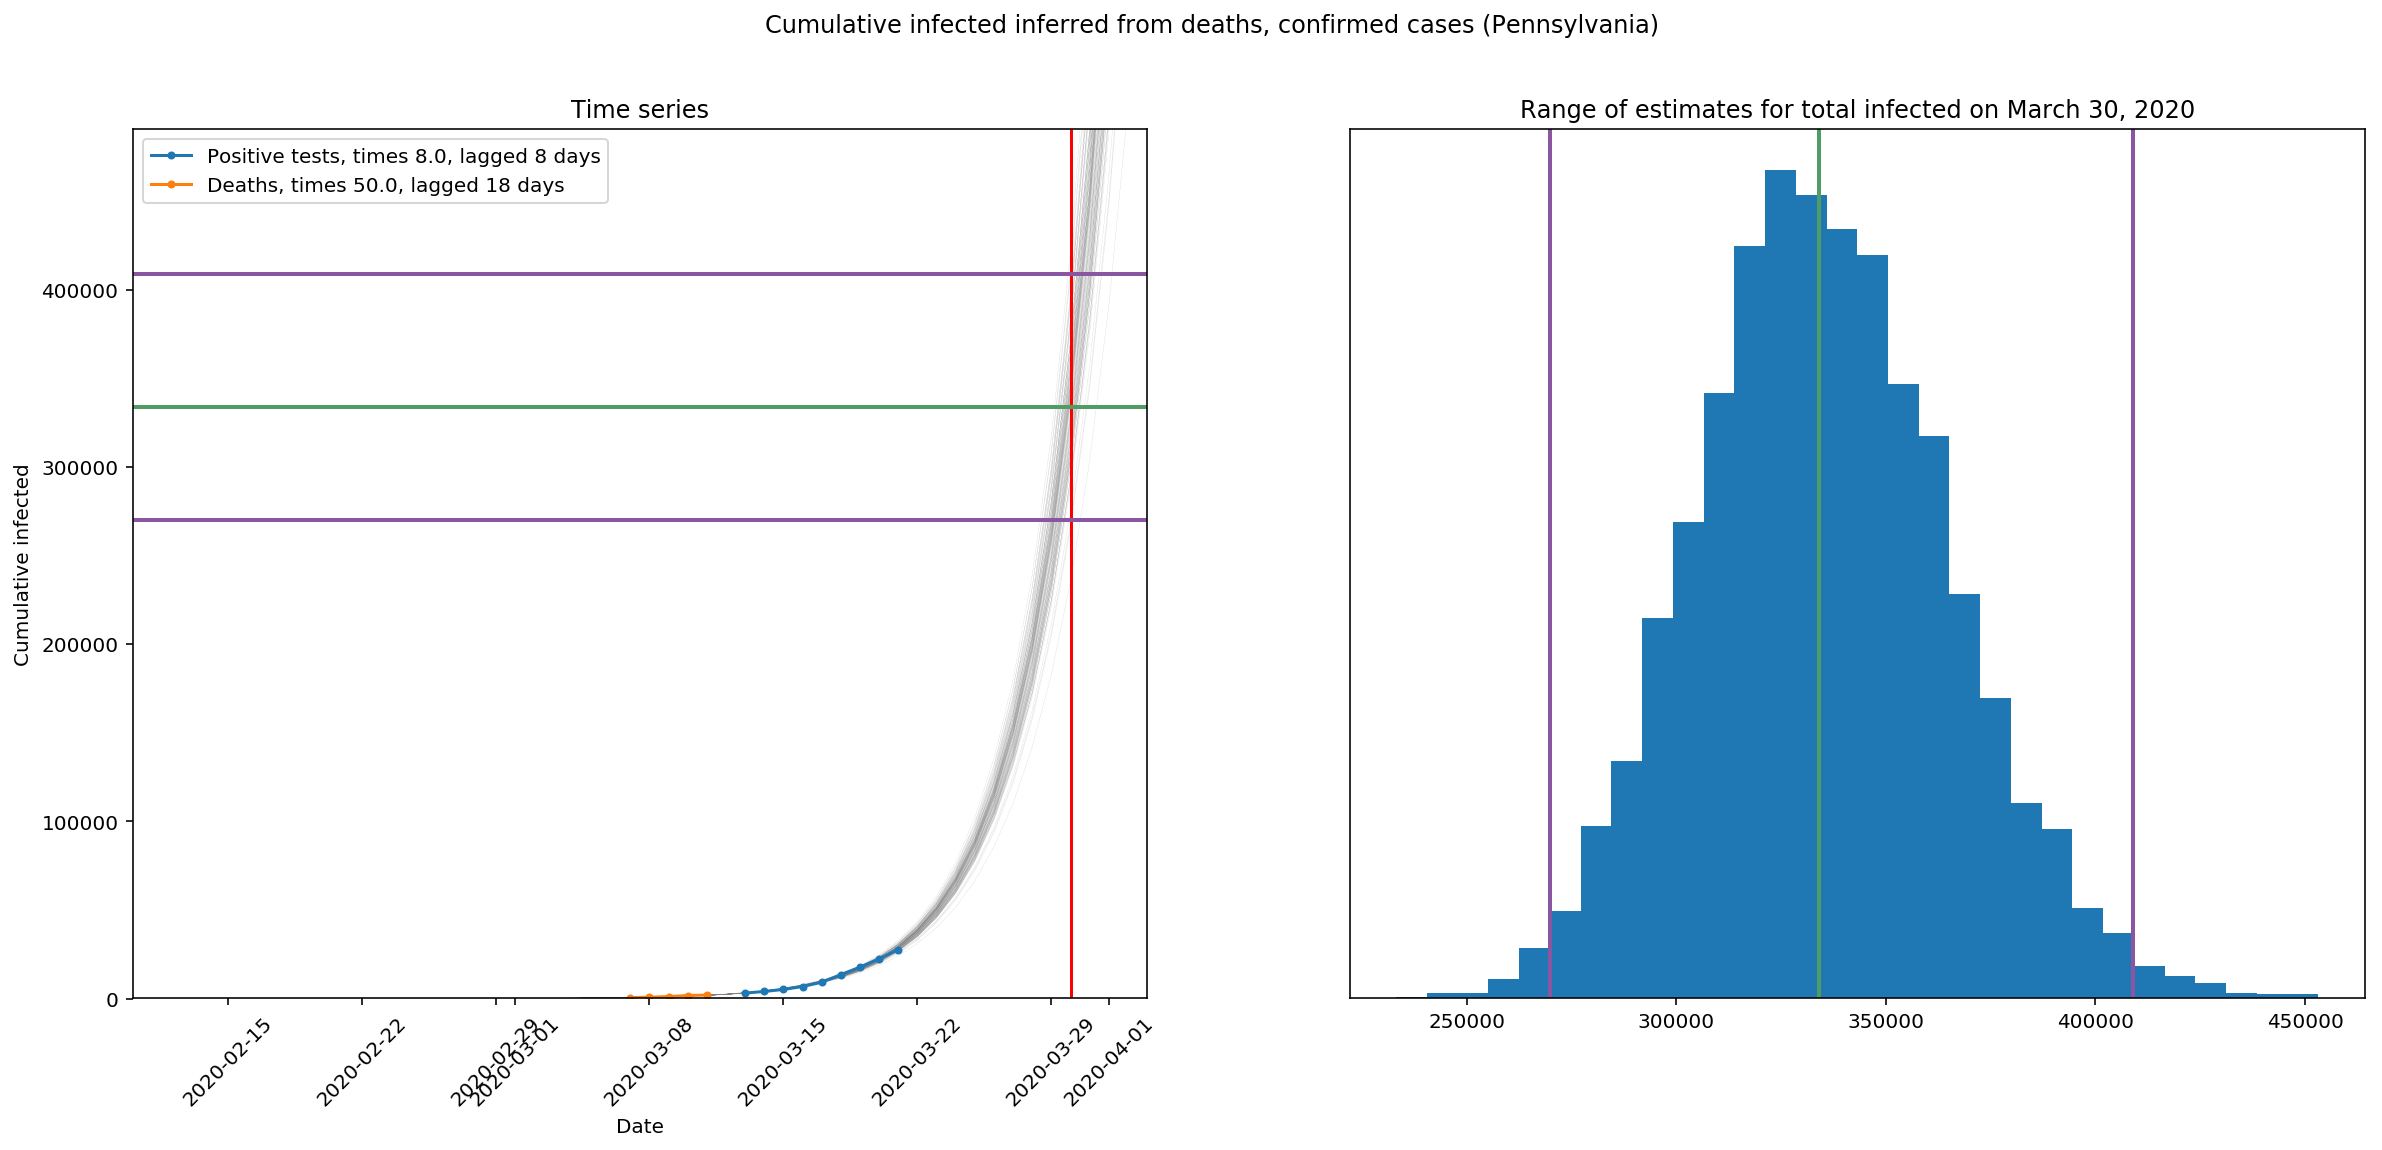

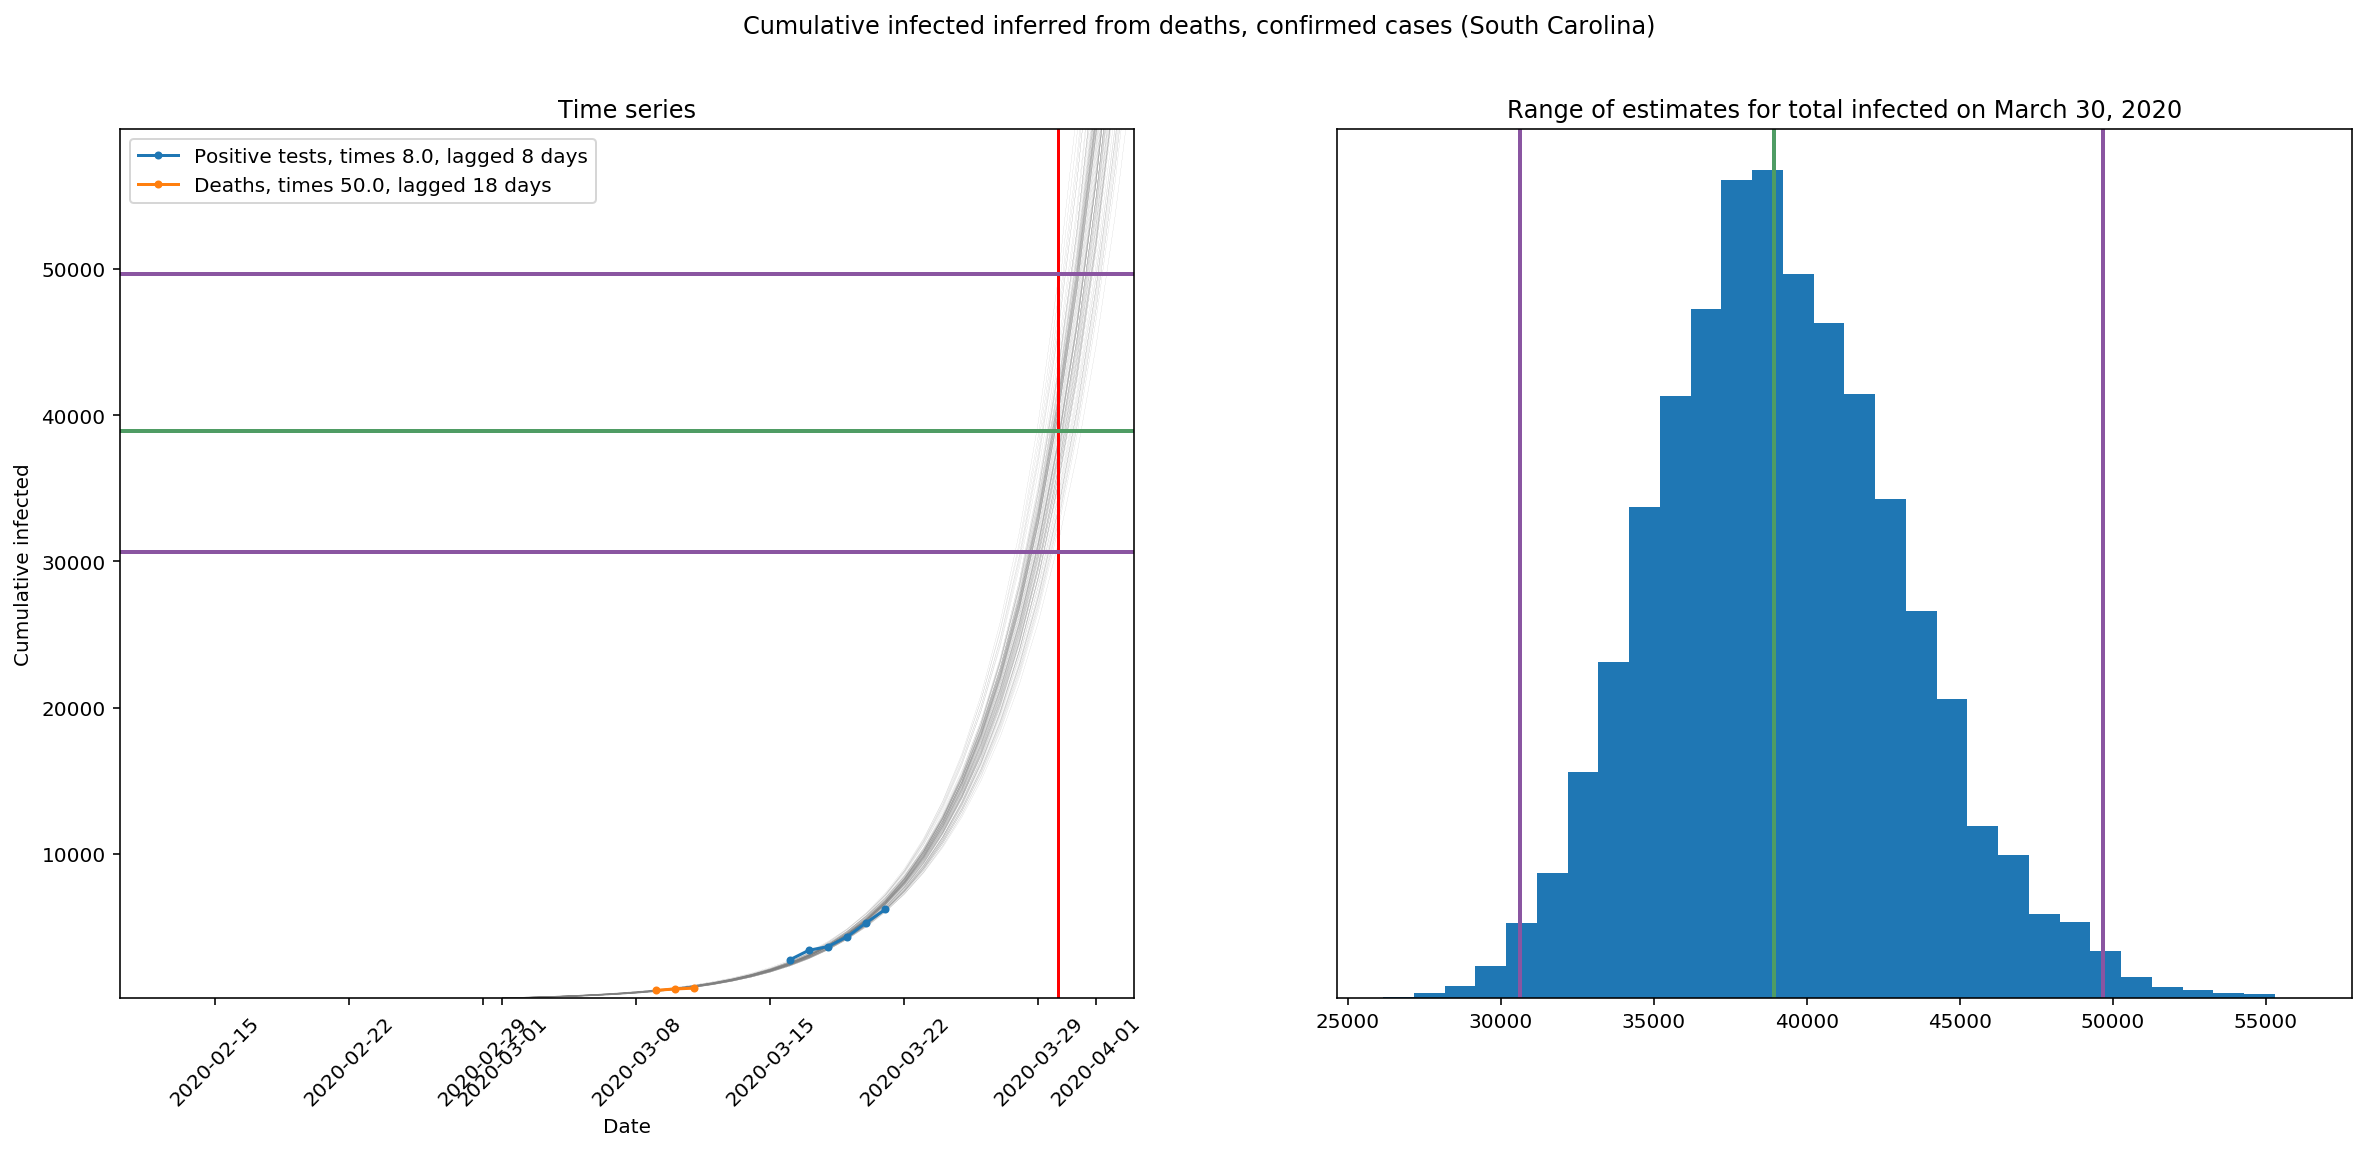

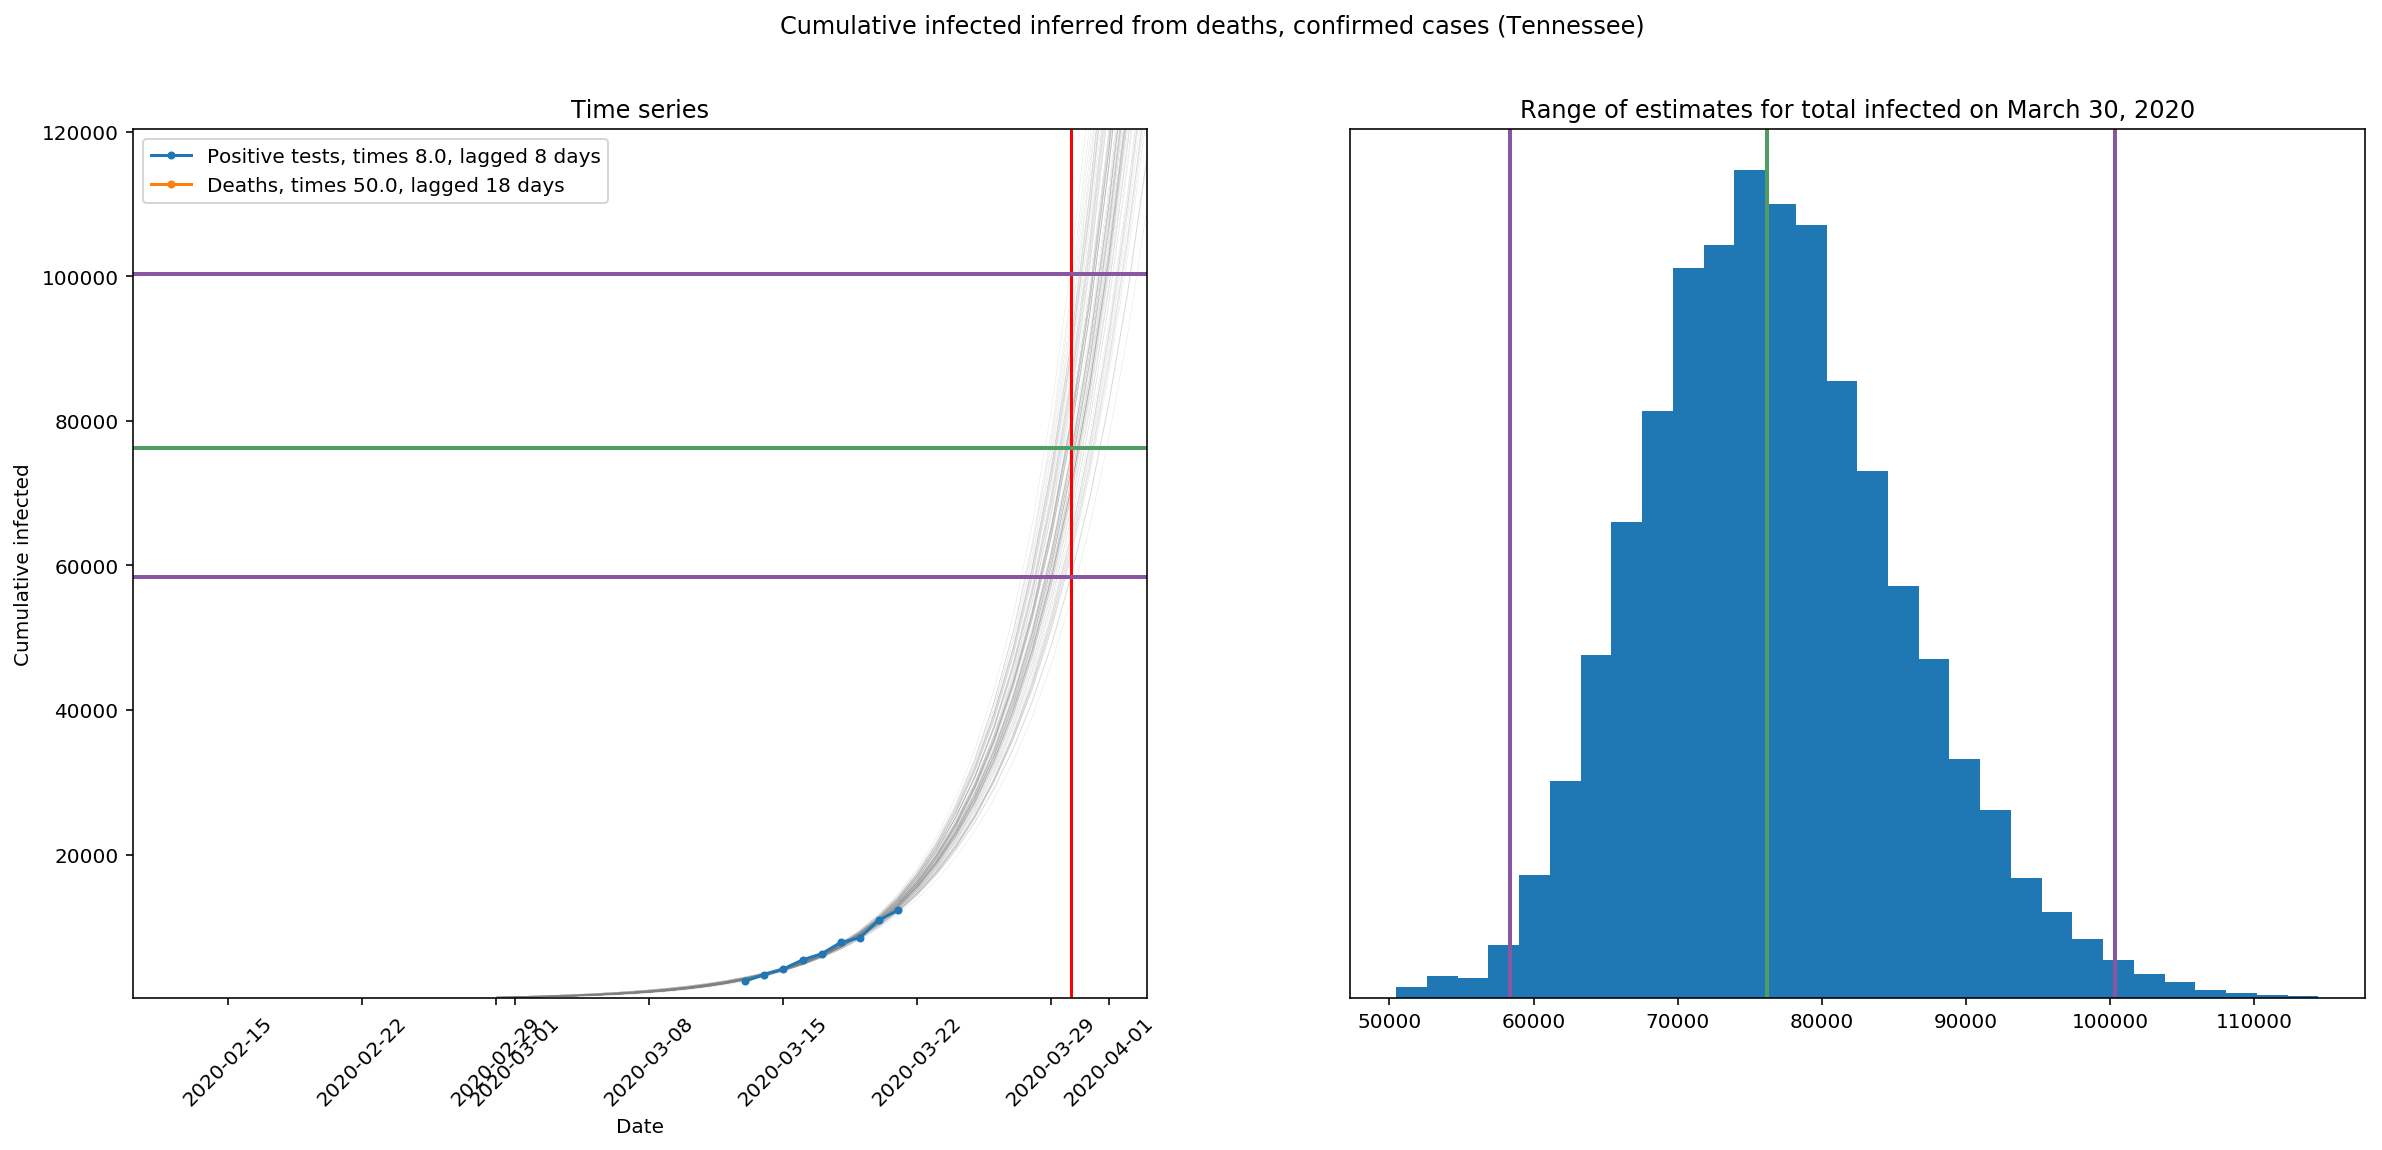

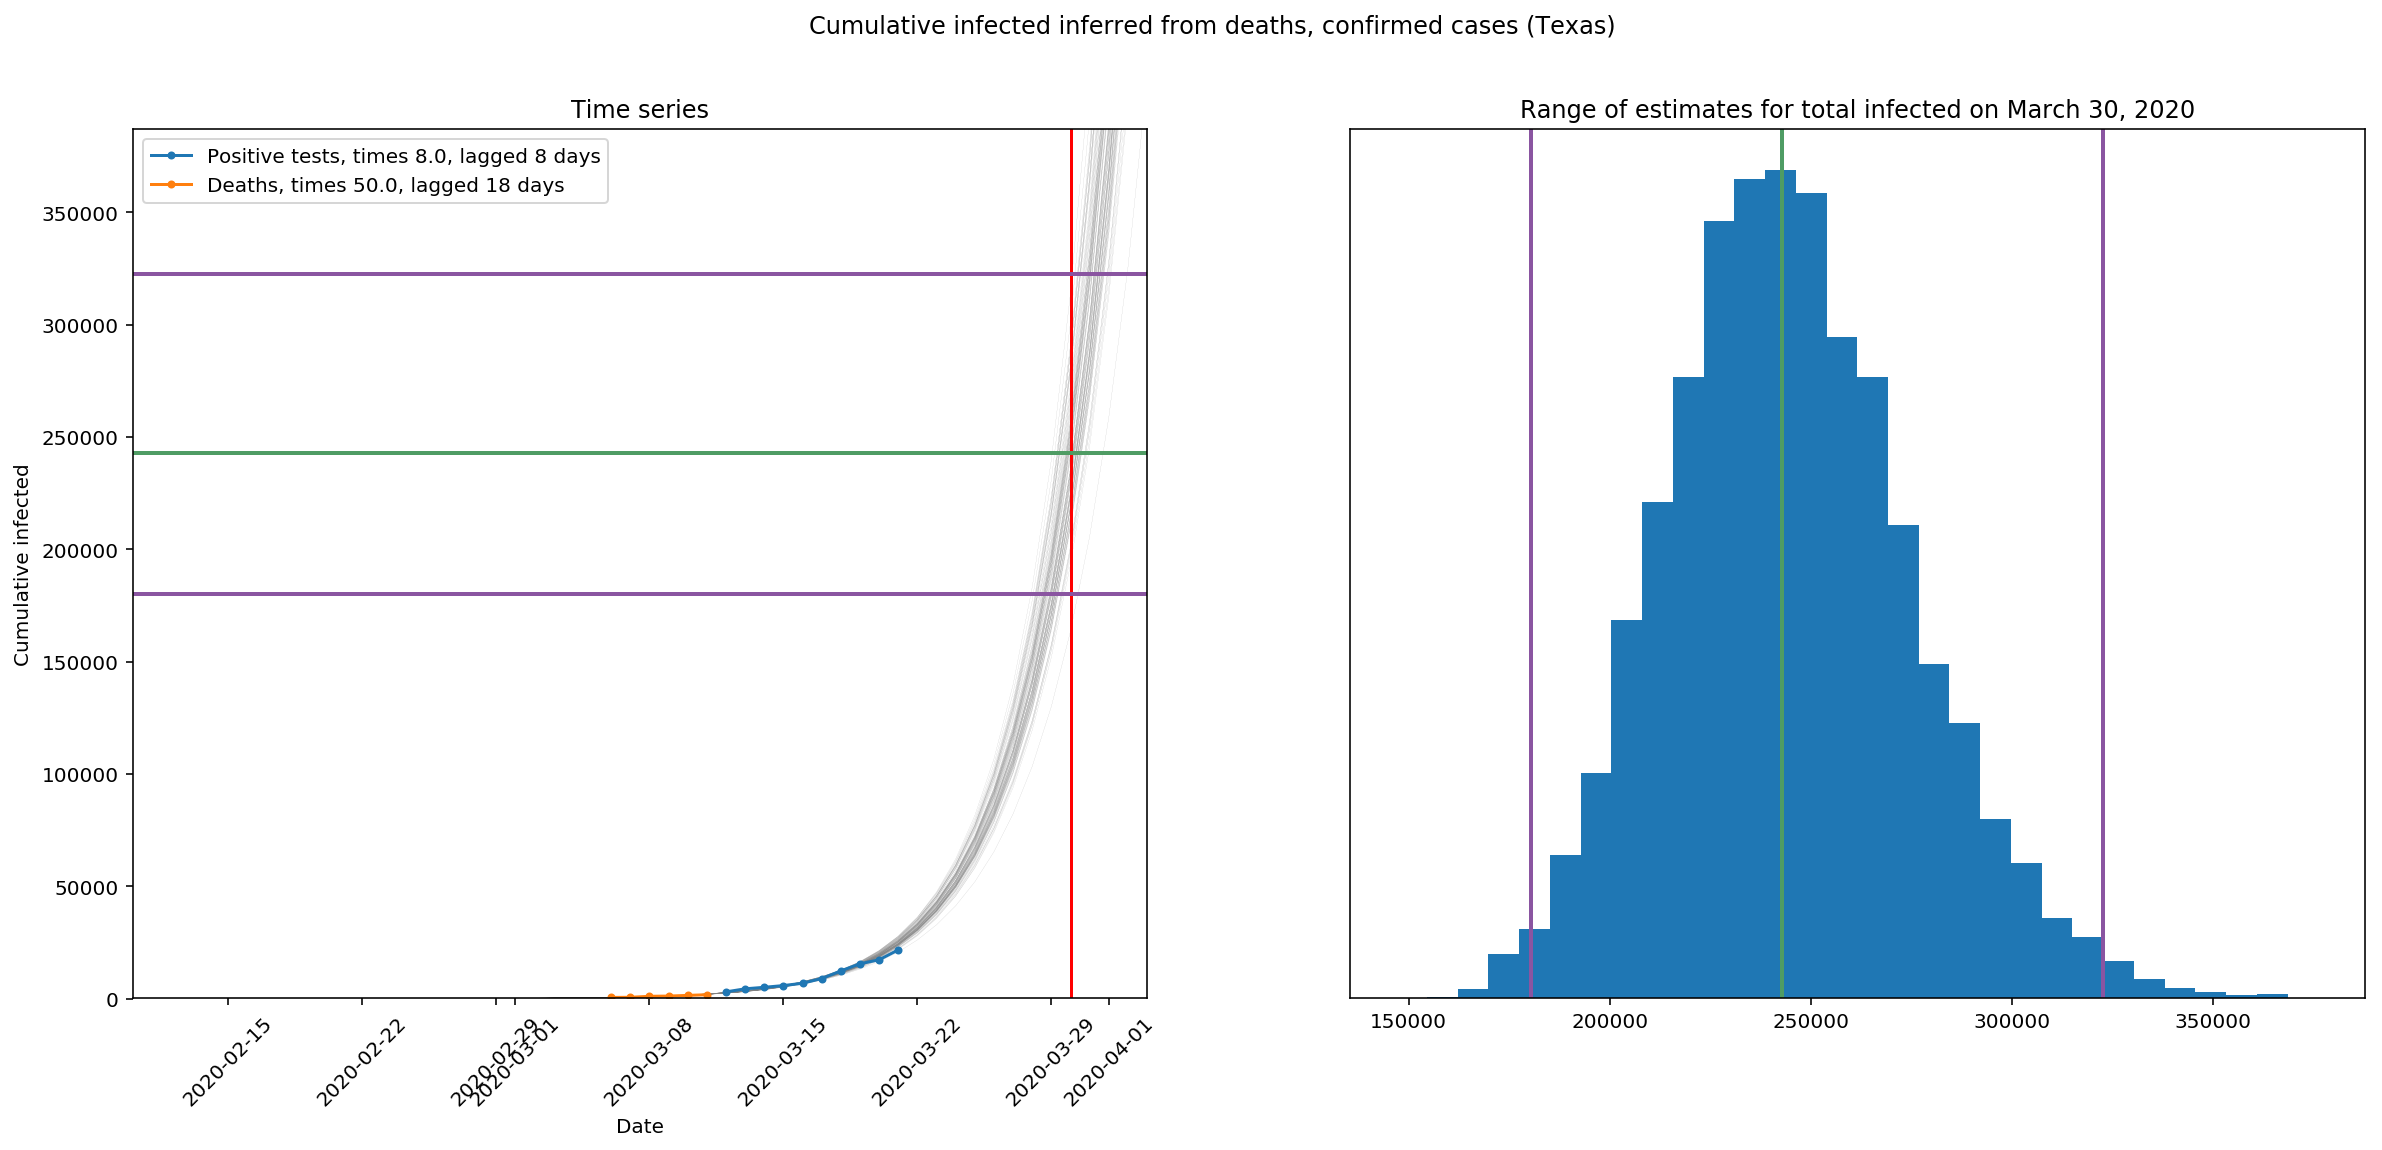

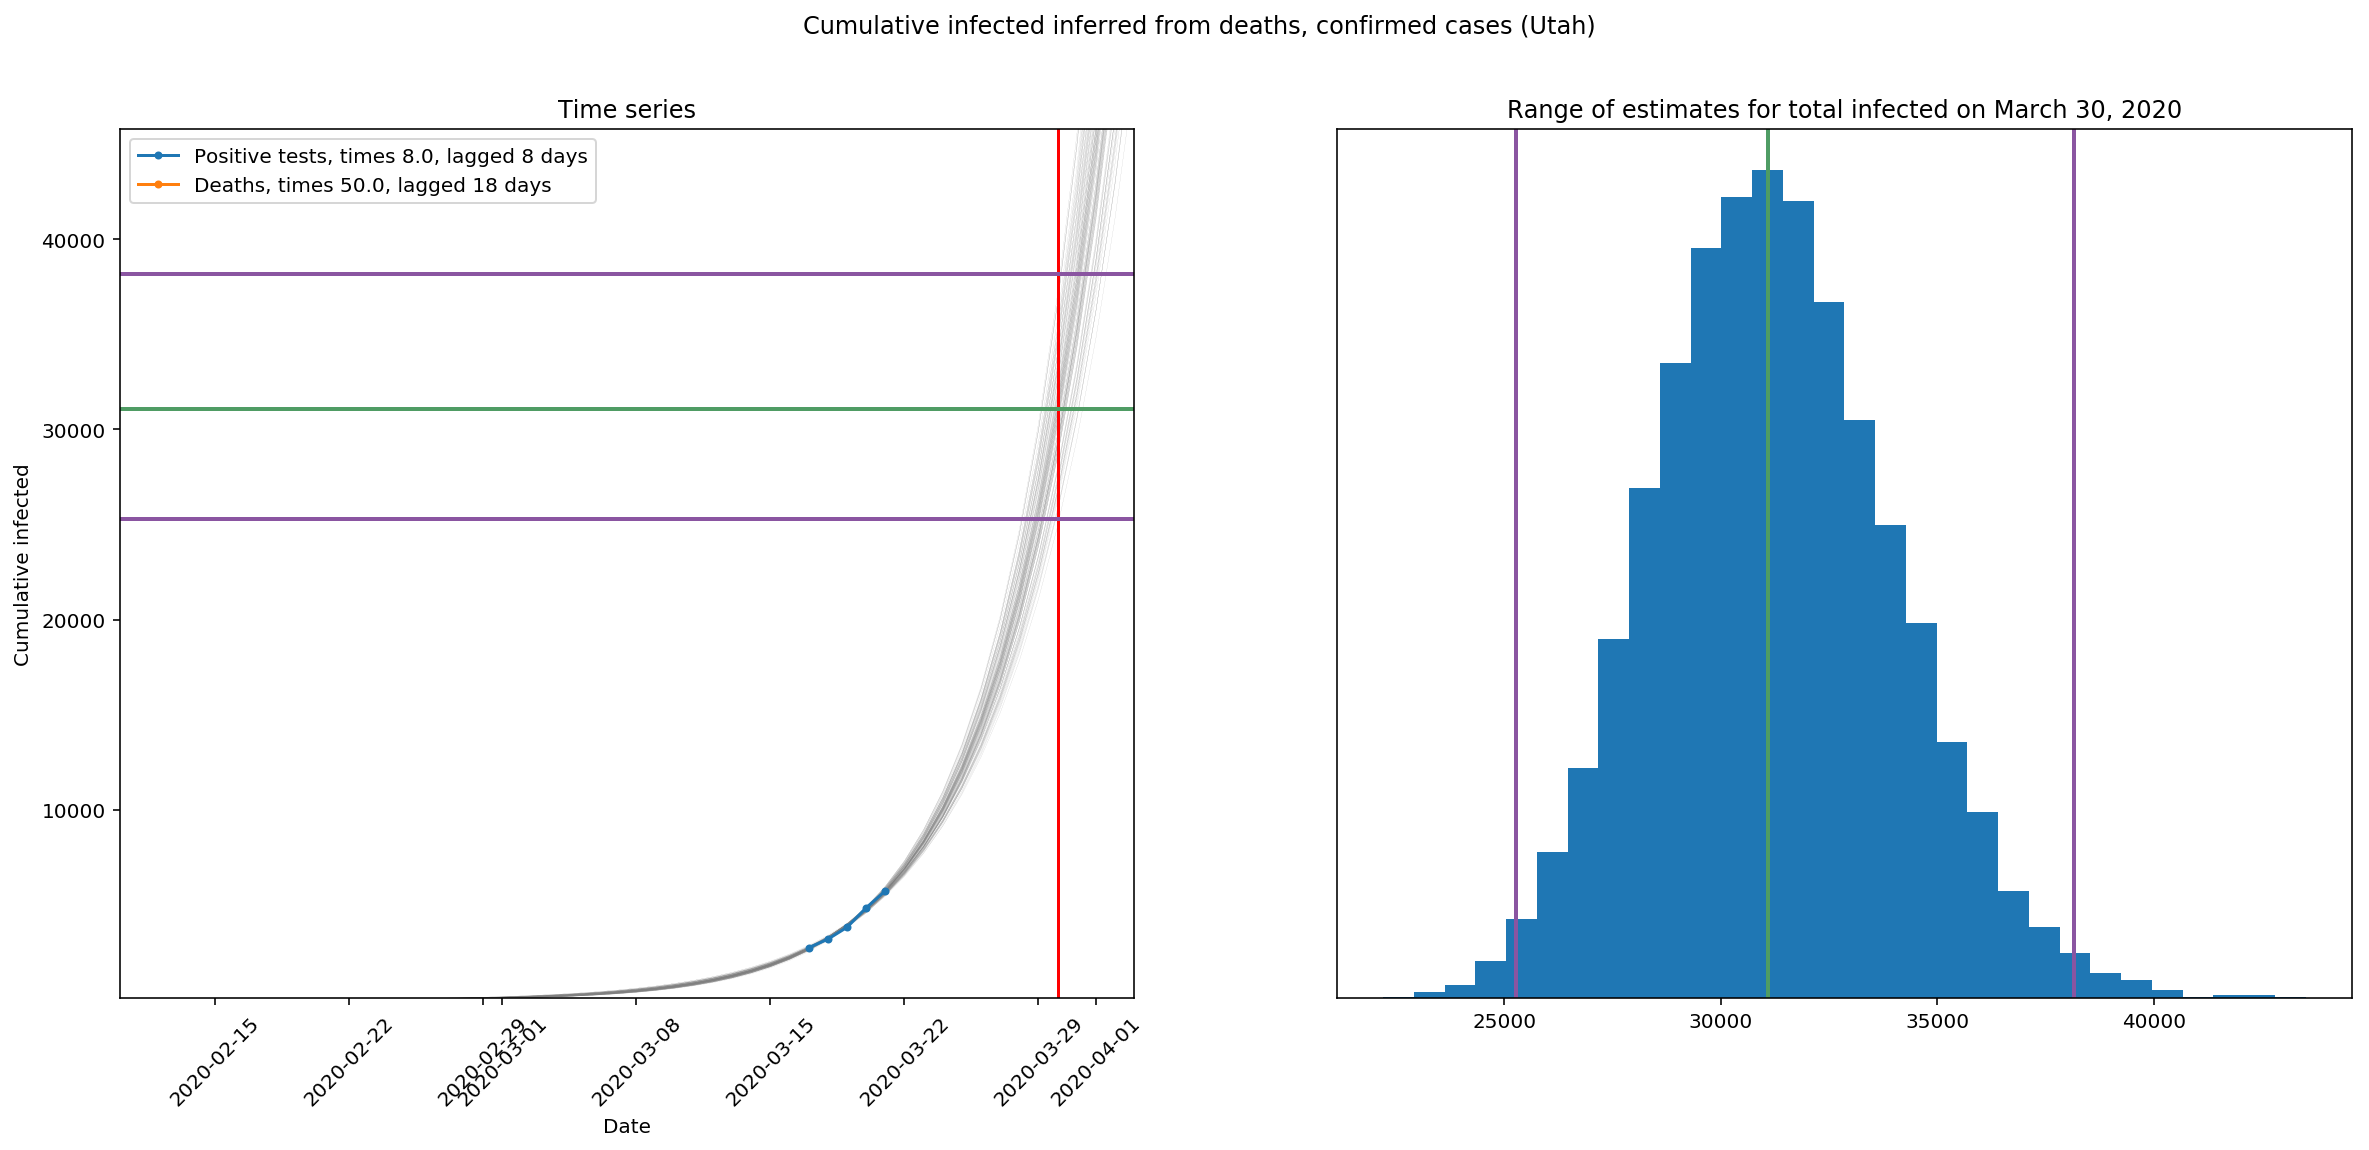

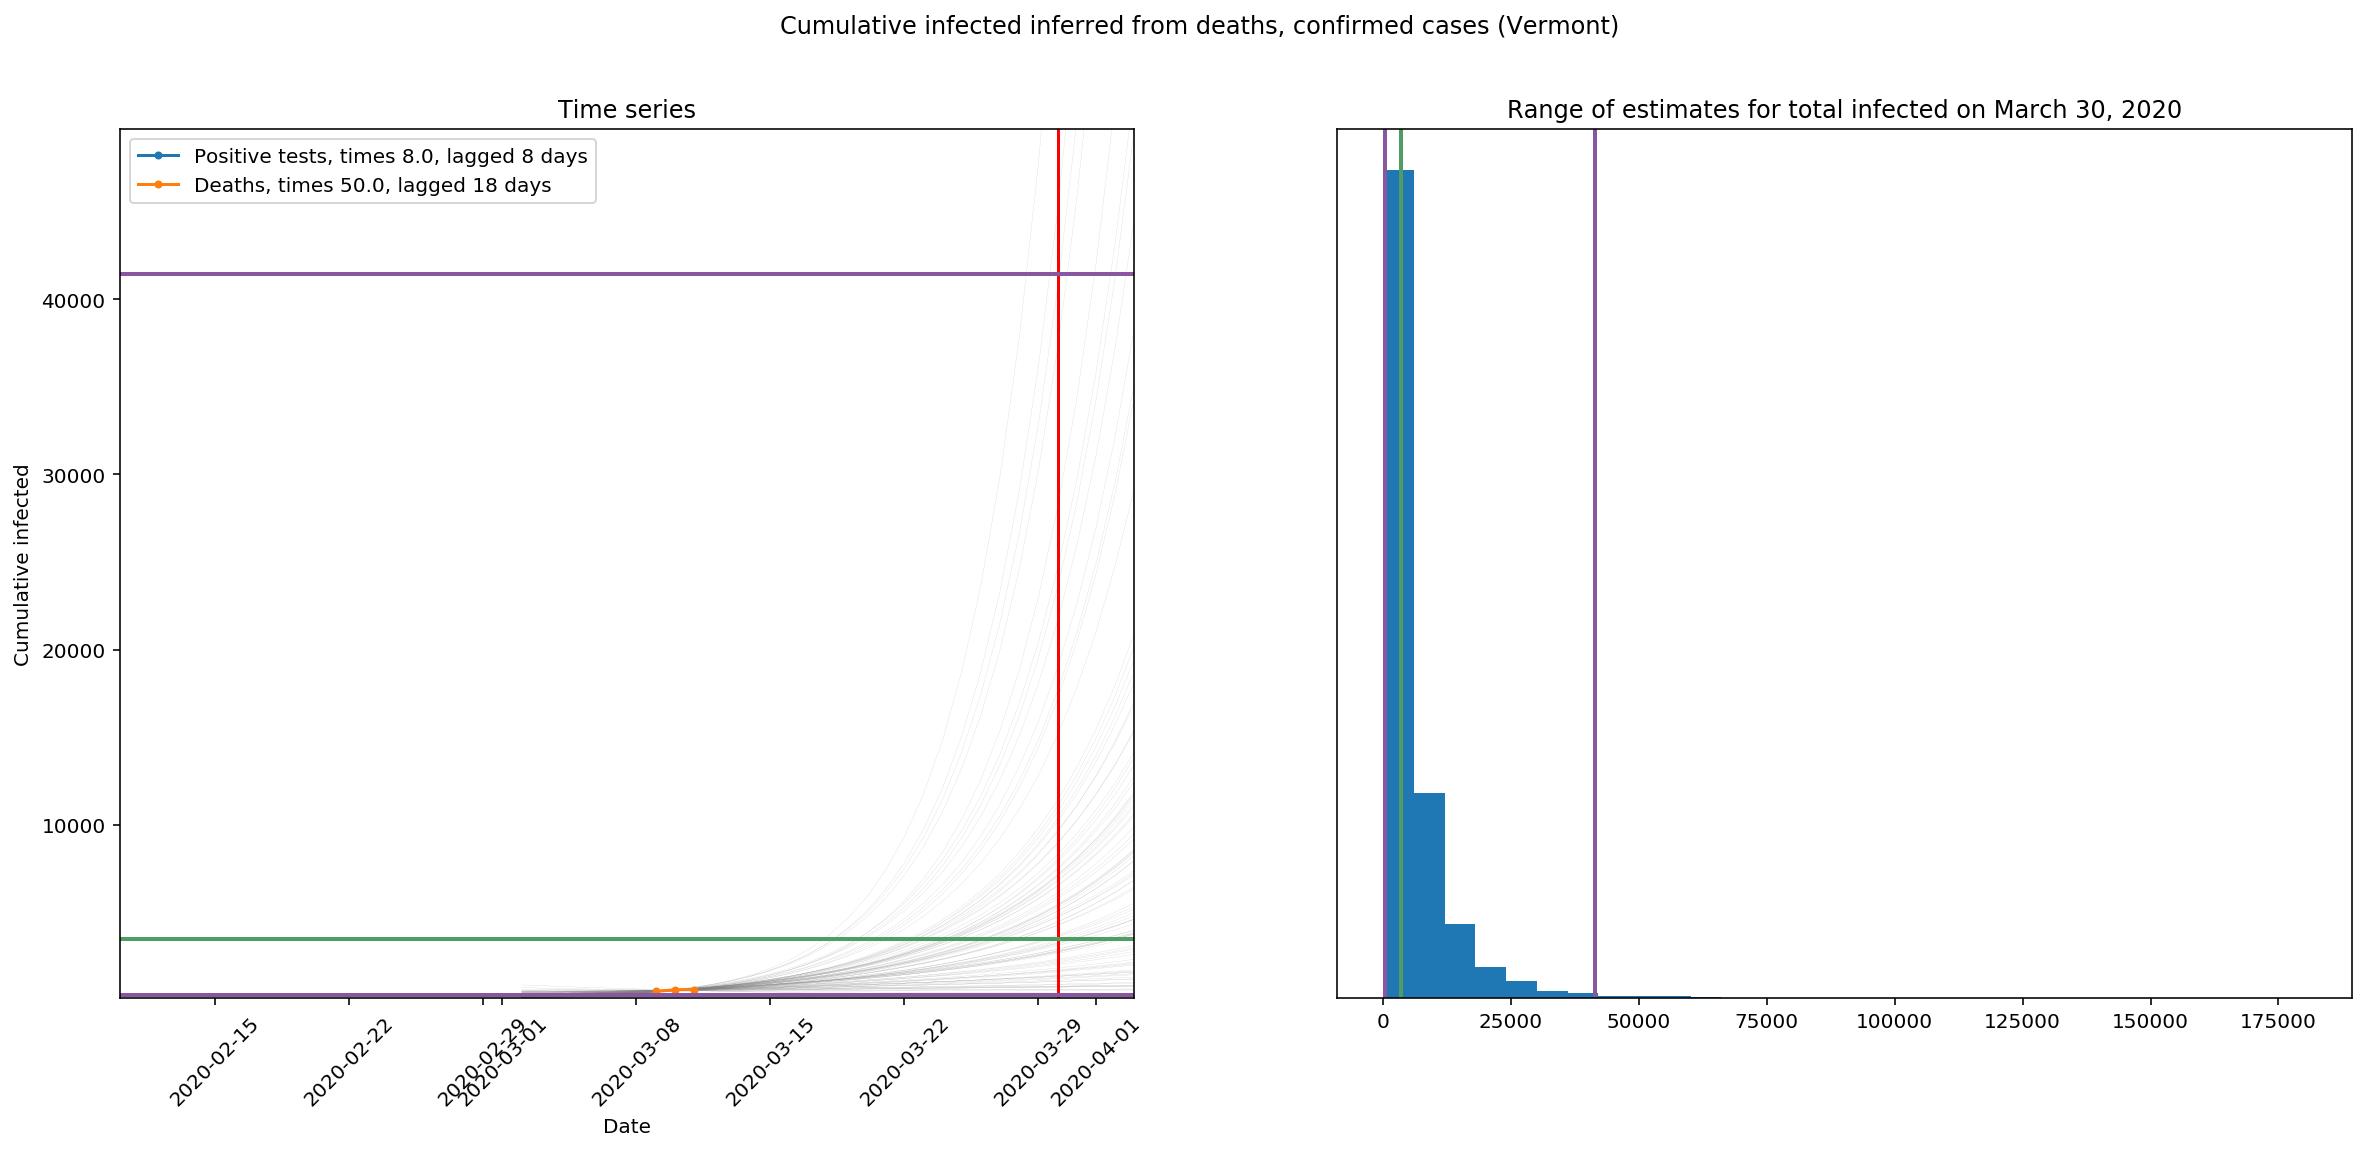

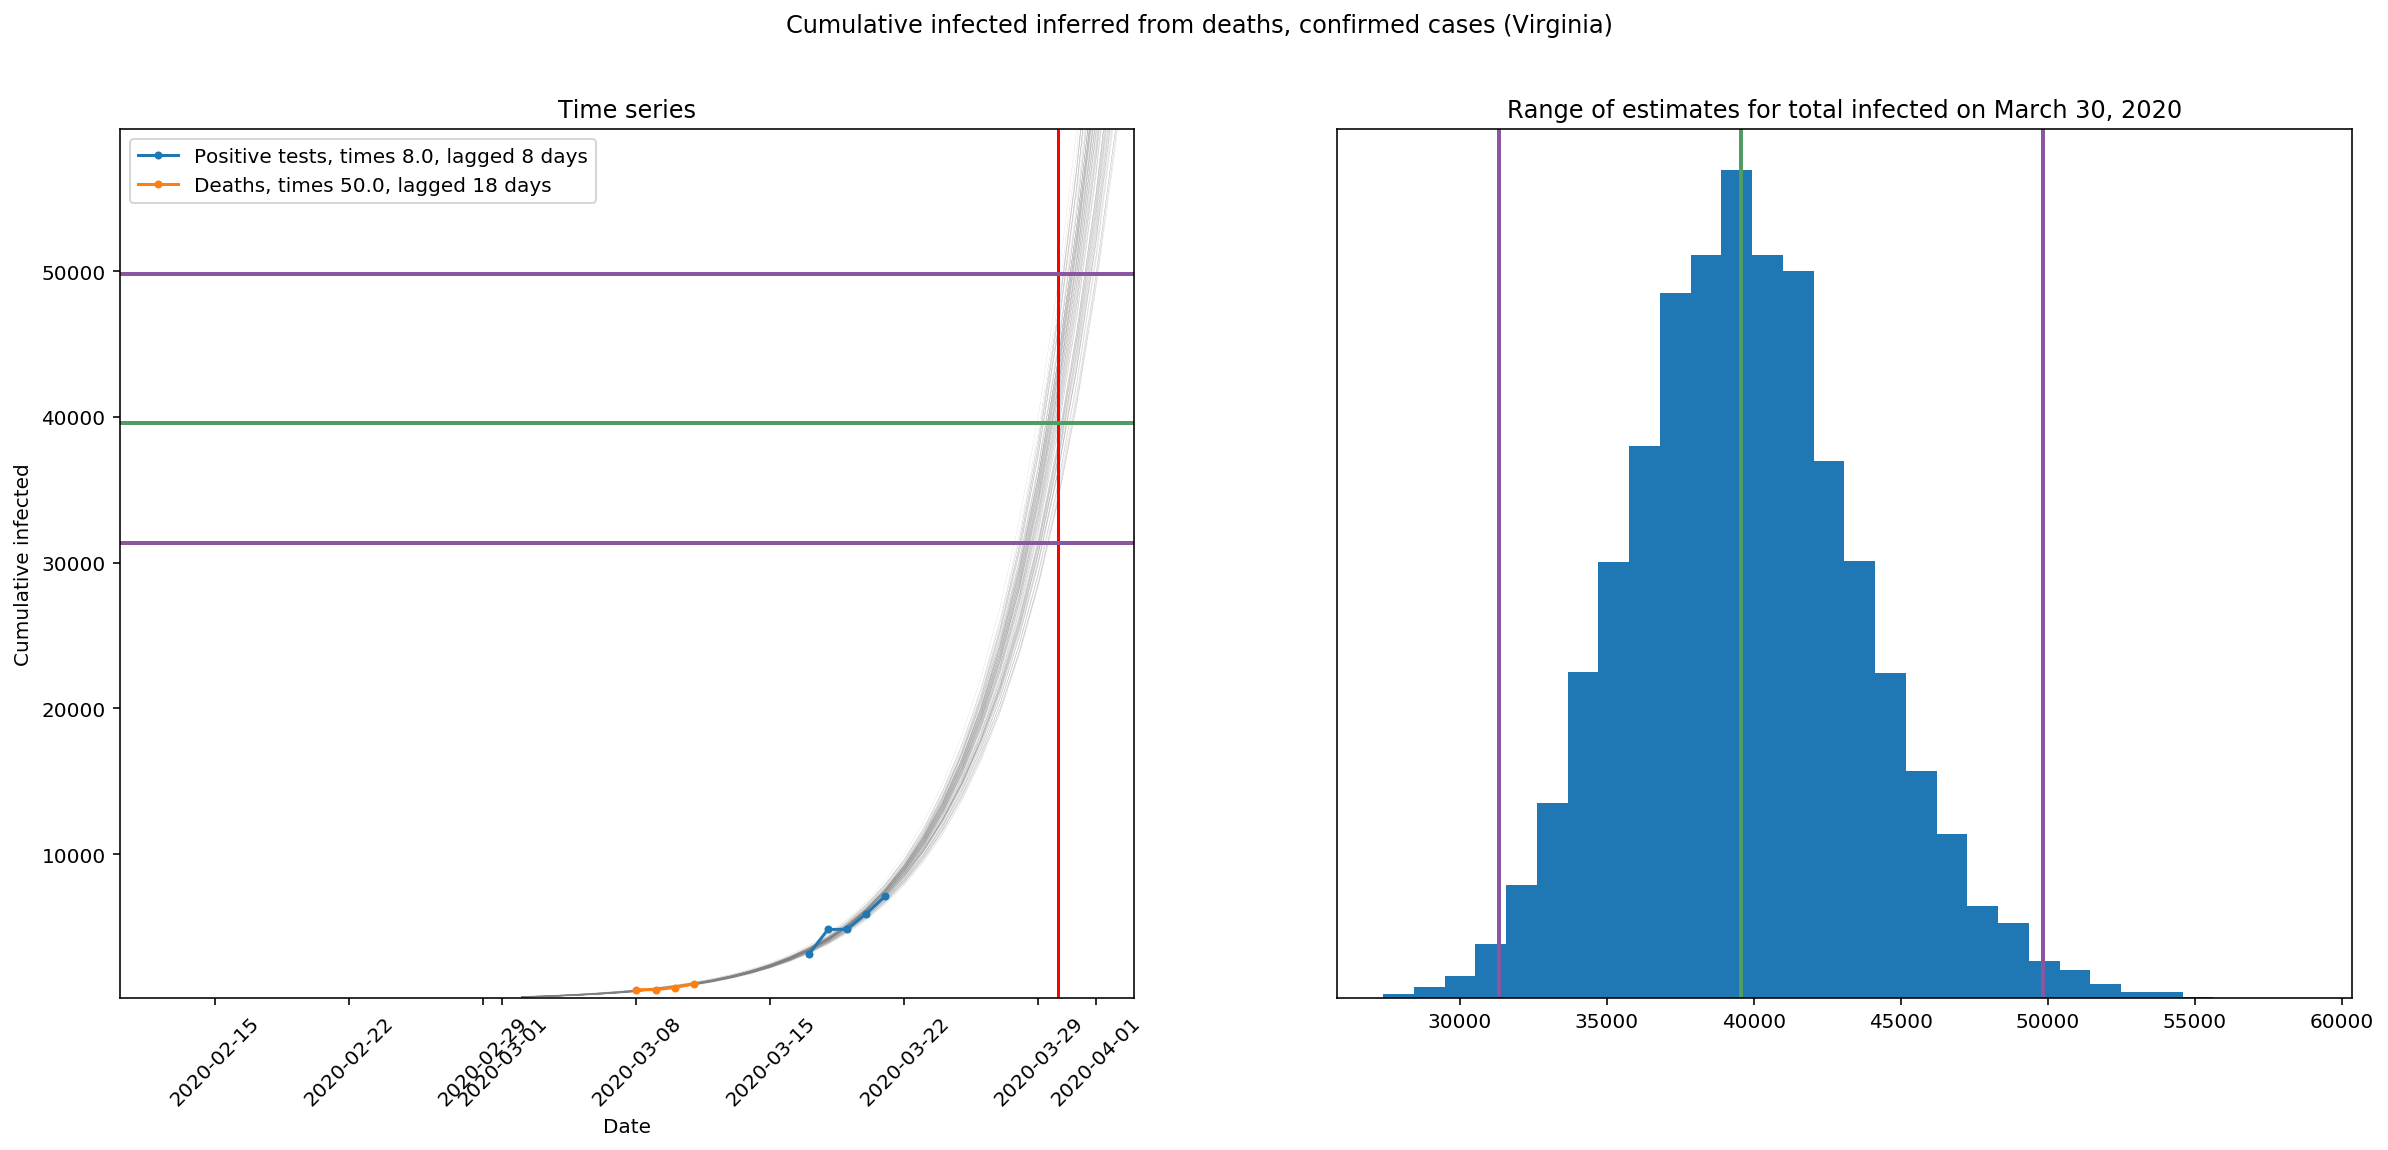

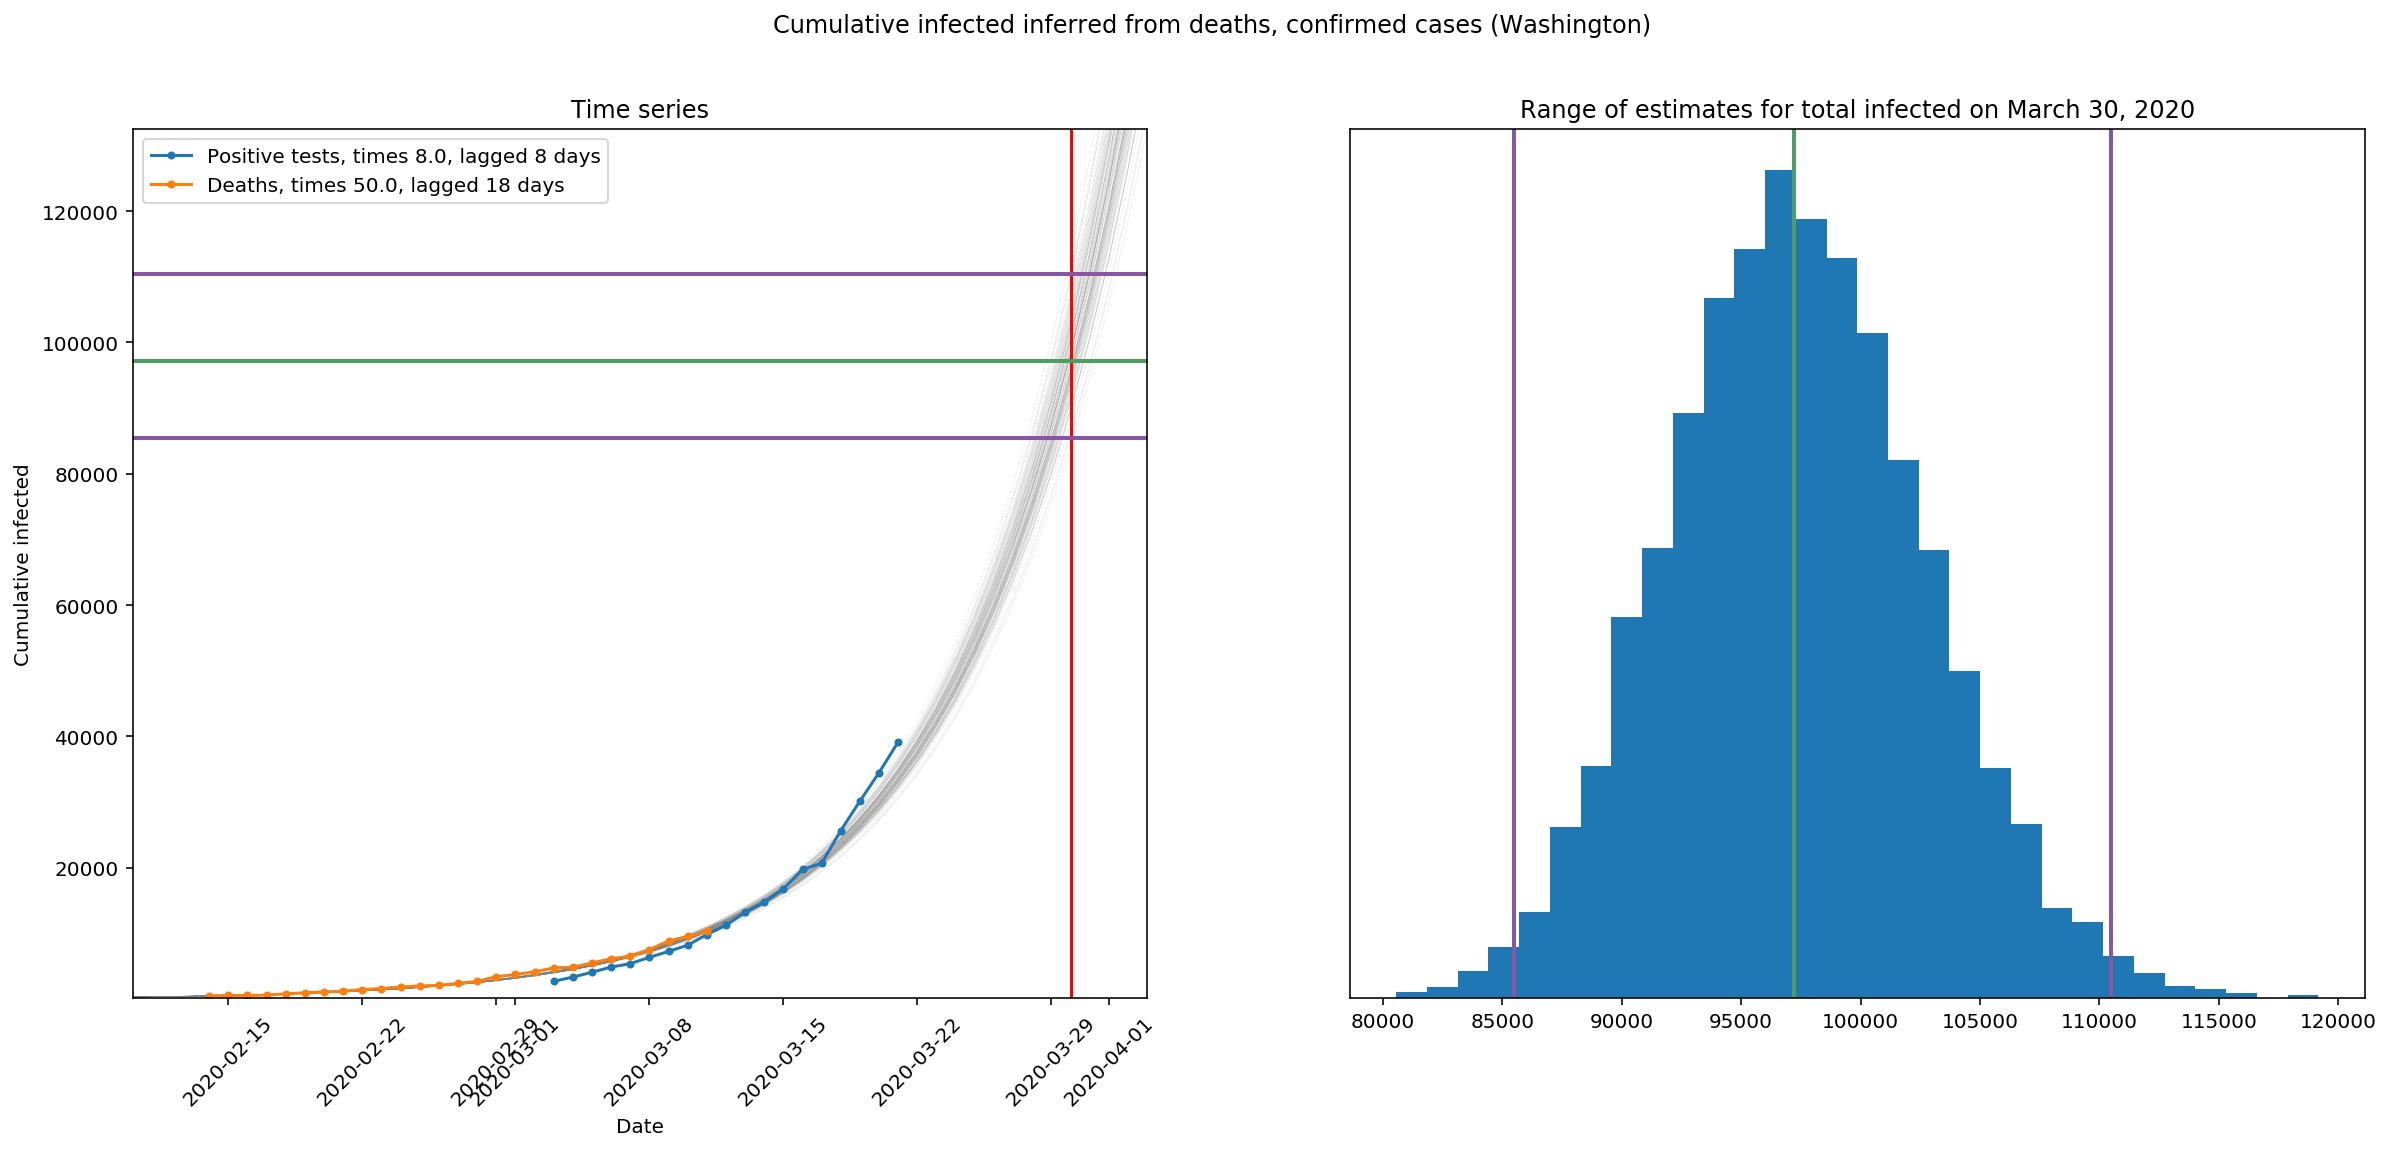

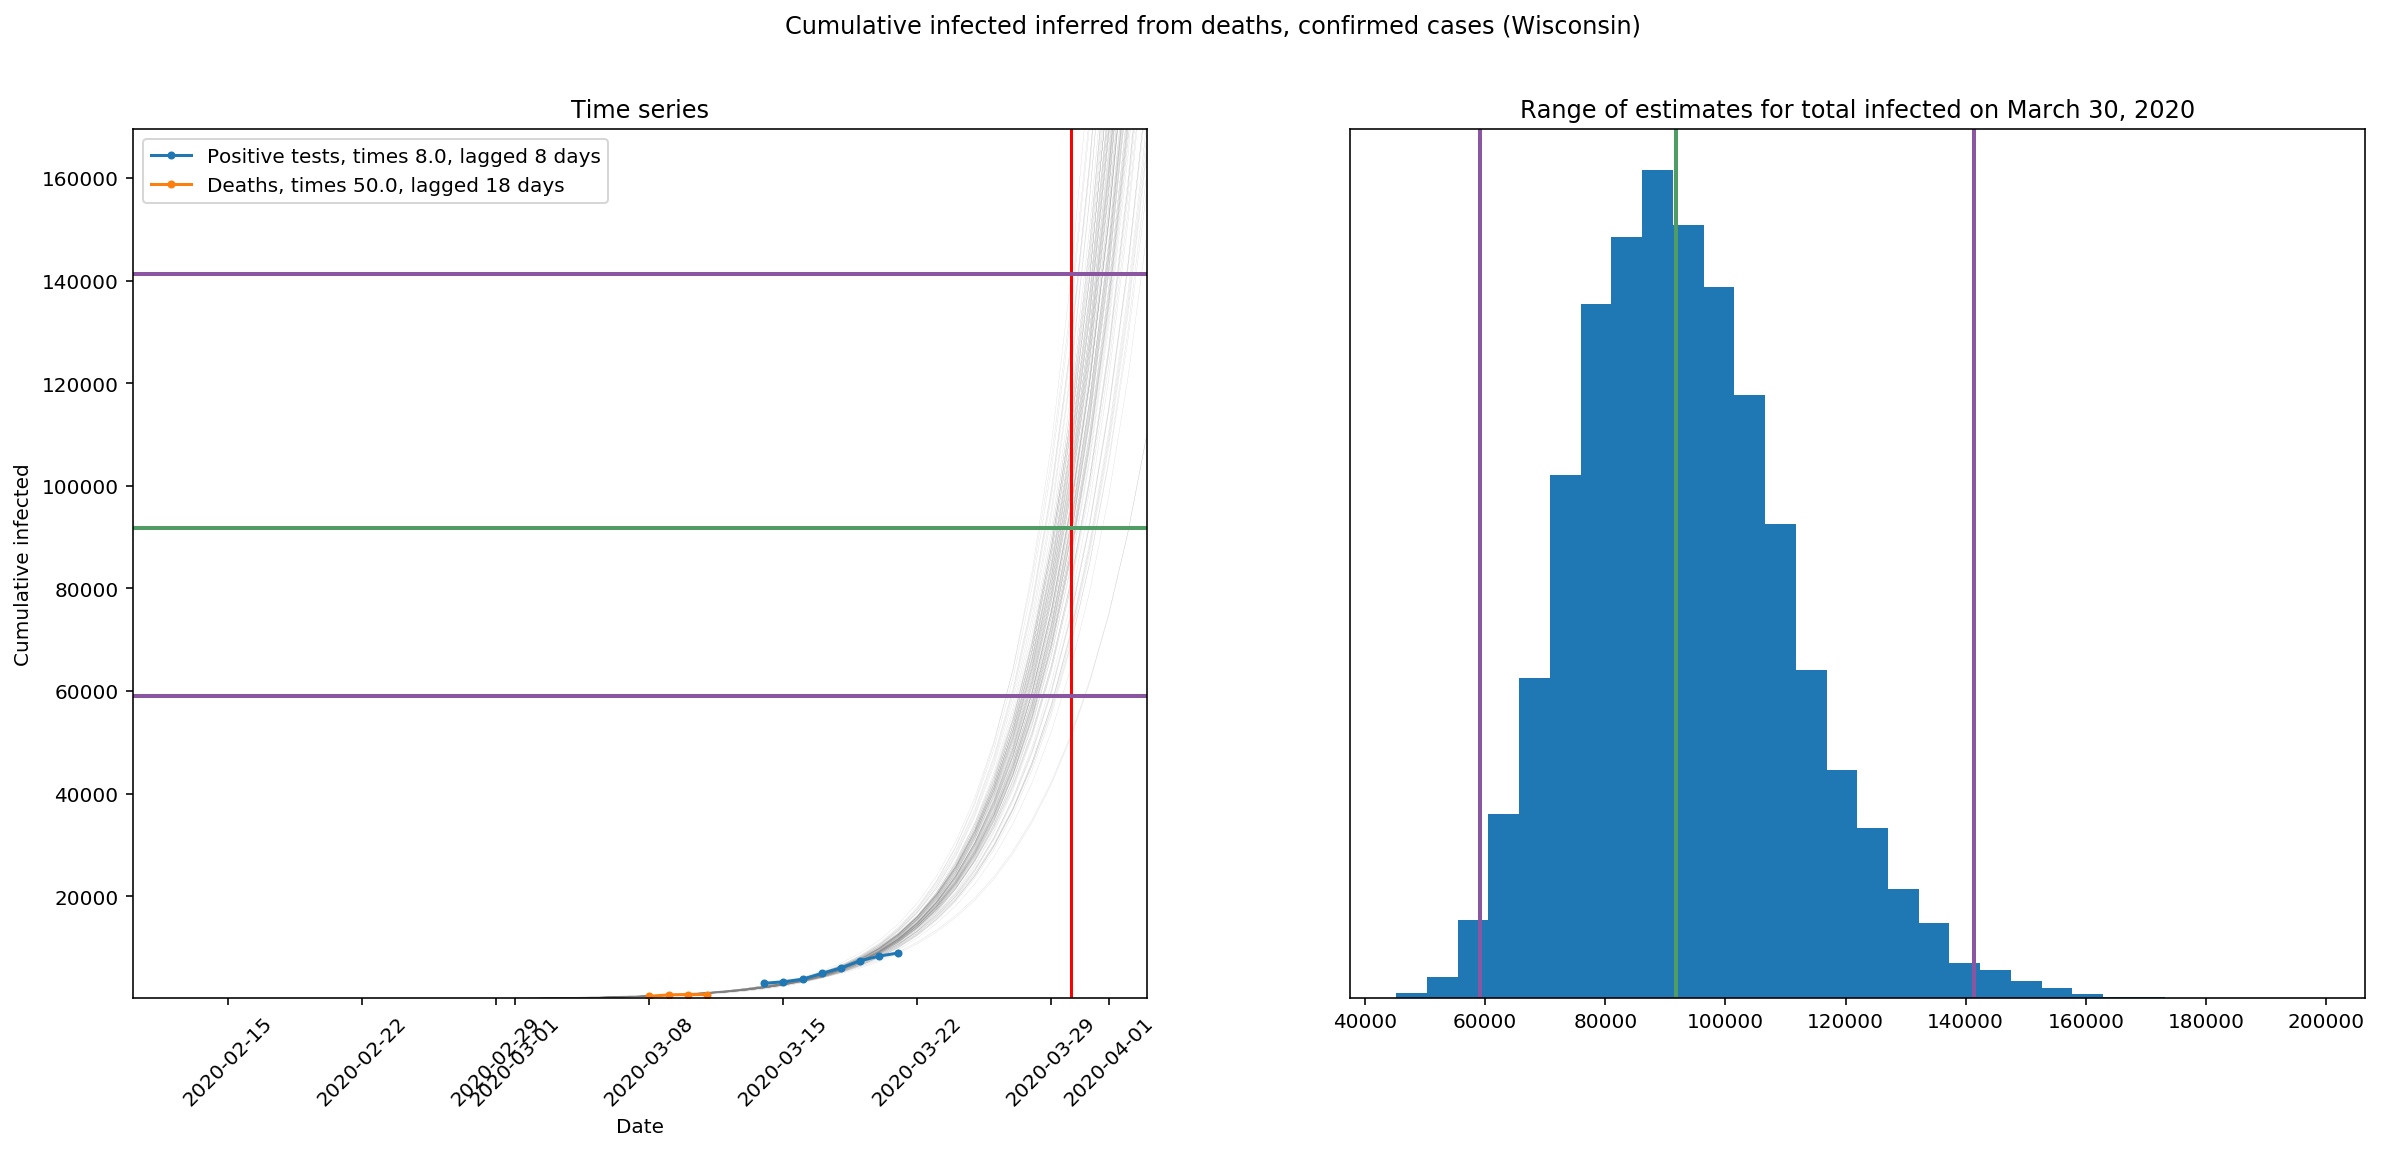

In [10]:
for state_name in state_pop_df["Geographic Area Name"].sort_values():
    report = prevalence_estimate(state_name)
    if report is None:
        print( "%s: not enough data"%state_name )
        continue
    print( report )
    